<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Norway/DNB/DNB_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "DNBNONOK"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-09-06 00:23:20,794 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-09-06 00:23:20,795 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for DNBNONOK
2019-09-06 00:23:27,939 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.
2019-09-06 00:26:59,883 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-09-06 00:34:36,179 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-09-06 00:38:36,246 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-09-06 00:42:29,333 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-09-06 00:46:30,956 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-09-06 00:50:24,545 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-09-06 00:54:24,941 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-09

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  1.52097  1.52747  1.51288  1.51598  1.992650
2018-01-02 09:00:00  1.51597  1.51648  1.50347  1.50687  1.553573
2018-01-02 10:00:00  1.50697  1.51097  1.50647  1.50987  0.940126
2018-01-02 11:00:00  1.50998  1.51137  1.50647  1.50838  0.870878
2018-01-02 12:00:00  1.50847  1.51248  1.50797  1.50848  0.927618
...                      ...      ...      ...      ...       ...
2018-12-28 11:00:00  1.38937  1.39098  1.38587  1.38738  1.600000
2018-12-28 12:00:00  1.38797  1.39048  1.38538  1.39048  1.590000
2018-12-28 13:00:00  1.38987  1.39198  1.38737  1.39138  2.280000
2018-12-28 14:00:00  1.39148  1.39297  1.38498  1.38637  2.670000
2018-12-28 15:00:00  1.38688  1.38747  1.37887  1.37897  1.620000

[1980 rows x 5 columns]

Open         High          Low        Close       Volume
count  1980.000000  1980.000000  1980.000000  1980.000000  1980.000000
mean      1.571156     1.574956     1.567306     1.571204     3.219291
std       0.075456     0.075329     0.075791     0.075616     2.032533
min       1.364380     1.366470     1.354870     1.363970     0.160000
25%       1.518470     1.521273     1.514370     1.518348     1.610000
50%       1.563225     1.566980     1.558670     1.563430     2.830000
75%       1.618980     1.623480     1.614870     1.619372     4.442500
max       1.734870     1.740470     1.729980     1.735380    18.000000

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
2018-01-10 10:00:00  1.56697  1.56748  1.56097  1.56197  2.491504   10          2         10             31    10             0               0                 0      1        1     2        2             1           2  1.571638  1.549436 -1.575554  1.567082  1.568437  1.569058    1.568975    1.558975  1.571799  1.571036  1.564147  1.571674  1.568780  1.571036  1.565310  1.568213                1.580658                 1.571036                1.561415                1.585469                 1.571036                1.556604                1.590280                 1.571036                1.551793                1.595091                 1.571036                1.546982  1.568437  1.565278  1.569138                1.578059                 1.568437                1.558816                1.582870                 1.568437                1.554005                1.587681                 1.568437                1.549194                1.592492                 1.568437                1.544383   
2018-01-10 11:00:00  1.56198  1.57148  1.56198  1.56997  1.601533   10          2         10             31    11             0               0                 0      1        1     2        2             1           2  1.571555  1.549989 -1.574862  1.567989  1.568778  1.569091    1.568975    1.558975  1.540970  1.570411  1.566146  1.569999  1.568543  1.570411  1.565970  1.568514                1.579568                 1.570411                1.561254                1.584146                 1.570411                1.556676                1.588725                 1.570411                1.552098                1.593303                 1.570411                1.547519  1.568778  1.567936  1.569292                1.577935                 1.568778                1.559621                1.582513                 1.568778                1.555043                1.587091                 1.568778                1.550464                1.591670                 1.568778                1.545886   
2018-01-10 12:00:00  1.5

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000    1930.000000  1930.000000   1930.000000     1930.000000       1930.000000  1930.000000  1930.000000  1930.000000  1930.000000   1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000  1930.000000             1930.000000              1930.000000             1930.000000             1930.000000              1930.000000             1930.000000             1930.000000              1930.000000             1930.000000             1930.000000              1930.000000             1930.000000  1930.000000  1930.000000  1930.000000             1930.000000              1930.000000             1930.000000             1930.000000              1930.000000             1930.000000             1930.000000   
mean      1.571837     1.575642     1.567953     1.571853     3.267930    15.890674     2.024870   186.316062      30.409326    10.880829      0.032642        0.024352          0.004145     6.629534     2.547150    27.184456     2.024870      1.996373    27.184456     1.572194     1.572925     0.091712     1.571850     1.572192     1.571529     1.572163     1.571930     1.571636     1.572188     1.571848     1.572187     1.572076     1.572188     1.571930     1.572874                1.584494                 1.572188                1.559882                1.590647                 1.572188                1.553728                1.596800                 1.572188                1.547575                1.602953                 1.572188                1.541422     1.572192     1.571927     1.572774                1.584498                 1.572192                1.559885                1.590651                 1.572192                1.553732                1.596804   
std       0.076215     0.076082     0.076568     0.076385     2.033303     8.577459     1.413628   101.631867       0.859983     2.337579      0.177745        0.154180          0.064265     3.345813     1.101441    14.517117     1.413628      1.406306    14.517117     0.075487     0.073516     1.571602     0.076484     0.075384     0.075935     0.075552     0.075437     0.075828     0.075563     0.076473     0.075652     0.075763     0.075563     0.076182     0.074040                0.074419                 0.075563                0.077954                0.074335                 0.075563                0.079584                0.074578                 0.075563                0.081482                0.075147                 0.075563                0.083629     0.075384     0.076129     0.074261                0.074193                 0.075384                0.077822                0.074086                 0.075384                0.079475                0.074309   
min       1.364380     1.366470     1.354870     1.363970     0.160000     1.000000     0.000000    10.000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-10 10:00:00  0.546816  0.537460  0.549439  0.533103  0.130690   10          2         10             31    10             0               0                 0      1        1     2        2             1           2  0.561417  0.493889  0.047616  0.549010  0.552750  0.557633    0.554565    0.527762  0.562576  0.561394  0.538033  0.561586  0.553899  0.561394  0.543099  0.549205                0.566972                 0.561394                0.559895                0.563950                 0.561394                0.598364                0.546189                 0.561394                0.631509                0.526827                 0.561394                0.659283  0.552750  0.541199  0.553095                0.558179                 0.552750                0.562018                0.550499                 0.552750                0.602966                0.540033                 0.552750                0.636137                0.525149                 0.552750   
2018-01-10 11:00:00  0.533348  0.548155  0.552131  0.554643  0.080803   10          2         10             31    11             0               0                 0      1        1     2        2             1           2  0.561182  0.495533  0.047816  0.551482  0.553702  0.557727    0.554565    0.527762  0.482624  0.559665  0.543497  0.556947  0.553243  0.559665  0.544898  0.550077                0.563992                 0.559665                0.559461                0.560392                 0.559665                0.598541                0.542179                 0.559665                0.632185                0.522426                 0.559665                0.660367  0.553702  0.548470  0.553541                0.557835                 0.553702                0.564174                0.549537                 0.553702                0.605456                0.538491                 0.553702                0.638891                0.523080                 0.553702   
2018-01-10 12:00:00  0.556263  0.546818  0.564101  0.550631  0.060077   10          2         10         

139648

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmps3tgdgtn
  JVM stdout: /tmp/tmps3tgdgtn/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmps3tgdgtn/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 18 days
H2O cluster name:           H2O_from_python_unknownUser_adv4ng
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0              DeepLearning_1_AutoML_20190906_011758  0.571105  1.757532              0.440422  0.688853  0.474519
1  DeepLearning_grid_1_AutoML_20190906_011758_mod...  0.550959  0.780577              0.490789  0.530281  0.281198
2  DeepLearning_grid_1_AutoML_20190906_011758_mod...  0.538138  0.689705              0.463747  0.498283  0.248286
3  DeepLearning_grid_1_AutoML_20190906_011758_mod...  0.527042  5.005583              0.480392  0.651604  0.424588
4  DeepLearning_grid_1_AutoML_20190906_011758_mod...  0.524133  0.723558              0.500000  0.514108  0.264307
5  DeepLearning_grid_1_AutoML_20190906_011758_mod...  0.518315  0.692186              0.459438  0.499519  0.249520
6  DeepLearning_grid_1_AutoML_20190906_011758_mod...  0.500000  0.692566              0.500000  0.499709  0.249709
7  DeepLearning_grid_1_AutoML_20190906_011758_mod...  0.500000  0.692496              0.500000  0.499674  0.249674
8  DeepLearning_grid_1_AutoML_20190906_011758_mod...  0.495583  1.425875              0.490196  0.644635  0.415554
9  DeepLearning_grid_1_AutoML_20190906_011758_mod...  0.458199  1.022724              0.500000  0.590562  0.348763

variable  relative_importance  scaled_importance  percentage
0                          OBV             1.000000           1.000000    0.001910
1           CDLIDENTICAL3CROWS             0.850503           0.850503    0.001624
2                  HT_DCPERIOD             0.831773           0.831773    0.001589
3            CDL3WHITESOLDIERS             0.820197           0.820197    0.001566
4                 HT_TRENDMODE             0.787960           0.787960    0.001505
...                        ...                  ...                ...         ...
1031  BBANDS_middleband_12_3_3             0.272428           0.272428    0.000520
1032                    MOM_14             0.253538           0.253538    0.000484
1033   BBANDS_middleband_8_6_3             0.253441           0.253441    0.000484
1034         CDLGRAVESTONEDOJI             0.253326           0.253326    0.000484
1035                aroonup_12             0.195219           0.195219    0.000373

[1036 rows x 4 columns]

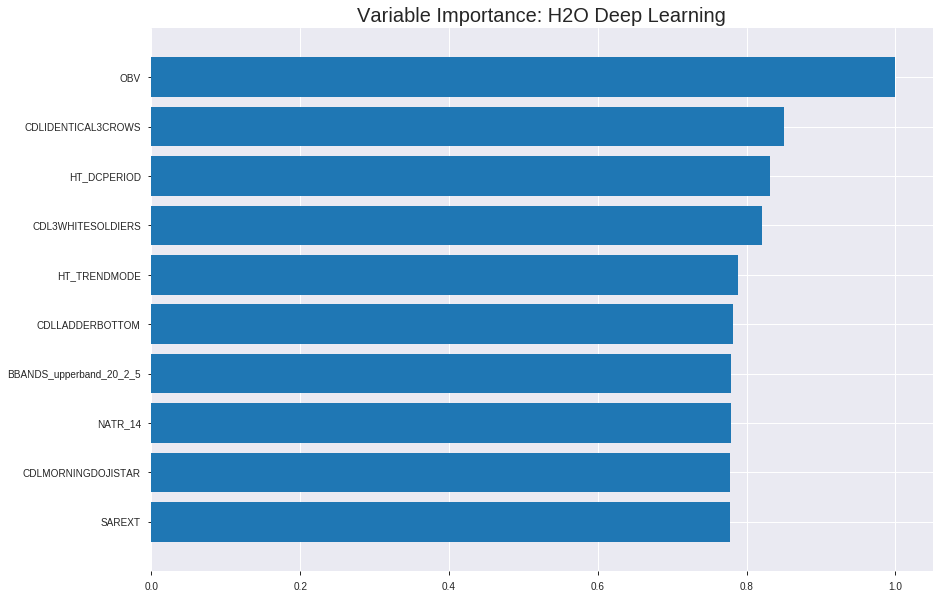

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190906_011758


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2528770843505924
RMSE: 0.5028688540271632
LogLoss: 0.7167107842196528
Mean Per-Class Error: 0.40685818169043775
AUC: 0.6209469191315956
pr_auc: 0.6100148320482256
Gini: 0.24189383826319122
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4384321253862004: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      108  554   0.8369   (554.0/662.0)
1      32   656   0.0465   (32.0/688.0)
Total  140  1210  0.4341   (586.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.438432     0.691254  318
max f2                       0.279029     0.843137  379
max f0point5                 0.545508     0.601177  249
max accuracy                 0.551168     0.592593  245
max precision                0.999997     1         0
max recall                   0.279029     1         379
max specificity              0.999997     1         0
max absolute_mcc             0.438432     0.19124   318
max min_per_class_accuracy   0.567149     0.590116  235
max mean_per_class_accuracy  0.609429     0.593142  207

Gains/Lift Table: Avg response rate: 50.96 %, avg score: 60.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.985187           1.96221   1.96221            1                0.996288  1                           0.996288            0.0203488       0.0203488                  96.2209   96.2209
    2        0.02                        0.948811           1.66033   1.81686            0.846154         0.963126  0.925926                    0.980321            0.0159884       0.0363372                  66.0331   81.686
    3        0.0303704                   0.937851           1.12126   1.57934            0.571429         0.942969  0.804878                    0.967567            0.0116279       0.0479651                  12.1262   57.9339
    4        0.04                        0.929602           0.905635  1.41715            0.461538         0.933473  0.722222                    0.959359            0.00872093      0.056686                   -9.43649  41.7151
    5        0.0503704                   0.91885            1.12126   1.35623            0.571429         0.924531  0.691176                    0.952189            0.0116279       0.068314                   12.1262   35.6233
    6        0.1                         0.877928           1.20075   1.27907            0.61194          0.89928   0.651852                    0.925931            0.059593        0.127907                   20.0755   27.907
    7        0.15037                     0.826667           1.12538   1.22759            0.573529         0.852431  0.625616                    0.90131             0.056686        0.184593                   12.5385   22.7589
    8        0.2                         0.783853           1.05432   1.18459            0.537313         0.804261  0.603704                    0.877227            0.0523256       0.236919                   5.43214   18.4593
    9        0.3                         0.703005           1.2936    1.22093            0.659259         0.744269  0.622222                    0.832908            0.12936         0.366279                   29.3605   22.093
    10       0.4                         0.63439            1.19186   1.21366            0.607407         0.668008  0.618519                    0.791683            0.119186        0.485465                   19.186    21.3663
    11       0.5                         0.567058           1.04651   1.18023            0.533333         0.599265  0.601481                    0.7532              0.104651        0.590116                   4.65116   18.0233
    12       0.6                         0.507055           0.915698  1.13614            0.466667         0.535683  0.579012                    0.716947            0.0915698       0.681686                   -8.43023  13.6143
    13       0.808889                    0.491057           0.925439  1.08173            0.471631         0.492334  0.551282                    0.658942            0.193314        0.875                      -7.45609  8.17308
    14       0.9                         0.432828           0.861458  1.05943            0.439024         0.466269  0.539918                    0.639437            0.0784884       0.953488                   -13.8542  5.94315
    15       1                           0.0134134          0.465116  1                  0.237037         0.338825  0.50963                     0.609376            0.0465116       1                          -53.4884  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.291475108972201
RMSE: 0.5398843477747813
LogLoss: 0.8396141165174613
Mean Per-Class Error: 0.4798804137039431
AUC: 0.4935089420383538
pr_auc: 0.47709025876382966
Gini: -0.012982115923292348
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3958176069064139: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    196  0.9608   (196.0/204.0)
1      2    180  0.011    (2.0/182.0)
Total  10   376  0.513    (198.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395818     0.645161  253
max f2                       0.350813     0.819082  260
max f0point5                 0.395818     0.533808  253
max accuracy                 0.941491     0.546632  12
max precision                1            1         0
max recall                   0.350813     1         260
max specificity              1            1         0
max absolute_mcc             0.941491     0.111346  12
max min_per_class_accuracy   0.545094     0.5       192
max mean_per_class_accuracy  0.941491     0.52012   12

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 61.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.988695           1.06044   1.06044            0.5              0.997768  0.5                         0.997768            0.010989        0.010989                   6.04396   6.04396
    2        0.0207254                   0.957531           2.12088   1.59066            1                0.973579  0.75                        0.985673            0.021978        0.032967                   112.088   59.0659
    3        0.0310881                   0.942721           1.59066   1.59066            0.75             0.948893  0.75                        0.973413            0.0164835       0.0494505                  59.0659   59.0659
    4        0.0414508                   0.938356           0.53022   1.32555            0.25             0.940213  0.625                       0.965113            0.00549451      0.0549451                  -46.978   32.5549
    5        0.0518135                   0.919334           0.53022   1.16648            0.25             0.929646  0.55                        0.95802             0.00549451      0.0604396                  -46.978   16.6484
    6        0.101036                    0.84482            0.893002  1.03325            0.421053         0.884622  0.487179                    0.922262            0.043956        0.104396                   -10.6998  3.32488
    7        0.150259                    0.808936           0.893002  0.987306           0.421053         0.826804  0.465517                    0.890991            0.043956        0.148352                   -10.6998  -1.26942
    8        0.202073                    0.782392           0.954396  0.978867           0.45             0.794369  0.461538                    0.866216            0.0494505       0.197802                   -4.56044  -2.11327
    9        0.300518                    0.68103            0.948814  0.969022           0.447368         0.732188  0.456897                    0.82231             0.0934066       0.291209                   -5.11857  -3.09776
    10       0.401554                    0.597381           1.19639   1.02623            0.564103         0.64258   0.483871                    0.777088            0.120879        0.412088                   19.6393   2.62318
    11       0.5                         0.544591           0.893002  1                  0.421053         0.570091  0.471503                    0.736332            0.0879121       0.5                        -10.6998  0
    12       0.601036                    0.498495           0.815723  0.969022           0.384615         0.523117  0.456897                    0.70049             0.0824176       0.582418                   -18.4277  -3.09776
    13       0.930052                    0.491057           1.06879   1.00432            0.503937         0.49123   0.473538                    0.626462            0.351648        0.934066                   6.87895   0.431602
    14       1                           0.297483           0.942613  1                  0.444444         0.40902   0.471503                    0.611252            0.0659341       1                          -5.73871  0


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:17:59  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 01:18:02  3.927 sec   1343 obs/sec      1         1             1350       0.599753         1.66698             -0.43935       0.541344        0.544119           1.82205          0.49037                          0.657949           2.63021               -0.737232        0.466306          0.448077             1.06044            0.523316
    2019-09-06 01:18:04  5.990 sec   4735 obs/sec      10        10            13500      0.502869         0.716711            -0.0118837     0.620947        0.610015           1.96221          0.434074                         0.539884           0.839614              -0.1697          0.493509          0.47709              1.06044            0.512953

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ----------------------
OBV                       1.0                    1.0                  0.001909848933262023
CDLIDENTICAL3CROWS        0.8505027890205383     0.8505027890205383   0.0016243318443472504
HT_DCPERIOD               0.8317725658416748     0.8317725658416748   0.0015885599475893384
CDL3WHITESOLDIERS         0.8201974034309387     0.8201974034309387   0.0015664531360068594
HT_TRENDMODE              0.7879595756530762     0.7879595756530762   0.0015048837550146238
---                       ---                    ---                  ---
BBANDS_middleband_12_3_3  0.27242815494537354    0.27242815494537354  0.0005202966211129628
MOM_14                    0.25353774428367615    0.25353774428367615  0.0004842187904618384
BBANDS_middleband_8_6_3   0.25344109535217285    0.25344109535217285  0.00048403420560310593
CDLGRAVESTONEDOJI         0.25332584977149963    0.25332584977149963  0.00048381410395379403
aroonup_12                0.19521886110305786    0.19521886110305786  0.00037283853363030207


See the whole table with table.as_data_frame()


('accuracy', 0.5803108808290155)

('F1', 0.6536964980544748)

('auc', 0.5711053652230124)

('logloss', 1.7575321372555657)

('mean_per_class_error', 0.4112798965740142)

('rmse', 0.6888532021189249)

('mse', 0.4745187340694964)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


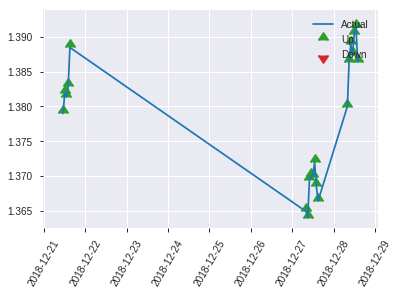


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.4745187340694964
RMSE: 0.6888532021189249
LogLoss: 1.7575321372555657
Mean Per-Class Error: 0.4112798965740142
AUC: 0.5711053652230124
pr_auc: 0.5105846150744844
Gini: 0.14221073044602472
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9155351158477555: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      20   82   0.8039   (82.0/102.0)
1      7    84   0.0769   (7.0/91.0)
Total  27   166  0.4611   (89.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.915535     0.653696  165
max f2                       0.771995     0.81982   190
max f0point5                 0.951877     0.570698  123
max accuracy                 0.954681     0.580311  117
max precision                0.996064     1         0
max recall                   0.771995     1         190
max specificity              0.996064     1         0
max absolute_mcc             0.951877     0.184815  123
max min_per_class_accuracy   0.966828     0.539216  96
max mean_per_class_accuracy  0.951877     0.58872   123

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 94.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.995072           1.06044   1.06044            0.5              0.995793  0.5                         0.995793            0.010989        0.010989                   6.04396   6.04396
    2        0.0207254                   0.994648           1.06044   1.06044            0.5              0.994954  0.5                         0.995374            0.010989        0.021978                   6.04396   6.04396
    3        0.0310881                   0.994473           2.12088   1.41392            1                0.994571  0.666667                    0.995106            0.021978        0.043956                   112.088   41.3919
    4        0.0414508                   0.994209           1.06044   1.32555            0.5              0.994404  0.625                       0.99493             0.010989        0.0549451                  6.04396   32.5549
    5        0.0518135                   0.993696           2.12088   1.48462            1                0.993942  0.7                         0.994733            0.021978        0.0769231                  112.088   48.4615
    6        0.103627                    0.991692           0.848352  1.16648            0.4              0.992839  0.55                        0.993786            0.043956        0.120879                   -15.1648  16.6484
    7        0.150259                    0.985982           0.471306  0.950739           0.222222         0.989761  0.448276                    0.992537            0.021978        0.142857                   -52.8694  -4.92611
    8        0.202073                    0.980839           0.848352  0.924486           0.4              0.982869  0.435897                    0.990058            0.043956        0.186813                   -15.1648  -7.55142
    9        0.300518                    0.975187           1.45113   1.09701            0.684211         0.978023  0.517241                    0.986115            0.142857        0.32967                    45.1128   9.70064
    10       0.398964                    0.971572           1.22788   1.1293             0.578947         0.973651  0.532468                    0.98304             0.120879        0.450549                   22.7877   12.9299
    11       0.502591                    0.966828           0.954396  1.09324            0.45             0.969046  0.515464                    0.980154            0.0989011       0.549451                   -4.56044  9.32367
    12       0.601036                    0.956249           1.3395    1.13357            0.631579         0.960282  0.534483                    0.976899            0.131868        0.681319                   33.9503   13.3573
    13       0.699482                    0.944909           0.781377  1.084              0.368421         0.95068   0.511111                    0.973209            0.0769231       0.758242                   -21.8623  8.40049
    14       0.797927                    0.933433           1.00463   1.07421            0.473684         0.939754  0.506494                    0.969082            0.0989011       0.857143                   0.462695  7.42115
    15       0.896373                    0.905572           0.893002  1.05431            0.421053         0.918482  0.49711                     0.963525            0.0879121       0.945055                   -10.6998  5.43099
    16       1                           0.756511           0.53022   1                  0.25             0.823572  0.471503                    0.949022       

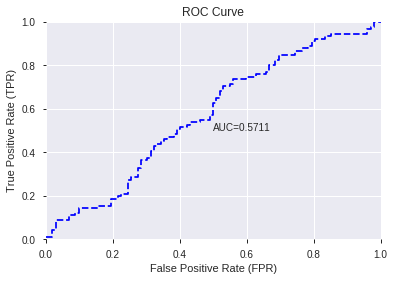

This function is available for GLM models only


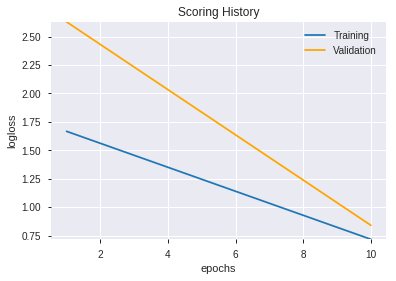

--2019-09-06 01:47:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.38.44
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.38.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  13.7MB/s    in 27s     

2019-09-06 01:48:10 (12.9 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unkno

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190906_011758',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190906_011758',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b1e5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_2_sid_b1e5',


In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_014823_model_9  0.549127  0.695420              0.476675  0.501135  0.251136
1               DeepLearning_1_AutoML_20190906_014823  0.545788  2.240623              0.480985  0.710229  0.504425
2  DeepLearning_grid_1_AutoML_20190906_014823_model_3  0.539108  0.966038              0.485294  0.578474  0.334632
3  DeepLearning_grid_1_AutoML_20190906_014823_model_1  0.538785  4.271286              0.429272  0.710379  0.504639
4  DeepLearning_grid_1_AutoML_20190906_014823_model_2  0.537007  2.565981              0.500000  0.682236  0.465446
5  DeepLearning_grid_1_AutoML_20190906_014823_model_5  0.535445  0.765180              0.490196  0.531726  0.282733
6  DeepLearning_grid_1_AutoML_20190906_014823_model_4  0.521008  1.489191              0.500000  0.659603  0.435076
7  DeepLearning_grid_1_AutoML_20190906_014823_model_7  0.511312  0.724879              0.495098  0.514313  0.264518
8  DeepLearning_grid_1_AutoML_20190906_014823_model_8  0.507326  0.700328              0.476675  0.503491  0.253503
9  DeepLearning_grid_1_AutoML_20190906_014823_model_6  0.502586  0.724275              0.500000  0.515111  0.265339

variable  relative_importance  scaled_importance  percentage
0                     Volume             1.000000           1.000000    0.022156
1               HT_TRENDMODE             0.988758           0.988758    0.021907
2            CDLHOMINGPIGEON             0.972513           0.972513    0.021547
3    BBANDS_upperband_20_3_5             0.960413           0.960413    0.021279
4                        OBV             0.953204           0.953204    0.021119
5                     SAREXT             0.952794           0.952794    0.021110
6         CDLIDENTICAL3CROWS             0.935881           0.935881    0.020736
7                   MAVP_8_0             0.933892           0.933892    0.020691
8    BBANDS_upperband_20_2_5             0.925554           0.925554    0.020507
9   BBANDS_middleband_14_5_5             0.925548           0.925548    0.020507
10    LINEARREG_INTERCEPT_30             0.925316           0.925316    0.020501
11                   ADXR_14             0.924286           0.924286    0.020479
12                   TRIX_14             0.923373           0.923373    0.020458
13    BBANDS_lowerband_8_0_5             0.919073           0.919073    0.020363
14        LINEARREG_SLOPE_20             0.917709           0.917709    0.020333
15                   NATR_14             0.911477           0.911477    0.020195
16         CDL3WHITESOLDIERS             0.910904           0.910904    0.020182
17                    TSF_12             0.910869           0.910869    0.020181
18                       BOP             0.909617           0.909617    0.020154
19  BBANDS_middleband_30_2_4             0.908523           0.908523    0.020129
20                  TYPPRICE             0.907839           0.907839    0.020114
21                 PLUS_DI_8             0.903443           0.903443    0.020017
22                 CDLTAKURI             0.903022           0.903022    0.020008
23            CDLMORNINGSTAR             0.901603           0.901603    0.019976
24        CDLCLOSINGMARUBOZU             0.901470           0.901470    0.019973
25   BBANDS_lowerband_14_6_5             0.896419           0.896419    0.019861
26        CDLEVENINGDOJISTAR             0.896215           0.896215    0.019857
27           CDLLADDERBOTTOM             0.895337           0.895337    0.019837
28                aroonup_30             0.894603           0.894603    0.019821
29        CDLMORNINGDOJISTAR             0.893642           0.893642    0.019800
30               AROONOSC_24             0.891530           0.891530    0.019753
31                PLUS_DI_14             0.889612           0.889612    0.019710
32                    MA_8_5             0.885053           0.885053    0.019609
33               CDLPIERCING             0.881679           0.881679    0.019535
34   BBANDS_upperband_12_1_3             0.880342           0.880342    0.019505
35            MACDEXT_signal             0.878959           0.878959    0.019474
36                        AD             0.877727           0.877727    0.019447
37                    MOM_24             0.875960           0.875960    0.019408
38                       PPO             0.874154           0.874154    0.019368
39                 CORREL_20             0.873140           0.873140    0.019345
40               CDLDOJISTAR             0.871133           0.871133    0.019301
41                    MAX_30             0.870506           0.870506    0.019287
42               HT_DCPERIOD             0.868876           0.868876    0.019251
43              is_month_end             0.867972           0.867972    0.019231
44               STOCH_slowk             0.867294           0.867294    0.019216
45                     ADOSC             0.864881           0.864881    0.019162
46            MACDFIX_hist_8             0.861354           0.861354    0.019084
47   BBANDS_lowerband_24_6_5             0.854541           0.854541    0.018933
48             MINMAX_min_24             0.853545  

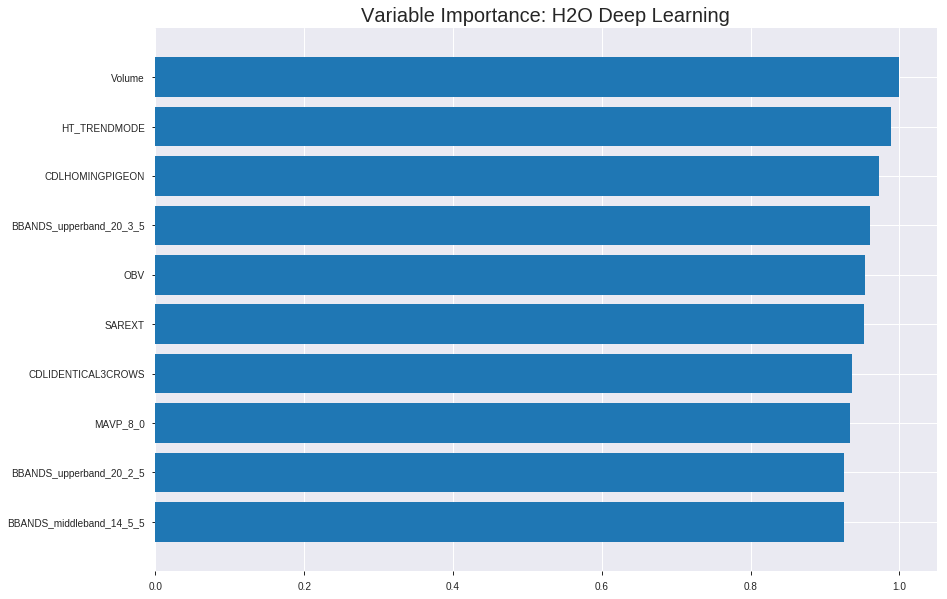

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_014823_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24949735607922102
RMSE: 0.4994971031740034
LogLoss: 0.6921422066017219
Mean Per-Class Error: 0.45047820206562217
AUC: 0.5554630963254409
pr_auc: 0.5411939016645488
Gini: 0.11092619265088177
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4998274604179546: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      16   646   0.9758   (646.0/662.0)
1      4    684   0.0058   (4.0/688.0)
Total  20   1330  0.4815   (650.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.499827     0.677899  386
max f2                       0.498903     0.840049  393
max f0point5                 0.505796     0.574485  302
max accuracy                 0.511681     0.548148  182
max precision                0.520816     0.585366  35
max recall                   0.498903     1         393
max specificity              0.556909     0.998489  0
max absolute_mcc             0.511681     0.100021  182
max min_per_class_accuracy   0.510708     0.543807  203
max mean_per_class_accuracy  0.511681     0.549522  182

Gains/Lift Table: Avg response rate: 50.96 %, avg score: 51.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.525291           0.981105  0.981105           0.5              0.540856  0.5                         0.540856            0.0101744       0.0101744                  -1.88953  -1.88953
    2        0.02                        0.5224             0.905635  0.944767           0.461538         0.523271  0.481481                    0.532389            0.00872093      0.0188953                  -9.43649  -5.52326
    3        0.0303704                   0.520781           1.54174   1.14861            0.785714         0.521503  0.585366                    0.528672            0.0159884       0.0348837                  54.1736   14.861
    4        0.04                        0.520017           0.452818  0.981105           0.230769         0.520377  0.5                         0.526675            0.00436047      0.0392442                  -54.7182  -1.88953
    5        0.0503704                   0.519502           1.40158   1.06767            0.714286         0.51975   0.544118                    0.525249            0.0145349       0.0537791                  40.1578   6.76727
    6        0.1                         0.517299           0.966461  1.01744            0.492537         0.51849   0.518519                    0.521895            0.0479651       0.101744                   -3.35387  1.74419
    7        0.15037                     0.51585            1.09653   1.04393            0.558824         0.51655   0.53202                     0.520104            0.0552326       0.156977                   9.65287   4.3934
    8        0.2                         0.514839           1.14218   1.06831            0.58209          0.515281  0.544444                    0.518907            0.056686        0.213663                   14.2182   6.8314
    9        0.3                         0.513282           1.16279   1.09981            0.592593         0.514047  0.560494                    0.517287            0.116279        0.329942                   16.2791   9.98062
    10       0.4                         0.512069           1.13372   1.10828            0.577778         0.512708  0.564815                    0.516142            0.113372        0.443314                   13.3721   10.8285
    11       0.5                         0.510704           1.00291   1.08721            0.511111         0.511397  0.554074                    0.515193            0.100291        0.543605                   0.290698  8.72093
    12       0.6                         0.509433           0.959302  1.06589            0.488889         0.510035  0.54321                     0.514334            0.0959302       0.639535                   -4.06977  6.58915
    13       0.7                         0.507883           1.00291   1.05689            0.511111         0.508699  0.538624                    0.513529            0.100291        0.739826                   0.290698  5.68937
    14       0.8                         0.505924           0.930233  1.04106            0.474074         0.506881  0.530556                    0.512698            0.0930233       0.832849                   -6.97674  4.1061
    15       0.9                         0.503824           0.857558  1.02067            0.437037         0.504935  0.520165                    0.511835            0.0857558       0.918605                   -14.2442  2.06718
    16       1                           0.496996           0.813953  1                  0.414815         0.501848  0.50963                     0.510836          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25061935193183665
RMSE: 0.5006189688094496
LogLoss: 0.694387315654243
Mean Per-Class Error: 0.44182288299935357
AUC: 0.5583252531781944
pr_auc: 0.5255544747684082
Gini: 0.11665050635638874
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.505791961650745: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      12   192  0.9412   (192.0/204.0)
1      2    180  0.011    (2.0/182.0)
Total  14   372  0.5026   (194.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.505792     0.649819  370
max f2                       0.504903     0.822042  377
max f0point5                 0.51063      0.544218  320
max accuracy                 0.517784     0.569948  111
max precision                0.524036     0.8       9
max recall                   0.504903     1         377
max specificity              0.561965     0.995098  0
max absolute_mcc             0.504903     0.128366  377
max min_per_class_accuracy   0.515303     0.538462  190
max mean_per_class_accuracy  0.517784     0.558177  111

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 51.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.529157           1.06044   1.06044            0.5              0.544036  0.5                         0.544036            0.010989        0.010989                   6.04396   6.04396
    2        0.0207254                   0.52428            2.12088   1.59066            1                0.525859  0.75                        0.534948            0.021978        0.032967                   112.088   59.0659
    3        0.0310881                   0.523629           1.59066   1.59066            0.75             0.524007  0.75                        0.531301            0.0164835       0.0494505                  59.0659   59.0659
    4        0.0414508                   0.522138           0.53022   1.32555            0.25             0.522667  0.625                       0.529142            0.00549451      0.0549451                  -46.978   32.5549
    5        0.0518135                   0.52178            1.06044   1.27253            0.5              0.521944  0.6                         0.527703            0.010989        0.0659341                  6.04396   27.2527
    6        0.101036                    0.520191           1.00463   1.14201            0.473684         0.520945  0.538462                    0.52441             0.0494505       0.115385                   0.462695  14.2012
    7        0.150259                    0.519124           1.45113   1.24327            0.684211         0.519524  0.586207                    0.52281             0.0714286       0.186813                   45.1128   24.3274
    8        0.202073                    0.518652           0.954396  1.1692             0.45             0.518896  0.551282                    0.521806            0.0494505       0.236264                   -4.56044  16.9203
    9        0.300518                    0.517651           1.22788   1.18842            0.578947         0.518132  0.560345                    0.520603            0.120879        0.357143                   22.7877   18.8424
    10       0.401554                    0.516467           0.815723  1.09465            0.384615         0.517104  0.516129                    0.519722            0.0824176       0.43956                    -18.4277  9.46473
    11       0.5                         0.515289           1.00463   1.07692            0.473684         0.515858  0.507772                    0.518961            0.0989011       0.538462                   0.462695  7.69231
    12       0.601036                    0.514263           1.08763   1.07872            0.512821         0.51481   0.508621                    0.518263            0.10989         0.648352                   8.76303   7.8723
    13       0.699482                    0.512865           0.669751  1.02116            0.315789         0.513624  0.481481                    0.517611            0.0659341       0.714286                   -33.0249  2.1164
    14       0.800518                    0.511372           1.08763   1.02955            0.512821         0.512027  0.485437                    0.516906            0.10989         0.824176                   8.76303   2.9553
    15       0.898964                    0.508196           1.06044   1.03294            0.5              0.509869  0.487032                    0.516135            0.104396        0.928571                   6.04396   3.29354
    16       1                           0.500827           0.70696   1                  0.333333         0.506002  0.471503                    0.515111            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:55:34  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 01:55:36  2 min 10.763 sec  502 obs/sec       0.918519  1             1240       0.534031         0.780779            -0.14118       0.537363        0.55067            1.96221          0.487407                         0.528866           0.77399               -0.122444        0.542232          0.519277             1.59066            0.528497
    2019-09-06 01:55:47  2 min 21.989 sec  776 obs/sec       7.25481   8             9794       0.499497         0.692142            0.00164027     0.555463        0.541194           0.981105         0.481481                         0.500619           0.694387              -0.00574448      0.558325          0.525554             1.06044            0.502591
    2019-09-06 01:55:59  2 min 33.689 sec  897 obs/sec       15.4156   17            20811      0.496108         0.685354            0.0151414      0.576085        0.578676           1.26142          0.483704                         0.504357           0.701965              -0.0208203       0.5007            0.460814             1.06044            0.502591
    2019-09-06 01:56:11  2 min 45.748 sec  965 obs/sec       24.4474   27            33004      0.492105         0.677281            0.0309724      0.602059        0.607401           1.40158          0.473333                         0.509787           0.713781              -0.0429181       0.512767          0.477216             1.06044            0.492228
    2019-09-06 01:56:22  2 min 57.104 sec  1016 obs/sec      33.4985   37            45223      0.491472         0.675778            0.0334607      0.618505        0.626629           1.54174          0.471111                         0.507231           0.708897              -0.032488        0.520604          0.49069              0.53022            0.507772
    2019-09-06 01:56:33  3 min  8.020 sec  1057 obs/sec      42.5326   47            57419      0.489121         0.67074             0.0426879      0.618688        0.633011           1.54174          0.473333                         0.516771           0.729604              -0.0716895       0.49429           0.478441             1.59066            0.502591
    2019-09-06 01:56:45  3 min 19.347 sec  1097 obs/sec      52.463    58            70825      0.489128         0.671118            0.0426594      0.65484         0.660033           1.82205          0.467407                         0.508879           0.711381              -0.0392082       0.526153          0.491384             1.06044            0.487047
    2019-09-06 01:56:46  3 min 20.454 sec  1097 obs/sec      52.463    58            70825      0.499497         0.692142            0.00164027     0.555463        0.541194           0.981105         0.481481                         0.500619           0.694387              -0.00574448      0.558325          0.525554             1.06044            0.502591

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
Volume                   1.0                    1.0                  0.022156204880317183
HT_TRENDMODE             0.9887582063674927     0.9887582063674927   0.021907129397373104
CDLHOMINGPIGEON          0.9725133776664734     0.9725133776664734   0.021547205644427664
BBANDS_upperband_20_3_5  0.9604127407073975     0.9604127407073975   0.021279101452780037
OBV                      0.9532036781311035     0.9532036781311035   0.021119375985344642
---                      ---                    ---                  ---
ADOSC                    0.864881157875061      0.864881157875061    0.0191624841310058
MACDFIX_hist_8           0.8613537549972534     0.8613537549972534   0.019084330270149677
BBANDS_lowerband_24_6_5  0.8545413613319397     0.8545413613319397   0.01893339348037561
MINMAX_min_24            0.8535445928573608     0.8535445928573608   0.0189113088738346
BBANDS_lowerband_14_3_3  0.8425271511077881     0.8425271511077881   0.018667204177174105


See the whole table with table.as_data_frame()


('accuracy', 0.5595854922279793)

('F1', 0.6472727272727273)

('auc', 0.5491273432449904)

('logloss', 0.6954199287192593)

('mean_per_class_error', 0.4341736694677871)

('rmse', 0.5011345083719883)

('mse', 0.2511357954812344)

deeplearning prediction progress: |███████████████████████████████████████| 100%


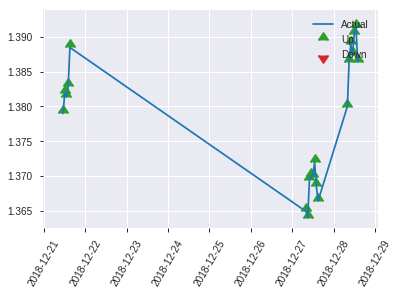


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2511357954812344
RMSE: 0.5011345083719883
LogLoss: 0.6954199287192593
Mean Per-Class Error: 0.4341736694677871
AUC: 0.5491273432449904
pr_auc: 0.5150458019422923
Gini: 0.0982546864899807
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5110485122589028: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      7    95   0.9314   (95.0/102.0)
1      2    89   0.022    (2.0/91.0)
Total  9    184  0.5026   (97.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.511049     0.647273  183
max f2                       0.508208     0.818345  191
max f0point5                 0.516238     0.55794   151
max accuracy                 0.529311     0.559585  7
max precision                0.529311     0.875     7
max recall                   0.508208     1         191
max specificity              0.543545     0.990196  0
max absolute_mcc             0.529311     0.168088  7
max min_per_class_accuracy   0.521034     0.538462  93
max mean_per_class_accuracy  0.516238     0.565826  151

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 52.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.534232           1.06044   1.06044            0.5              0.543427  0.5                         0.543427            0.010989        0.010989                   6.04396   6.04396
    2        0.0207254                   0.530072           2.12088   1.59066            1                0.531806  0.75                        0.537616            0.021978        0.032967                   112.088   59.0659
    3        0.0310881                   0.529592           2.12088   1.7674             1                0.529936  0.833333                    0.535056            0.021978        0.0549451                  112.088   76.7399
    4        0.0414508                   0.529304           2.12088   1.85577            1                0.529416  0.875                       0.533646            0.021978        0.0769231                  112.088   85.5769
    5        0.0518135                   0.52909            0         1.48462            0                0.529251  0.7                         0.532767            0               0.0769231                  -100      48.4615
    6        0.103627                    0.527707           0.424176  0.954396           0.2              0.528356  0.45                        0.530562            0.021978        0.0989011                  -57.5824  -4.56044
    7        0.150259                    0.526168           1.17827   1.02387            0.555556         0.526966  0.482759                    0.529446            0.0549451       0.153846                   17.8266   2.38727
    8        0.202073                    0.525392           1.06044   1.03325            0.5              0.525804  0.487179                    0.528512            0.0549451       0.208791                   6.04396   3.32488
    9        0.300518                    0.523573           1.22788   1.09701            0.578947         0.524455  0.517241                    0.527183            0.120879        0.32967                    22.7877   9.70064
    10       0.398964                    0.522098           1.22788   1.1293             0.578947         0.522693  0.532468                    0.526075            0.120879        0.450549                   22.7877   12.9299
    11       0.502591                    0.520731           0.848352  1.07137            0.4              0.521522  0.505155                    0.525136            0.0879121       0.538462                   -15.1648  7.13719
    12       0.601036                    0.519491           1.00463   1.06044            0.473684         0.519992  0.5                         0.524294            0.0989011       0.637363                   0.462695  6.04396
    13       0.699482                    0.517883           0.669751  1.00545            0.315789         0.518678  0.474074                    0.523503            0.0659341       0.703297                   -33.0249  0.545381
    14       0.797927                    0.516065           1.56275   1.07421            0.736842         0.517009  0.506494                    0.522702            0.153846        0.857143                   56.2753   7.42115
    15       0.896373                    0.512695           0.558126  1.01753            0.263158         0.514546  0.479769                    0.521806            0.0549451       0.912088                   -44.1874  1.75316
    16       1                           0.504774           0.848352  1                  0.4              0.510608  0.471503                    0.520646       

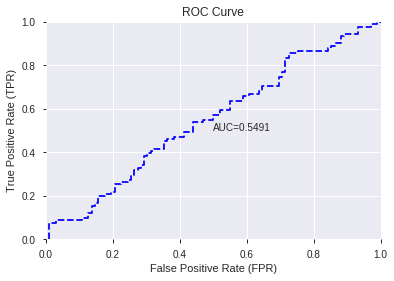

This function is available for GLM models only


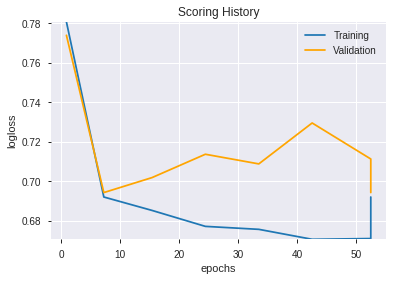

--2019-09-06 01:56:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_014823_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_014823_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b1e5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['Volume',
 'HT_TRENDMODE',
 'CDLHOMINGPIGEON',
 'BBANDS_upperband_20_3_5',
 'OBV',
 'SAREXT',
 'CDLIDENTICAL3CROWS',
 'MAVP_8_0',
 'BBANDS_upperband_20_2_5',
 'BBANDS_middleband_14_5_5',
 'LINEARREG_INTERCEPT_30',
 'ADXR_14',
 'TRIX_14',
 'BBANDS_lowerband_8_0_5',
 'LINEARREG_SLOPE_20',
 'NATR_14',
 'CDL3WHITESOLDIERS',
 'TSF_12',
 'BOP',
 'BBANDS_middleband_30_2_4',
 'TYPPRICE',
 'PLUS_DI_8',
 'CDLTAKURI',
 'CDLMORNINGSTAR',
 'CDLCLOSINGMARUBOZU',
 'BBANDS_lowerband_14_6_5',
 'CDLEVENINGDOJISTAR',
 'CDLLADDERBOTTOM',
 'aroonup_30',
 'CDLMORNINGDOJISTAR',
 'AROONOSC_24',
 'PLUS_DI_14',
 'MA_8_5',
 'CDLPIERCING',
 'BBANDS_upperband_12_1_3',
 'MACDEXT_signal',
 'AD',
 'MOM_24',
 'PPO',
 'CORREL_20',
 'CDLDOJISTAR',
 'MAX_30',
 'HT_DCPERIOD',
 'is_month_end',
 'STOCH_slowk',
 'ADOSC',
 'MACDFIX_hist_8',
 'BBANDS_lowerband_24_6_5',
 'MINMAX_min_24',
 'BBANDS_lowerband_14_3_3']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190906_015708_model_1  0.555915  0.699936              0.485294  0.503371  0.253383

variable  relative_importance  scaled_importance  percentage
0                     Volume             0.013973           1.000000    0.064277
1                        OBV             0.013653           0.977130    0.062807
2                  CDLTAKURI             0.012406           0.887849    0.057069
3                 PLUS_DI_14             0.011805           0.844860    0.054305
4                  PLUS_DI_8             0.010567           0.756249    0.048610
5                  CORREL_20             0.008191           0.586195    0.037679
6                    ADXR_14             0.007816           0.559397    0.035957
7         CDLEVENINGDOJISTAR             0.007721           0.552585    0.035519
8    BBANDS_upperband_20_2_5             0.007279           0.520936    0.033484
9    BBANDS_upperband_20_3_5             0.007278           0.520888    0.033481
10                   NATR_14             0.007255           0.519236    0.033375
11               CDLDOJISTAR             0.007129           0.510203    0.032794
12               HT_DCPERIOD             0.006832           0.488989    0.031431
13   BBANDS_upperband_12_1_3             0.005754           0.411830    0.026471
14        CDLIDENTICAL3CROWS             0.005716           0.409089    0.026295
15           CDLLADDERBOTTOM             0.005672           0.405926    0.026092
16         CDL3WHITESOLDIERS             0.005408           0.387044    0.024878
17                    SAREXT             0.004739           0.339176    0.021801
18              is_month_end             0.003979           0.284781    0.018305
19                    MAX_30             0.003779           0.270489    0.017386
20              HT_TRENDMODE             0.003566           0.255220    0.016405
21               AROONOSC_24             0.003527           0.252403    0.016224
22                       BOP             0.003507           0.250963    0.016131
23   BBANDS_lowerband_14_6_5             0.003356           0.240177    0.015438
24        CDLMORNINGDOJISTAR             0.003338           0.238877    0.015354
25   BBANDS_lowerband_24_6_5             0.003170           0.226873    0.014583
26                        AD             0.003127           0.223798    0.014385
27           CDLHOMINGPIGEON             0.002985           0.213642    0.013732
28        CDLCLOSINGMARUBOZU             0.002975           0.212909    0.013685
29    BBANDS_lowerband_8_0_5             0.002891           0.206935    0.013301
30                     ADOSC             0.002807           0.200857    0.012911
31    LINEARREG_INTERCEPT_30             0.002548           0.182375    0.011723
32                  MAVP_8_0             0.002317           0.165789    0.010656
33  BBANDS_middleband_30_2_4             0.002211           0.158224    0.010170
34                  TYPPRICE             0.002153           0.154057    0.009902
35  BBANDS_middleband_14_5_5             0.002117           0.151514    0.009739
36            CDLMORNINGSTAR             0.002053           0.146921    0.009444
37                    TSF_12             0.002030           0.145293    0.009339
38                    MA_8_5             0.001943           0.139022    0.008936
39   BBANDS_lowerband_14_3_3             0.001376           0.098499    0.006331
40            MACDFIX_hist_8             0.001191           0.085246    0.005479
41                   TRIX_14             0.001026           0.073446    0.004721
42                    MOM_24             0.000857           0.061323    0.003942
43             MINMAX_min_24             0.000787           0.056357    0.003622
44        LINEARREG_SLOPE_20             0.000739           0.052908    0.003401
45               STOCH_slowk             0.000653           0.046741    0.003004
46                aroonup_30             0.000515           0.036847    0.002368
47            MACDEXT_signal             0.000318           0.022756    0.001463
48                       PPO             0.000183  

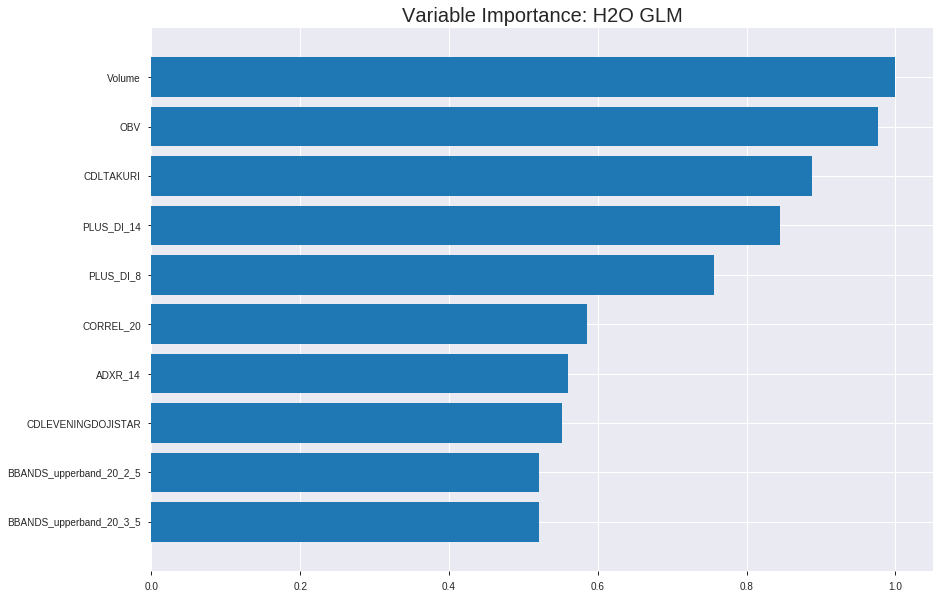

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_015708_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2480303870790983
RMSE: 0.4980264923466404
LogLoss: 0.6892021757980633
Null degrees of freedom: 1349
Residual degrees of freedom: 1299
Null deviance: 1870.9966158108023
Residual deviance: 1860.8458746547708
AIC: 1962.8458746547708
AUC: 0.5824426508817537
pr_auc: 0.5869078816080777
Gini: 0.16488530176350746
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4879866854529782: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      43   619   0.935    (619.0/662.0)
1      18   670   0.0262   (18.0/688.0)
Total  61   1289  0.4719   (637.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.487987     0.677795  360
max f2                       0.470936     0.839639  394
max f0point5                 0.500548     0.582983  275
max accuracy                 0.509735     0.560741  201
max precision                0.571943     1         0
max recall                   0.470936     1         394
max specificity              0.571943     1         0
max absolute_mcc             0.515581     0.132232  151
max min_per_class_accuracy   0.510211     0.555233  198
max mean_per_class_accuracy  0.515581     0.56245   151

Gains/Lift Table: Avg response rate: 50.96 %, avg score: 50.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.539095           1.54174   1.54174            0.785714         0.549828  0.785714                    0.549828            0.0159884       0.0159884                  54.1736   54.1736
    2        0.02                        0.534768           1.35845   1.45349            0.692308         0.535971  0.740741                    0.543156            0.0130814       0.0290698                  35.8453   45.3488
    3        0.0303704                   0.533171           1.12126   1.34005            0.571429         0.533867  0.682927                    0.539984            0.0116279       0.0406977                  12.1262   34.0045
    4        0.04                        0.532176           1.05657   1.2718             0.538462         0.532669  0.648148                    0.538223            0.0101744       0.0508721                  5.65742   27.1802
    5        0.0503704                   0.530824           1.26142   1.26966            0.642857         0.531473  0.647059                    0.536833            0.0130814       0.0639535                  26.142    26.9665
    6        0.1                         0.525597           1.34719   1.30814            0.686567         0.527964  0.666667                    0.532431            0.0668605       0.130814                   34.7188   30.814
    7        0.15037                     0.522126           1.15424   1.25659            0.588235         0.523879  0.640394                    0.529566            0.0581395       0.188953                   15.4241   25.6587
    8        0.2                         0.520273           1.14218   1.2282             0.58209          0.521207  0.625926                    0.527492            0.056686        0.24564                    14.2182   22.8198
    9        0.3                         0.516622           1.06105   1.17248            0.540741         0.518606  0.597531                    0.52453             0.106105        0.351744                   6.10465   17.2481
    10       0.4                         0.513446           0.959302  1.11919            0.488889         0.515066  0.57037                     0.522164            0.0959302       0.447674                   -4.06977  11.9186
    11       0.5                         0.51007            1.09012   1.11337            0.555556         0.511805  0.567407                    0.520092            0.109012        0.556686                   9.01163   11.3372
    12       0.6                         0.507073           0.915698  1.08043            0.466667         0.508629  0.550617                    0.518182            0.0915698       0.648256                   -8.43023  8.04264
    13       0.7                         0.502853           1.03198   1.0735             0.525926         0.505038  0.54709                     0.516304            0.103198        0.751453                   3.19767   7.3505
    14       0.8                         0.498247           0.930233  1.0556             0.474074         0.500644  0.537963                    0.514347            0.0930233       0.844477                   -6.97674  5.55959
    15       0.9                         0.492384           0.799419  1.02713            0.407407         0.495355  0.523457                    0.512236            0.0799419       0.924419                   -20.0581  2.71318
    16       1                           0.430947           0.755814  1                  0.385185         0.486168  0.50963                     0.50963            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25049515695103736
RMSE: 0.5004949120131366
LogLoss: 0.6941382973670179
Null degrees of freedom: 385
Residual degrees of freedom: 335
Null deviance: 536.100336915834
Residual deviance: 535.8747655673378
AIC: 637.8747655673378
AUC: 0.5159179056237879
pr_auc: 0.48512581258086573
Gini: 0.03183581124757584
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4948107605922923: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      25   179  0.8775   (179.0/204.0)
1      5    177  0.0275   (5.0/182.0)
Total  30   356  0.4767   (184.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494811     0.657993  355
max f2                       0.487162     0.819082  382
max f0point5                 0.495487     0.553097  349
max accuracy                 0.53442      0.541451  12
max precision                0.551832     1         0
max recall                   0.487162     1         382
max specificity              0.551832     1         0
max absolute_mcc             0.495487     0.178002  349
max min_per_class_accuracy   0.50959      0.504902  192
max mean_per_class_accuracy  0.495487     0.551848  349

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 51.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.540701           1.59066   1.59066            0.75             0.546016  0.75                        0.546016            0.0164835       0.0164835                  59.0659   59.0659
    2        0.0207254                   0.536947           1.06044   1.32555            0.5              0.539038  0.625                       0.542527            0.010989        0.0274725                  6.04396   32.5549
    3        0.0310881                   0.534769           1.59066   1.41392            0.75             0.536032  0.666667                    0.540362            0.0164835       0.043956                   59.0659   41.3919
    4        0.0414508                   0.533472           0.53022   1.19299            0.25             0.533873  0.5625                      0.53874             0.00549451      0.0494505                  -46.978   19.2995
    5        0.0518135                   0.53218            1.06044   1.16648            0.5              0.532853  0.55                        0.537562            0.010989        0.0604396                  6.04396   16.6484
    6        0.101036                    0.52927            1.11625   1.14201            0.526316         0.530324  0.538462                    0.534036            0.0549451       0.115385                   11.6252   14.2012
    7        0.150259                    0.52765            0.669751  0.987306           0.315789         0.528591  0.465517                    0.532252            0.032967        0.148352                   -33.0249  -1.26942
    8        0.202073                    0.52553            0.848352  0.951677           0.4              0.526483  0.448718                    0.530773            0.043956        0.192308                   -15.1648  -4.83235
    9        0.300518                    0.520291           0.948814  0.950739           0.447368         0.522935  0.448276                    0.528205            0.0934066       0.285714                   -5.11857  -4.92611
    10       0.401554                    0.514414           0.978867  0.957816           0.461538         0.517404  0.451613                    0.525488            0.0989011       0.384615                   -2.11327  -4.21836
    11       0.5                         0.509513           1.22788   1.01099            0.578947         0.511632  0.476684                    0.52276             0.120879        0.505495                   22.7877   1.0989
    12       0.601036                    0.505731           1.03325   1.01473            0.487179         0.507864  0.478448                    0.520256            0.104396        0.60989                    3.32488   1.4731
    13       0.699482                    0.502542           1.11625   1.02902            0.526316         0.504278  0.485185                    0.518007            0.10989         0.71978                    11.6252   2.90191
    14       0.800518                    0.499392           1.03325   1.02955            0.487179         0.500904  0.485437                    0.515848            0.104396        0.824176                   3.32488   2.9553
    15       0.898964                    0.495724           1.28369   1.05738            0.605263         0.497525  0.498559                    0.513842            0.126374        0.950549                   28.369    5.73835
    16       1                           0.464398           0.489434  1                  0.230769         0.491115  0.471503                    0.511545        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 01:57:09  0.000 sec   2            3.5       51            1.38078           1.38833
    2019-09-06 01:57:09  0.025 sec   4            2.2       51            1.3784            1.38828
    2019-09-06 01:57:09  0.051 sec   6            1.3       51            1.3753            1.38844
    2019-09-06 01:57:09  0.076 sec   8            0.84      51            1.37153           1.3891
    2019-09-06 01:57:09  0.099 sec   10           0.52      51            1.36729           1.39062
    2019-09-06 01:57:09  0.122 sec   12           0.32      51            1.36289           1.39328
    2019-09-06 01:57:09  0.151 sec   14           0.2       51            1.35865           1.39701

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5854922279792746)

('F1', 0.6476868327402135)

('auc', 0.5559146735617324)

('logloss', 0.6999357101501577)

('mean_per_class_error', 0.40578539107950873)

('rmse', 0.5033714764493809)

('mse', 0.25338284330282956)

glm prediction progress: |████████████████████████████████████████████████| 100%


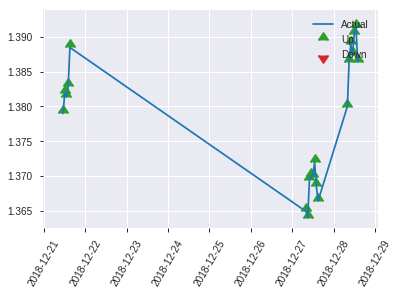


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25338284330282956
RMSE: 0.5033714764493809
LogLoss: 0.6999357101501577
Null degrees of freedom: 192
Residual degrees of freedom: 142
Null deviance: 268.05016845791704
Residual deviance: 270.17518411796084
AIC: 372.17518411796084
AUC: 0.5559146735617324
pr_auc: 0.5012590386858857
Gini: 0.11182934712346482
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5181771268344381: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      3    99   0.9706   (99.0/102.0)
1      0    91   0        (0.0/91.0)
Total  3    190  0.513    (99.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.518177     0.647687  189
max f2                       0.518177     0.8213    189
max f0point5                 0.540597     0.575296  124
max accuracy                 0.540597     0.585492  124
max precision                0.56317      0.714286  6
max recall                   0.518177     1         189
max specificity              0.580389     0.990196  0
max absolute_mcc             0.540597     0.196906  124
max min_per_class_accuracy   0.547173     0.549451  93
max mean_per_class_accuracy  0.540597     0.594215  124

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 54.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.572996           1.06044   1.06044            0.5              0.579008  0.5                         0.579008            0.010989        0.010989                   6.04396   6.04396
    2        0.0207254                   0.566327           1.06044   1.06044            0.5              0.569848  0.5                         0.574428            0.010989        0.021978                   6.04396   6.04396
    3        0.0310881                   0.563556           2.12088   1.41392            1                0.565479  0.666667                    0.571445            0.021978        0.043956                   112.088   41.3919
    4        0.0414508                   0.56187            1.06044   1.32555            0.5              0.562968  0.625                       0.569326            0.010989        0.0549451                  6.04396   32.5549
    5        0.0518135                   0.561065           1.06044   1.27253            0.5              0.561268  0.6                         0.567714            0.010989        0.0659341                  6.04396   27.2527
    6        0.103627                    0.559074           0.848352  1.06044            0.4              0.559981  0.5                         0.563848            0.043956        0.10989                    -15.1648  6.04396
    7        0.150259                    0.557239           0.471306  0.877605           0.222222         0.55812   0.413793                    0.56207             0.021978        0.131868                   -52.8694  -12.2395
    8        0.202073                    0.555979           0.636264  0.815723           0.3              0.556713  0.384615                    0.560697            0.032967        0.164835                   -36.3736  -18.4277
    9        0.300518                    0.55238            1.22788   0.950739           0.578947         0.554188  0.448276                    0.558564            0.120879        0.285714                   22.7877   -4.92611
    10       0.398964                    0.549866           1.67438   1.1293             0.789474         0.551568  0.532468                    0.556838            0.164835        0.450549                   67.4378   12.9299
    11       0.502591                    0.546336           1.06044   1.1151             0.5              0.548284  0.525773                    0.555074            0.10989         0.56044                    6.04396   11.5101
    12       0.601036                    0.541841           1.22788   1.13357            0.578947         0.544184  0.534483                    0.553291            0.120879        0.681319                   22.7877   13.3573
    13       0.699482                    0.538416           0.893002  1.09972            0.421053         0.540224  0.518519                    0.551452            0.0879121       0.769231                   -10.6998  9.97151
    14       0.797927                    0.534813           0.446501  1.01912            0.210526         0.536681  0.480519                    0.549629            0.043956        0.813187                   -55.3499  1.91237
    15       0.896373                    0.529745           1.22788   1.04205            0.578947         0.532912  0.491329                    0.547793            0.120879        0.934066                   22.7877   4.20504
    16       1                           0.506014           0.636264  1                  0.3              0.522884  0.471503                    0.545212      

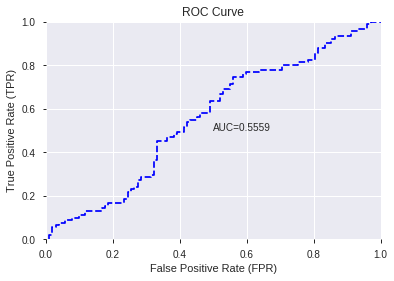

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


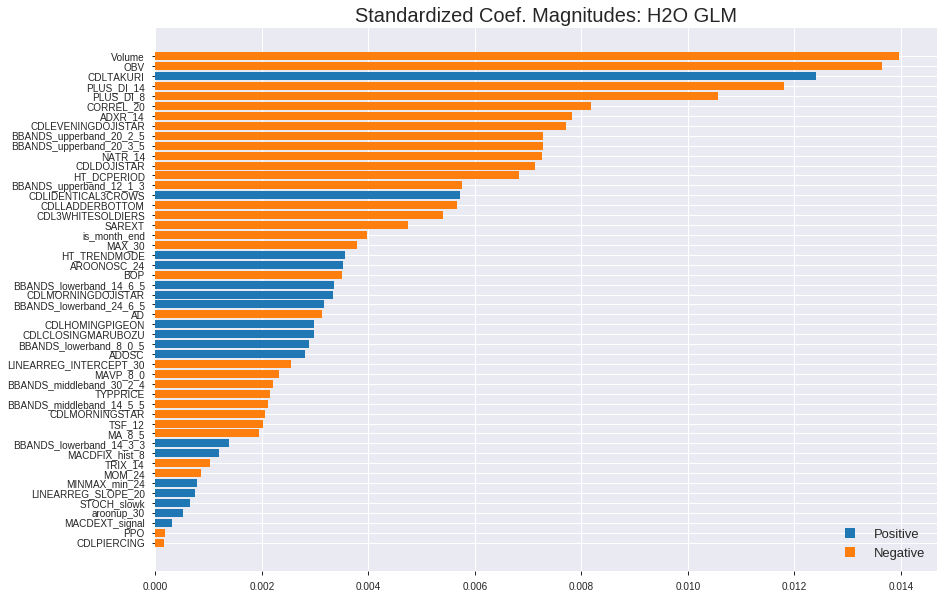

'log_likelihood'
--2019-09-06 01:57:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_015708_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_015708_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b1e5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['Volume',
 'OBV',
 'CDLTAKURI',
 'PLUS_DI_14',
 'PLUS_DI_8',
 'CORREL_20',
 'ADXR_14',
 'CDLEVENINGDOJISTAR',
 'BBANDS_upperband_20_2_5',
 'BBANDS_upperband_20_3_5',
 'NATR_14',
 'CDLDOJISTAR',
 'HT_DCPERIOD',
 'BBANDS_upperband_12_1_3',
 'CDLIDENTICAL3CROWS',
 'CDLLADDERBOTTOM',
 'CDL3WHITESOLDIERS',
 'SAREXT',
 'is_month_end',
 'MAX_30',
 'HT_TRENDMODE',
 'AROONOSC_24',
 'BOP',
 'BBANDS_lowerband_14_6_5',
 'CDLMORNINGDOJISTAR',
 'BBANDS_lowerband_24_6_5',
 'AD',
 'CDLHOMINGPIGEON',
 'CDLCLOSINGMARUBOZU',
 'BBANDS_lowerband_8_0_5',
 'ADOSC',
 'LINEARREG_INTERCEPT_30',
 'MAVP_8_0',
 'BBANDS_middleband_30_2_4',
 'TYPPRICE',
 'BBANDS_middleband_14_5_5',
 'CDLMORNINGSTAR',
 'TSF_12',
 'MA_8_5',
 'BBANDS_lowerband_14_3_3',
 'MACDFIX_hist_8',
 'TRIX_14',
 'MOM_24',
 'MINMAX_min_24',
 'LINEARREG_SLOPE_20',
 'STOCH_slowk',
 'aroonup_30',
 'MACDEXT_signal',
 'PPO',
 'CDLPIERCING']

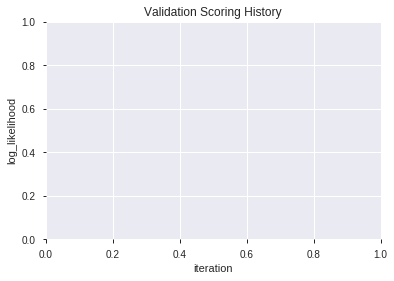

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_015729_model_7  0.536953  0.726415              0.485294  0.515219  0.265451
1               XGBoost_1_AutoML_20190906_015729  0.511528  0.709651              0.490789  0.507938  0.258001
2  XGBoost_grid_1_AutoML_20190906_015729_model_6  0.490196  0.733921              0.495098  0.518457  0.268797
3  XGBoost_grid_1_AutoML_20190906_015729_model_2  0.486964  0.701667              0.485887  0.504206  0.254224
4  XGBoost_grid_1_AutoML_20190906_015729_model_1  0.484702  0.720905              0.495098  0.513330  0.263507
5  XGBoost_grid_1_AutoML_20190906_015729_model_4  0.482439  0.736801              0.500000  0.520642  0.271068
6               XGBoost_3_AutoML_20190906_015729  0.469403  0.719544              0.495098  0.512549  0.262706
7               XGBoost_2_AutoML_20190906_015729  0.466117  0.749538              0.500000  0.526306  0.276998
8  XGBoost_grid_1_AutoML_20190906_015729_model_5  0.450011  0.743461              0.500000  0.523036  0.273566
9  XGBoost_grid_1_AutoML_20190906_015729_model_3  0.441284  0.734641              0.461377  0.519460  0.269839

variable  relative_importance  scaled_importance  percentage
0                     Volume           382.893921           1.000000    0.063242
1                        OBV           359.829224           0.939762    0.059432
2                        BOP           312.849243           0.817065    0.051673
3                      ADOSC           267.815094           0.699450    0.044235
4                STOCH_slowk           261.053253           0.681790    0.043118
5                    NATR_14           255.146637           0.666364    0.042142
6                        PPO           219.562897           0.573430    0.036265
7                     MOM_24           215.699753           0.563341    0.035627
8                  CORREL_20           212.709274           0.555531    0.035133
9             MACDFIX_hist_8           212.032333           0.553763    0.035021
10               HT_DCPERIOD           197.790558           0.516568    0.032669
11                   TRIX_14           195.350296           0.510194    0.032266
12                 PLUS_DI_8           195.068436           0.509458    0.032219
13                   ADXR_14           184.198593           0.481070    0.030424
14                PLUS_DI_14           176.379517           0.460649    0.029132
15                    SAREXT           175.562805           0.458516    0.028997
16   BBANDS_lowerband_14_6_5           160.824799           0.420024    0.026563
17        LINEARREG_SLOPE_20           158.043045           0.412759    0.026104
18            MACDEXT_signal           155.630692           0.406459    0.025705
19                        AD           150.140671           0.392121    0.024799
20   BBANDS_upperband_12_1_3           149.019852           0.389194    0.024613
21  BBANDS_middleband_14_5_5           112.406578           0.293571    0.018566
22   BBANDS_upperband_20_3_5           110.756126           0.289261    0.018293
23                    MAX_30           109.289627           0.285431    0.018051
24    BBANDS_lowerband_8_0_5           108.067169           0.282238    0.017849
25   BBANDS_upperband_20_2_5           102.932983           0.268829    0.017001
26    LINEARREG_INTERCEPT_30            98.255981           0.256614    0.016229
27                aroonup_30            95.300720           0.248896    0.015741
28   BBANDS_lowerband_24_6_5            94.602356           0.247072    0.015625
29               AROONOSC_24            94.260895           0.246180    0.015569
30                    TSF_12            89.991768           0.235031    0.014864
31  BBANDS_middleband_30_2_4            85.226608           0.222585    0.014077
32                  TYPPRICE            81.825661           0.213703    0.013515
33             MINMAX_min_24            79.821709           0.208470    0.013184
34                    MA_8_5            73.045143           0.190771    0.012065
35   BBANDS_lowerband_14_3_3            49.833912           0.130151    0.008231
36                  MAVP_8_0            34.866875           0.091061    0.005759
37              HT_TRENDMODE            26.359585           0.068843    0.004354
38        CDLCLOSINGMARUBOZU             9.979257           0.026063    0.001648

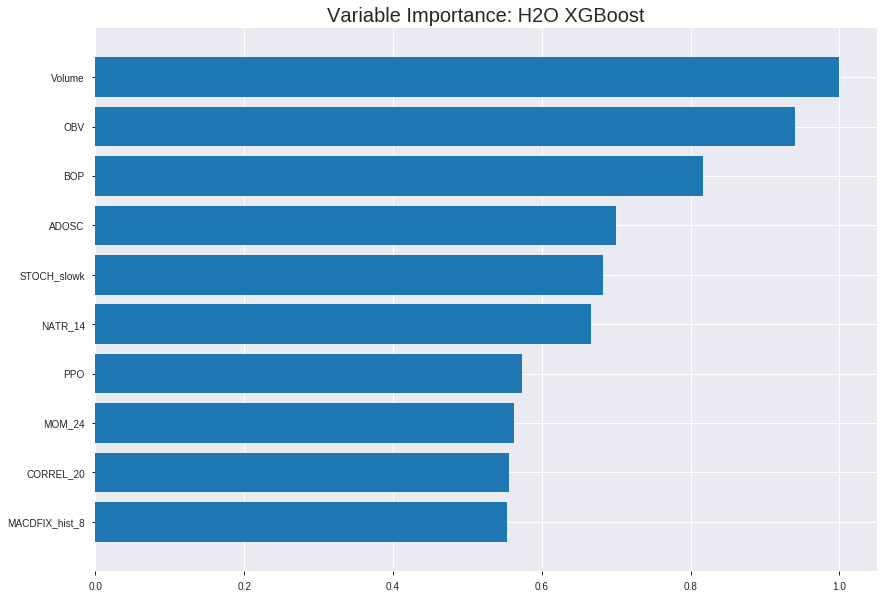

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_015729_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1573536568279844
RMSE: 0.39667827874485945
LogLoss: 0.49901844393540906
Mean Per-Class Error: 0.11072419728799265
AUC: 0.9508305961497928
pr_auc: 0.9529711324775295
Gini: 0.9016611922995856
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5239497423171997: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      602  60   0.0906   (60.0/662.0)
1      90   598  0.1308   (90.0/688.0)
Total  692  658  0.1111   (150.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.52395      0.888559  190
max f2                       0.446315     0.914516  242
max f0point5                 0.53432      0.904088  181
max accuracy                 0.52395      0.888889  190
max precision                0.856144     1         0
max recall                   0.28895      1         349
max specificity              0.856144     1         0
max absolute_mcc             0.52395      0.778654  190
max min_per_class_accuracy   0.510678     0.883686  197
max mean_per_class_accuracy  0.52395      0.889276  190

Gains/Lift Table: Avg response rate: 50.96 %, avg score: 50.85 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.792472           1.96221    1.96221            1                0.813644  1                           0.813644            0.0203488       0.0203488                  96.2209   96.2209
    2        0.02                        0.775437           1.96221    1.96221            1                0.784935  1                           0.799821            0.0188953       0.0392442                  96.2209   96.2209
    3        0.0303704                   0.757564           1.96221    1.96221            1                0.767954  1                           0.78894             0.0203488       0.059593                   96.2209   96.2209
    4        0.04                        0.747678           1.96221    1.96221            1                0.752538  1                           0.780177            0.0188953       0.0784884                  96.2209   96.2209
    5        0.0503704                   0.736337           1.96221    1.96221            1                0.744117  1                           0.772753            0.0203488       0.0988372                  96.2209   96.2209
    6        0.1                         0.701981           1.96221    1.96221            1                0.717263  1                           0.745213            0.0973837       0.196221                   96.2209   96.2209
    7        0.15037                     0.675502           1.93335    1.95254            0.985294         0.688566  0.995074                    0.726238            0.0973837       0.293605                   93.3353   95.2543
    8        0.2                         0.653306           1.90364    1.94041            0.970149         0.664047  0.988889                    0.710805            0.0944767       0.388081                   90.3636   94.0407
    9        0.3                         0.607966           1.875      1.9186             0.955556         0.631187  0.977778                    0.684266            0.1875          0.575581                   87.5      91.8605
    10       0.4                         0.561293           1.68605    1.86047            0.859259         0.585015  0.948148                    0.659453            0.168605        0.744186                   68.6047   86.0465
    11       0.5                         0.513353           1.32267    1.75291            0.674074         0.539432  0.893333                    0.635449            0.132267        0.876453                   32.2674   75.2907
    12       0.6                         0.46669            0.639535   1.56734            0.325926         0.490226  0.798765                    0.611245            0.0639535       0.940407                   -36.0465  56.7345
    13       0.7                         0.410043           0.377907   1.39743            0.192593         0.435532  0.712169                    0.586143            0.0377907       0.978198                   -62.2093  39.7425
    14       0.8                         0.363099           0.188953   1.24637            0.0962963        0.386422  0.635185                    0.561178            0.0188953       0.997093                   -81.1047  24.6366
    15       0.9                         0.306356           0.0145349  1.1095             0.00740741       0.337061  0.565432                    0.536276            0.00145349      0.998547                   -98.5465  10.9496
    16       1                           0.137093           0.0145349  1                  0.00740741       0.258612  0.50963                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26345010748037356
RMSE: 0.5132739107731598
LogLoss: 0.7224162848434762
Mean Per-Class Error: 0.47115384615384615
AUC: 0.5150290885585004
pr_auc: 0.4739109223024108
Gini: 0.03005817711700076
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2779306173324585: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    202  0.9902   (202.0/204.0)
1      0    182  0        (0.0/182.0)
Total  2    384  0.5233   (202.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.277931     0.64311    383
max f2                       0.277931     0.818345   383
max f0point5                 0.314684     0.531287   377
max accuracy                 0.614321     0.541451   106
max precision                0.614321     0.523364   106
max recall                   0.277931     1          383
max specificity              0.796345     0.995098   0
max absolute_mcc             0.750784     0.0835953  2
max min_per_class_accuracy   0.537844     0.5        191
max mean_per_class_accuracy  0.614321     0.528846   106

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 53.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.747768           0.53022   0.53022            0.25             0.770686  0.25                        0.770686            0.00549451      0.00549451                 -46.978   -46.978
    2        0.0207254                   0.737585           1.59066   1.06044            0.75             0.744469  0.5                         0.757578            0.0164835       0.021978                   59.0659   6.04396
    3        0.0310881                   0.72826            0         0.70696            0                0.732112  0.333333                    0.749089            0               0.021978                   -100      -29.304
    4        0.0414508                   0.725047           0.53022   0.662775           0.25             0.725951  0.3125                      0.743305            0.00549451      0.0274725                  -46.978   -33.7225
    5        0.0518135                   0.711189           1.06044   0.742308           0.5              0.720153  0.35                        0.738674            0.010989        0.0384615                  6.04396   -25.7692
    6        0.101036                    0.688488           1.45113   1.08763            0.684211         0.699267  0.512821                    0.719476            0.0714286       0.10989                    45.1128   8.76303
    7        0.150259                    0.664313           0.893002  1.02387            0.421053         0.67672   0.482759                    0.70547             0.043956        0.153846                   -10.6998  2.38727
    8        0.202073                    0.638282           1.27253   1.08763            0.6              0.649394  0.512821                    0.691091            0.0659341       0.21978                    27.2527   8.76303
    9        0.300518                    0.606312           1.06044   1.07872            0.5              0.622522  0.508621                    0.668629            0.104396        0.324176                   6.04396   7.8723
    10       0.401554                    0.569364           0.761341  0.998866           0.358974         0.586108  0.470968                    0.647866            0.0769231       0.401099                   -23.8659  -0.113435
    11       0.5                         0.536886           1.00463   1                  0.473684         0.553845  0.471503                    0.629354            0.0989011       0.5                        0.462695  0
    12       0.601036                    0.505919           1.19639   1.03301            0.564103         0.523577  0.487069                    0.611572            0.120879        0.620879                   19.6393   3.30144
    13       0.699482                    0.465003           0.893002  1.01331            0.421053         0.48291   0.477778                    0.593464            0.0879121       0.708791                   -10.6998  1.33089
    14       0.800518                    0.423489           0.978867  1.00896            0.461538         0.446303  0.475728                    0.57489             0.0989011       0.807692                   -2.11327  0.896191
    15       0.898964                    0.3798             1.06044   1.0146             0.5              0.403008  0.478386                    0.556068            0.104396        0.912088                   6.04396   1.45992
    16       1                           0.269845           0.870104  1                  0.410256         0.336773  0.471503                    0.533911           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:57:46  5.716 sec   0                  0.5              0.693147            0.5             0                  1                0.49037                          0.5                0.693147              0.5               0                    1                  0.528497
    2019-09-06 01:57:46  5.780 sec   5                  0.485044         0.663594            0.791022        0.78009            1.70058          0.308889                         0.499628           0.69241               0.533371          0.472347             1.06044            0.497409
    2019-09-06 01:57:46  5.825 sec   10                 0.47179          0.637882            0.835627        0.835509           1.96221          0.237037                         0.500567           0.694323              0.525089          0.480648             1.27253            0.512953
    2019-09-06 01:57:47  5.869 sec   15                 0.460592         0.61643             0.866951        0.864439           1.96221          0.206667                         0.502921           0.699146              0.509063          0.466154             1.06044            0.523316
    2019-09-06 01:57:47  5.917 sec   20                 0.448913         0.594336            0.887596        0.890131           1.96221          0.188148                         0.504647           0.702854              0.510248          0.463693             0.53022            0.502591
    2019-09-06 01:57:47  5.962 sec   25                 0.440125         0.577825            0.901982        0.904956           1.96221          0.174815                         0.508359           0.710746              0.505629          0.462307             0.53022            0.510363
    2019-09-06 01:57:47  6.020 sec   30                 0.430066         0.55924             0.915748        0.918664           1.96221          0.168148                         0.508267           0.710651              0.514194          0.475164             0                  0.520725
    2019-09-06 01:57:47  6.088 sec   35                 0.420697         0.541974            0.923672        0.927868           1.96221          0.154815                         0.51134            0.717584              0.516457          0.476383             0.53022            0.515544
    2019-09-06 01:57:47  6.140 sec   40                 0.413273         0.528377            0.931752        0.935359           1.96221          0.156296                         0.509844           0.71445               0.524025          0.4816               0.53022            0.520725
    2019-09-06 01:57:47  6.200 sec   45                 0.404722         0.513229            0.942794        0.945474           1.96221          0.128889                         0.512507           0.720658              0.518961          0.473974             0.53022            0.512953
    2019-09-06 01:57:47  6.250 sec   50                 0.396678         0.499018            0.950831        0.952971           1.96221          0.111111                         0.513274           0.722416              0.515029          0.473911             0.53022            0.523316

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  --------------------
Volume                   382.8939208984375      1.0                   0.06324200795035975
OBV                      359.8292236328125      0.9397621743079517    0.05943244689903085
BOP                      312.8492431640625      0.8170650566349568    0.05167283480766908
ADOSC                    267.8150939941406      0.6994498459670727    0.044234612719527514
STOCH_slowk              261.0532531738281      0.6817900178756623    0.04311776973096855
---                      ---                    ---                   ---
MA_8_5                   73.0451431274414       0.19077122707000774   0.012064755459061315
BBANDS_lowerband_14_3_3  49.83391189575195      0.13015070016995747   0.00823099161489334
MAVP_8_0                 34.86687469482422      0.09106144754926168   0.005758908789881675
HT_TRENDMODE             26.35958480834961      0.0688430486086027    0.004353772627432254
CDLCLOSINGMARUBOZU       9.979256629943848      0.026062718902739757  0.001648258676055059


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5492227979274611)

('F1', 0.6476868327402135)

('auc', 0.5369532428355958)

('logloss', 0.7264151671298708)

('mean_per_class_error', 0.44246929541047186)

('rmse', 0.5152189344301601)

('mse', 0.2654505503953496)

xgboost prediction progress: |████████████████████████████████████████████| 100%


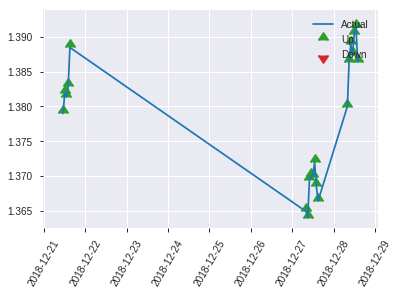


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2654505503953496
RMSE: 0.5152189344301601
LogLoss: 0.7264151671298708
Mean Per-Class Error: 0.44246929541047186
AUC: 0.5369532428355958
pr_auc: 0.47788754601360633
Gini: 0.07390648567119151
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.400959849357605: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      3    99   0.9706   (99.0/102.0)
1      0    91   0        (0.0/91.0)
Total  3    190  0.513    (99.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.40096      0.647687  189
max f2                       0.40096      0.8213    189
max f0point5                 0.533615     0.552448  155
max accuracy                 0.563865     0.549223  123
max precision                0.777653     1         0
max recall                   0.40096      1         189
max specificity              0.777653     1         0
max absolute_mcc             0.533615     0.143588  155
max min_per_class_accuracy   0.589963     0.527473  95
max mean_per_class_accuracy  0.563865     0.557531  123

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 59.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.758191           1.06044   1.06044            0.5              0.772309  0.5                         0.772309            0.010989        0.010989                   6.04396   6.04396
    2        0.0207254                   0.735091           0         0.53022            0                0.754143  0.25                        0.763226            0               0.010989                   -100      -46.978
    3        0.0310881                   0.72075            0         0.35348            0                0.731656  0.166667                    0.752703            0               0.010989                   -100      -64.652
    4        0.0414508                   0.715068           1.06044   0.53022            0.5              0.717205  0.25                        0.743828            0.010989        0.021978                   6.04396   -46.978
    5        0.0518135                   0.706212           1.06044   0.636264           0.5              0.711351  0.3                         0.737333            0.010989        0.032967                   6.04396   -36.3736
    6        0.103627                    0.690209           1.27253   0.954396           0.6              0.699836  0.45                        0.718585            0.0659341       0.0989011                  27.2527   -4.56044
    7        0.150259                    0.676194           1.41392   1.09701            0.666667         0.684875  0.517241                    0.708123            0.0659341       0.164835                   41.3919   9.70064
    8        0.202073                    0.659043           0.636264  0.978867           0.3              0.666156  0.461538                    0.697362            0.032967        0.197802                   -36.3736  -2.11327
    9        0.300518                    0.628175           1.3395    1.09701            0.631579         0.639819  0.517241                    0.678512            0.131868        0.32967                    33.9503   9.70064
    10       0.398964                    0.60942            1.00463   1.07421            0.473684         0.621467  0.506494                    0.664436            0.0989011       0.428571                   0.462695  7.42115
    11       0.502591                    0.589785           0.954396  1.04951            0.45             0.598566  0.494845                    0.650854            0.0989011       0.527473                   -4.56044  4.95072
    12       0.601036                    0.572977           0.893002  1.02387            0.421053         0.580774  0.482759                    0.639376            0.0879121       0.615385                   -10.6998  2.38727
    13       0.699482                    0.555432           1.22788   1.05258            0.578947         0.562834  0.496296                    0.628603            0.120879        0.736264                   22.7877   5.25845
    14       0.797927                    0.535012           1.11625   1.06044            0.526316         0.54278   0.5                         0.618015            0.10989         0.846154                   11.6252   6.04396
    15       0.896373                    0.501218           0.669751  1.01753            0.315789         0.52002   0.479769                    0.607252            0.0659341       0.912088                   -33.0249  1.75316
    16       1                           0.365742           0.848352  1                  0.4              0.441923  0.471503                    0.59012       

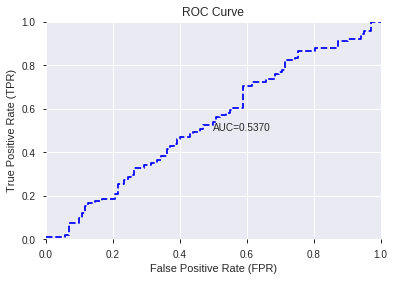

This function is available for GLM models only


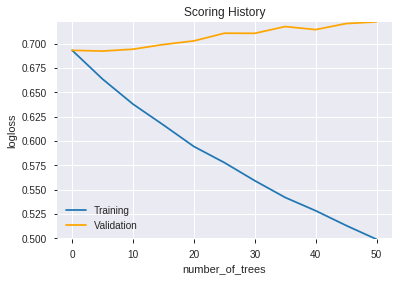

--2019-09-06 01:57:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_015729_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_015729_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b1e5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['Volume',
 'OBV',
 'BOP',
 'ADOSC',
 'STOCH_slowk',
 'NATR_14',
 'PPO',
 'MOM_24',
 'CORREL_20',
 'MACDFIX_hist_8',
 'HT_DCPERIOD',
 'TRIX_14',
 'PLUS_DI_8',
 'ADXR_14',
 'PLUS_DI_14',
 'SAREXT',
 'BBANDS_lowerband_14_6_5',
 'LINEARREG_SLOPE_20',
 'MACDEXT_signal',
 'AD',
 'BBANDS_upperband_12_1_3',
 'BBANDS_middleband_14_5_5',
 'BBANDS_upperband_20_3_5',
 'MAX_30',
 'BBANDS_lowerband_8_0_5',
 'BBANDS_upperband_20_2_5',
 'LINEARREG_INTERCEPT_30',
 'aroonup_30',
 'BBANDS_lowerband_24_6_5',
 'AROONOSC_24',
 'TSF_12',
 'BBANDS_middleband_30_2_4',
 'TYPPRICE',
 'MINMAX_min_24',
 'MA_8_5',
 'BBANDS_lowerband_14_3_3',
 'MAVP_8_0',
 'HT_TRENDMODE',
 'CDLCLOSINGMARUBOZU']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190906_015810_model_1  0.538462  0.704137              0.480392  0.505416  0.255445

variable  relative_importance  scaled_importance    percentage
0                          OBV         8.201347e-03           1.000000  1.100896e-02
1             CDLDRAGONFLYDOJI         6.981459e-03           0.851258  9.371464e-03
2                    CDLTAKURI         6.490048e-03           0.791339  8.711826e-03
3          CDLRISEFALL3METHODS         6.309786e-03           0.769360  8.469853e-03
4                    CORREL_24         6.041323e-03           0.736626  8.109486e-03
...                        ...                  ...                ...           ...
1031  BBANDS_middleband_14_2_4         1.146090e-06           0.000140  1.538438e-06
1032  BBANDS_middleband_14_2_3         1.014739e-06           0.000124  1.362121e-06
1033  BBANDS_middleband_14_1_2         9.377802e-07           0.000114  1.258816e-06
1034  BBANDS_middleband_30_5_4         5.404598e-07           0.000066  7.254788e-07
1035  BBANDS_middleband_24_5_3         1.689791e-07           0.000021  2.268268e-07

[1036 rows x 4 columns]

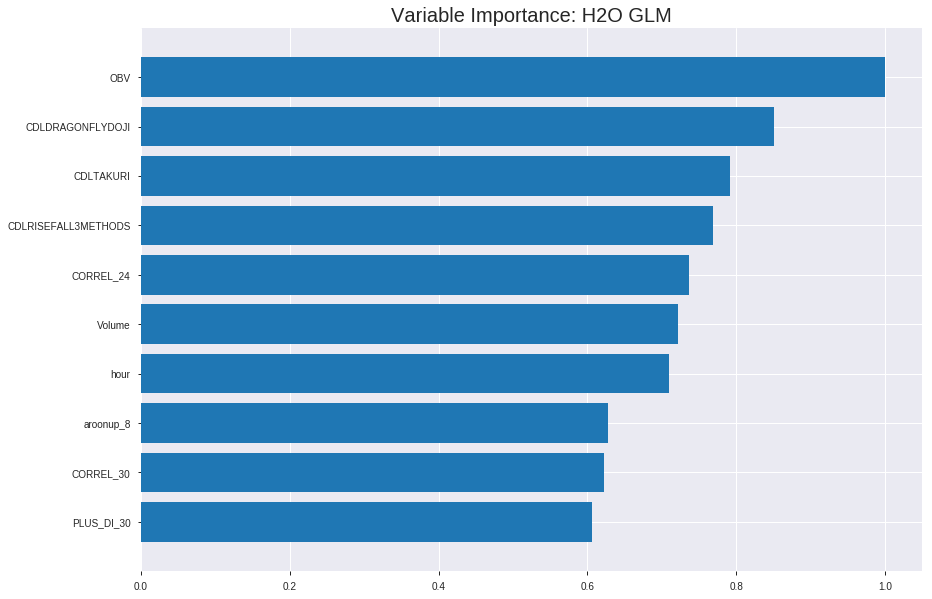

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_015810_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24551177034684762
RMSE: 0.4954914432629968
LogLoss: 0.684120829566374
Null degrees of freedom: 1349
Residual degrees of freedom: 313
Null deviance: 1870.9966158108023
Residual deviance: 1847.12623982921
AIC: 3921.12623982921
AUC: 0.5915104861940561
pr_auc: 0.5897194931733706
Gini: 0.1830209723881122
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43539495822111984: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      27   635   0.9592   (635.0/662.0)
1      9    679   0.0131   (9.0/688.0)
Total  36   1314  0.477    (644.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.435395     0.678322  370
max f2                       0.379427     0.838828  392
max f0point5                 0.512348     0.584511  188
max accuracy                 0.515523     0.577037  177
max precision                0.559153     0.75      39
max recall                   0.345124     1         398
max specificity              0.602282     0.998489  0
max absolute_mcc             0.515523     0.156144  177
max min_per_class_accuracy   0.512348     0.577035  188
max mean_per_class_accuracy  0.515523     0.577836  177

Gains/Lift Table: Avg response rate: 50.96 %, avg score: 50.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.575276           1.26142   1.26142            0.642857         0.583719  0.642857                    0.583719            0.0130814       0.0130814                  26.142    26.142
    2        0.02                        0.568568           1.50939   1.38081            0.769231         0.570939  0.703704                    0.577565            0.0145349       0.0276163                  50.9392   38.0814
    3        0.0303704                   0.56438            1.54174   1.43576            0.785714         0.566377  0.731707                    0.573745            0.0159884       0.0436047                  54.1736   43.5763
    4        0.04                        0.562668           1.35845   1.41715            0.692308         0.563547  0.722222                    0.57129             0.0130814       0.056686                   35.8453   41.7151
    5        0.0503704                   0.559649           1.54174   1.4428             0.785714         0.560903  0.735294                    0.569151            0.0159884       0.0726744                  54.1736   44.2801
    6        0.1                         0.552009           1.17147   1.30814            0.597015         0.555562  0.666667                    0.562407            0.0581395       0.130814                   17.1468   30.814
    7        0.15037                     0.545241           1.06767   1.22759            0.544118         0.548323  0.625616                    0.557689            0.0537791       0.184593                   6.76727   22.7589
    8        0.2                         0.538408           1.14218   1.2064             0.58209          0.541907  0.614815                    0.553773            0.056686        0.241279                   14.2182   20.6395
    9        0.3                         0.529087           1.09012   1.16764            0.555556         0.533848  0.595062                    0.547131            0.109012        0.350291                   9.01163   16.7636
    10       0.4                         0.520486           1.16279   1.16642            0.592593         0.524603  0.594444                    0.541499            0.116279        0.46657                    16.2791   16.6424
    11       0.5                         0.512292           1.07558   1.14826            0.548148         0.516061  0.585185                    0.536412            0.107558        0.574128                   7.55814   14.8256
    12       0.6                         0.503853           0.828488  1.09496            0.422222         0.508202  0.558025                    0.53171             0.0828488       0.656977                   -17.1512  9.49612
    13       0.7                         0.494091           0.915698  1.06935            0.466667         0.499099  0.544974                    0.527051            0.0915698       0.748547                   -8.43023  6.93522
    14       0.8                         0.484202           0.959302  1.0556             0.488889         0.48938   0.537963                    0.522342            0.0959302       0.844477                   -4.06977  5.55959
    15       0.9                         0.468045           0.901163  1.03844            0.459259         0.47704   0.529218                    0.517309            0.0901163       0.934593                   -9.88372  3.84367
    16       1                           0.31175            0.65407   1                  0.333333         0.440516  0.50963                     0.50963            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25185118703591347
RMSE: 0.5018477727716977
LogLoss: 0.696904537545105
Null degrees of freedom: 385
Residual degrees of freedom: -651
Null deviance: 536.100336915834
Residual deviance: 538.010302984821
AIC: 2612.010302984821
AUC: 0.496094591682827
pr_auc: 0.475451122049631
Gini: -0.007810816634346018
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37090961585639287: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    182  0        (0.0/182.0)
Total  0    386  0.5285   (204.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37091      0.640845  385
max f2                       0.37091      0.816876  385
max f0point5                 0.46285      0.534571  344
max accuracy                 0.570243     0.53886   3
max precision                0.581203     1         0
max recall                   0.37091      1         385
max specificity              0.581203     1         0
max absolute_mcc             0.570243     0.108337  3
max min_per_class_accuracy   0.502203     0.5       192
max mean_per_class_accuracy  0.475115     0.522678  310

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 50.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.570066           2.12088   2.12088            1                0.575289  1                           0.575289            0.021978        0.021978                   112.088   112.088
    2        0.0207254                   0.55969            0         1.06044            0                0.567103  0.5                         0.571196            0               0.021978                   -100      6.04396
    3        0.0310881                   0.555587           1.59066   1.23718            0.75             0.557905  0.583333                    0.566766            0.0164835       0.0384615                  59.0659   23.7179
    4        0.0414508                   0.554131           0.53022   1.06044            0.25             0.554728  0.5                         0.563756            0.00549451      0.043956                   -46.978   6.04396
    5        0.0518135                   0.550801           1.06044   1.06044            0.5              0.552437  0.5                         0.561492            0.010989        0.0549451                  6.04396   6.04396
    6        0.101036                    0.542087           0.781377  0.924486           0.368421         0.546155  0.435897                    0.55402             0.0384615       0.0934066                  -21.8623  -7.55142
    7        0.150259                    0.534298           1.00463   0.950739           0.473684         0.538687  0.448276                    0.548997            0.0494505       0.142857                   0.462695  -4.92611
    8        0.202073                    0.529591           1.27253   1.03325            0.6              0.532088  0.487179                    0.544662            0.0659341       0.208791                   27.2527   3.32488
    9        0.300518                    0.522424           0.948814  1.00559            0.447368         0.526186  0.474138                    0.538609            0.0934066       0.302198                   -5.11857  0.558924
    10       0.401554                    0.511681           0.870104  0.971499           0.410256         0.516604  0.458065                    0.533072            0.0879121       0.39011                    -12.9896  -2.85005
    11       0.5                         0.502199           1.11625   1                  0.526316         0.50701   0.471503                    0.527941            0.10989         0.5                        11.6252   0
    12       0.601036                    0.49339            0.978867  0.996448           0.461538         0.497342  0.469828                    0.522797            0.0989011       0.598901                   -2.11327  -0.355248
    13       0.699482                    0.483947           0.893002  0.981888           0.421053         0.489029  0.462963                    0.518045            0.0879121       0.686813                   -10.6998  -1.81115
    14       0.800518                    0.475482           1.30516   1.02269            0.615385         0.479069  0.482201                    0.513126            0.131868        0.818681                   30.5156   2.26893
    15       0.898964                    0.461779           1.00463   1.02071            0.473684         0.467917  0.481268                    0.508175            0.0989011       0.917582                   0.462695  2.07113
    16       1                           0.37091            0.815723  1                  0.384615         0.442918  0.471503                    0.501581        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 01:58:13  0.000 sec   2            3.9       1037          1.36824           1.39381
    2019-09-06 01:58:15  1.549 sec   4            2.9       1037          1.36487           1.39466
    2019-09-06 01:58:16  3.171 sec   6            2.1       1037          1.36083           1.39562
    2019-09-06 01:58:18  4.731 sec   8            1.5       1037          1.3561            1.39712
    2019-09-06 01:58:19  6.273 sec   10           1.1       1037          1.35065           1.39953

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5647668393782384)

('F1', 0.65)

('auc', 0.5384615384615384)

('logloss', 0.7041369009749546)

('mean_per_class_error', 0.44376212023270845)

('rmse', 0.5054157660694252)

('mse', 0.25544509659154396)

glm prediction progress: |████████████████████████████████████████████████| 100%


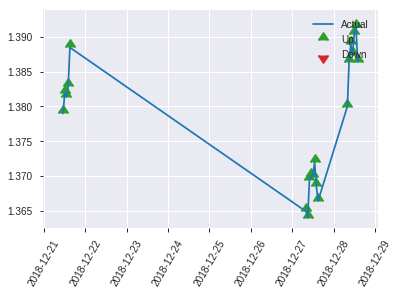


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25544509659154396
RMSE: 0.5054157660694252
LogLoss: 0.7041369009749546
Null degrees of freedom: 192
Residual degrees of freedom: -844
Null deviance: 268.05016845791704
Residual deviance: 271.7968437763325
AIC: 2345.7968437763325
AUC: 0.5384615384615384
pr_auc: 0.4950615444524054
Gini: 0.07692307692307687
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49021368211302496: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      4    98   0.9608   (98.0/102.0)
1      0    91   0        (0.0/91.0)
Total  4    189  0.5078   (98.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490214     0.65      188
max f2                       0.490214     0.822785  188
max f0point5                 0.535597     0.545087  162
max accuracy                 0.569166     0.564767  66
max precision                0.600213     0.75      3
max recall                   0.490214     1         188
max specificity              0.622494     0.990196  0
max absolute_mcc             0.490214     0.13741   188
max min_per_class_accuracy   0.562177     0.529412  96
max mean_per_class_accuracy  0.569166     0.556238  66

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 55.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.605315           1.06044   1.06044            0.5              0.616337  0.5                         0.616337            0.010989        0.010989                   6.04396   6.04396
    2        0.0207254                   0.596203           2.12088   1.59066            1                0.602553  0.75                        0.609445            0.021978        0.032967                   112.088   59.0659
    3        0.0310881                   0.592786           0         1.06044            0                0.594418  0.5                         0.604436            0               0.032967                   -100      6.04396
    4        0.0414508                   0.59048            0         0.79533            0                0.592292  0.375                       0.6014              0               0.032967                   -100      -20.467
    5        0.0518135                   0.587419           1.06044   0.848352           0.5              0.588631  0.4                         0.598846            0.010989        0.043956                   6.04396   -15.1648
    6        0.103627                    0.58429            1.27253   1.06044            0.6              0.585962  0.5                         0.592404            0.0659341       0.10989                    27.2527   6.04396
    7        0.150259                    0.579515           0.942613  1.02387            0.444444         0.581335  0.482759                    0.588969            0.043956        0.153846                   -5.73871  2.38727
    8        0.202073                    0.577837           1.48462   1.14201            0.7              0.578766  0.538462                    0.586353            0.0769231       0.230769                   48.4615   14.2012
    9        0.300518                    0.572765           0.893002  1.06044            0.421053         0.575151  0.5                         0.582683            0.0879121       0.318681                   -10.6998  6.04396
    10       0.398964                    0.566696           0.893002  1.01912            0.421053         0.569501  0.480519                    0.579431            0.0879121       0.406593                   -10.6998  1.91237
    11       0.502591                    0.562177           1.27253   1.07137            0.6              0.564495  0.505155                    0.576351            0.131868        0.538462                   27.2527   7.13719
    12       0.601036                    0.557929           0.893002  1.04216            0.421053         0.560108  0.491379                    0.573691            0.0879121       0.626374                   -10.6998  4.21561
    13       0.699482                    0.549757           1.00463   1.03687            0.473684         0.552913  0.488889                    0.570766            0.0989011       0.725275                   0.462695  3.68742
    14       0.797927                    0.541165           0.893002  1.01912            0.421053         0.545436  0.480519                    0.567641            0.0879121       0.813187                   -10.6998  1.91237
    15       0.896373                    0.525072           1.00463   1.01753            0.473684         0.533999  0.479769                    0.563946            0.0989011       0.912088                   0.462695  1.75316
    16       1                           0.481627           0.848352  1                  0.4              0.503121  0.471503                    0.557643        

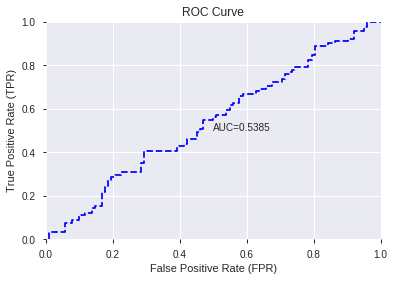

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


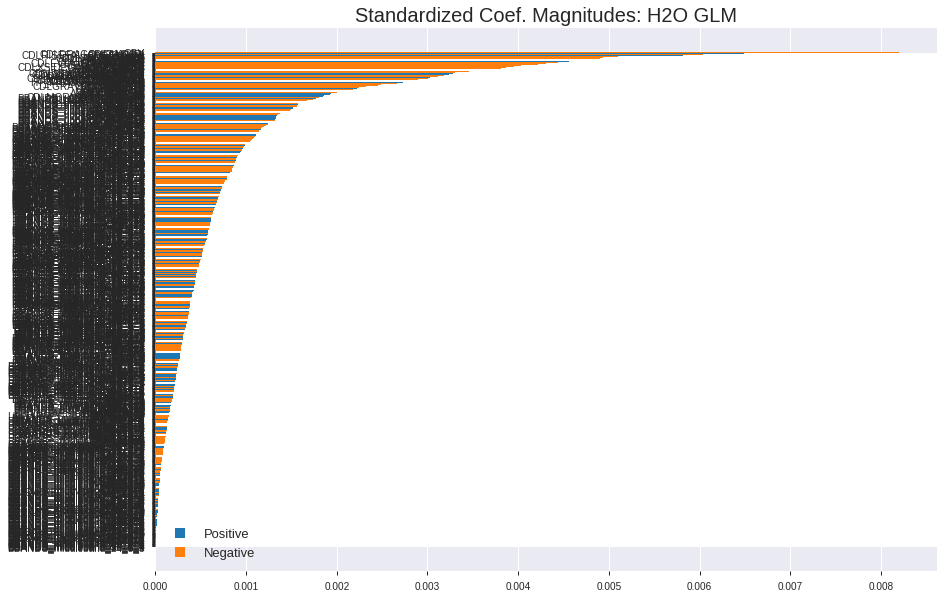

'log_likelihood'
--2019-09-06 01:58:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.96.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.96.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_015810_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_015810_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b1e5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

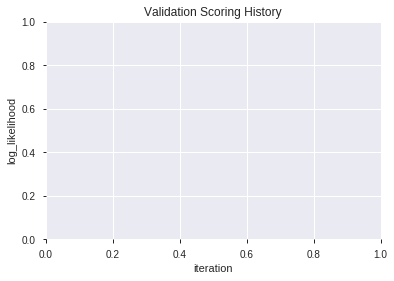

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190906_015859  0.593514  0.720426              0.500000  0.513108  0.263280
1  XGBoost_grid_1_AutoML_20190906_015859_model_3  0.567658  0.702099              0.472366  0.504298  0.254317
2               XGBoost_1_AutoML_20190906_015859  0.539862  0.707423              0.458845  0.506653  0.256698
3  XGBoost_grid_1_AutoML_20190906_015859_model_2  0.533613  0.699081              0.490789  0.502971  0.252980
4  XGBoost_grid_1_AutoML_20190906_015859_model_6  0.528765  0.729237              0.480392  0.516532  0.266805
5  XGBoost_grid_1_AutoML_20190906_015859_model_1  0.523971  0.695784              0.500000  0.501274  0.251276
6               XGBoost_3_AutoML_20190906_015859  0.518207  0.724326              0.495098  0.515010  0.265235
7  XGBoost_grid_1_AutoML_20190906_015859_model_4  0.509588  0.708316              0.500000  0.507441  0.257496
8  XGBoost_grid_1_AutoML_20190906_015859_model_7  0.493428  0.742740              0.495098  0.522482  0.272988
9  XGBoost_grid_1_AutoML_20190906_015859_model_5  0.468218  0.731794              0.500000  0.518262  0.268596

variable  relative_importance  scaled_importance  percentage
0                        OBV           153.095520           1.000000    0.031797
1                      ADOSC            87.318626           0.570354    0.018135
2                      DX_20            82.973999           0.541975    0.017233
3                  CORREL_24            81.982368           0.535498    0.017027
4                    BETA_20            77.857025           0.508552    0.016170
..                       ...                  ...                ...         ...
275                  TRIX_12             3.047232           0.019904    0.000633
276                  SAR_0.3             3.034330           0.019820    0.000630
277   BBANDS_lowerband_8_8_4             2.887630           0.018862    0.000600
278                  MA_30_6             2.777177           0.018140    0.000577
279  BBANDS_lowerband_30_1_3             2.363434           0.015438    0.000491

[280 rows x 4 columns]

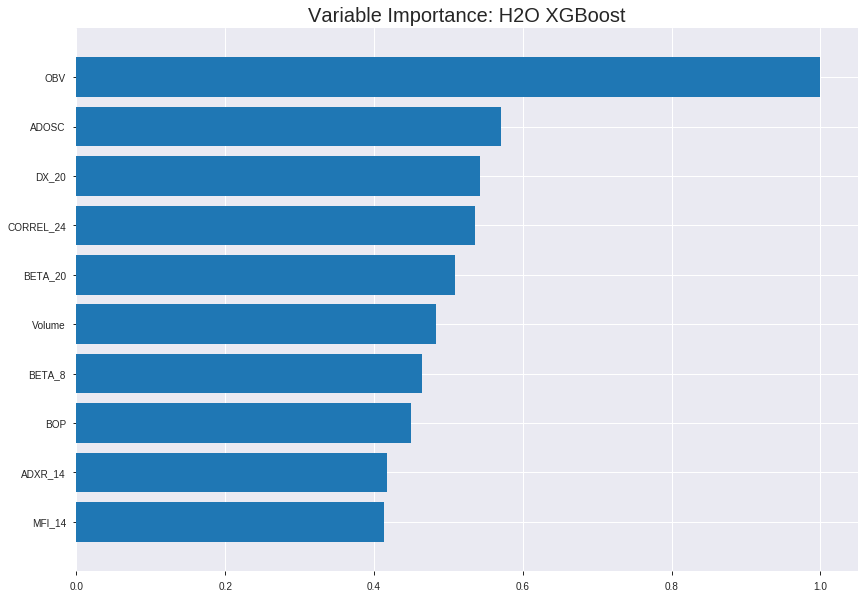

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190906_015859


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17199720271022506
RMSE: 0.4147254546205538
LogLoss: 0.5316685900754387
Mean Per-Class Error: 0.1375588421274503
AUC: 0.9348993097028034
pr_auc: 0.9360714425427209
Gini: 0.8697986194056069
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49509912729263306: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      553  109  0.1647   (109.0/662.0)
1      76   612  0.1105   (76.0/688.0)
Total  629  721  0.137    (185.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.495099     0.868701  214
max f2                       0.443265     0.910337  259
max f0point5                 0.550111     0.880838  169
max accuracy                 0.495099     0.862963  214
max precision                0.815723     1         0
max recall                   0.261669     1         393
max specificity              0.815723     1         0
max absolute_mcc             0.495099     0.726437  214
max min_per_class_accuracy   0.511468     0.853474  201
max mean_per_class_accuracy  0.495099     0.862441  214

Gains/Lift Table: Avg response rate: 50.96 %, avg score: 51.12 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.757522           1.96221    1.96221            1                0.773196  1                           0.773196            0.0203488       0.0203488                  96.2209   96.2209
    2        0.02                        0.736189           1.96221    1.96221            1                0.744627  1                           0.759441            0.0188953       0.0392442                  96.2209   96.2209
    3        0.0303704                   0.723746           1.96221    1.96221            1                0.72863   1                           0.74892             0.0203488       0.059593                   96.2209   96.2209
    4        0.04                        0.716609           1.96221    1.96221            1                0.720258  1                           0.74202             0.0188953       0.0784884                  96.2209   96.2209
    5        0.0503704                   0.71104            1.96221    1.96221            1                0.713514  1                           0.736151            0.0203488       0.0988372                  96.2209   96.2209
    6        0.1                         0.679803           1.96221    1.96221            1                0.694137  1                           0.7153              0.0973837       0.196221                   96.2209   96.2209
    7        0.15037                     0.656671           1.87564    1.93321            0.955882         0.667968  0.985222                    0.699445            0.0944767       0.290698                   87.5641   93.3211
    8        0.2                         0.632416           1.87435    1.9186             0.955224         0.64394   0.977778                    0.685671            0.0930233       0.383721                   87.4349   91.8605
    9        0.3                         0.592235           1.84593    1.89438            0.940741         0.612928  0.965432                    0.661423            0.184593        0.568314                   84.593    89.438
    10       0.4                         0.554391           1.5843     1.81686            0.807407         0.574241  0.925926                    0.639628            0.15843         0.726744                   58.4302   81.686
    11       0.5                         0.514053           1.19186    1.69186            0.607407         0.535063  0.862222                    0.618715            0.119186        0.84593                    19.186    69.186
    12       0.6                         0.473581           0.857558   1.55281            0.437037         0.490915  0.791358                    0.597415            0.0857558       0.931686                   -14.2442  55.281
    13       0.7                         0.428601           0.406977   1.38912            0.207407         0.450036  0.707937                    0.576361            0.0406977       0.972384                   -59.3023  38.912
    14       0.8                         0.389497           0.203488   1.24092            0.103704         0.409739  0.632407                    0.555533            0.0203488       0.992733                   -79.6512  24.0916
    15       0.9                         0.33811            0.0581395  1.1095             0.0296296        0.364343  0.565432                    0.53429             0.00581395      0.998547                   -94.186   10.9496
    16       1                           0.195016           0.0145349  1                  0.00740741       0.302912  0.50963                     0.51



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25881193998315394
RMSE: 0.5087356287730926
LogLoss: 0.7116316704127729
Mean Per-Class Error: 0.44947209653092
AUC: 0.5085110967463908
pr_auc: 0.46578406025219093
Gini: 0.017022193492781668
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4116392135620117: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      12   192  0.9412   (192.0/204.0)
1      2    180  0.011    (2.0/182.0)
Total  14   372  0.5026   (194.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411639     0.649819  371
max f2                       0.330919     0.819082  382
max f0point5                 0.48742      0.548276  316
max accuracy                 0.693626     0.533679  13
max precision                0.749971     1         0
max recall                   0.330919     1         382
max specificity              0.749971     1         0
max absolute_mcc             0.48742      0.129135  316
max min_per_class_accuracy   0.567719     0.494505  191
max mean_per_class_accuracy  0.497366     0.550528  305

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 55.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.715091           1.06044   1.06044            0.5              0.730355  0.5                         0.730355            0.010989        0.010989                   6.04396   6.04396
    2        0.0207254                   0.701134           1.06044   1.06044            0.5              0.707581  0.5                         0.718968            0.010989        0.021978                   6.04396   6.04396
    3        0.0310881                   0.695307           1.06044   1.06044            0.5              0.698428  0.5                         0.712121            0.010989        0.032967                   6.04396   6.04396
    4        0.0414508                   0.682315           1.06044   1.06044            0.5              0.689692  0.5                         0.706514            0.010989        0.043956                   6.04396   6.04396
    5        0.0518135                   0.672273           0         0.848352           0                0.674621  0.4                         0.700135            0               0.043956                   -100      -15.1648
    6        0.101036                    0.650125           1.11625   0.978867           0.526316         0.660003  0.461538                    0.680584            0.0549451       0.0989011                  11.6252   -2.11327
    7        0.150259                    0.63686            1.22788   1.06044            0.578947         0.642107  0.5                         0.667979            0.0604396       0.159341                   22.7877   6.04396
    8        0.202073                    0.618429           0.636264  0.951677           0.3              0.629949  0.448718                    0.658228            0.032967        0.192308                   -36.3736  -4.83235
    9        0.300518                    0.597071           0.725564  0.877605           0.342105         0.607138  0.413793                    0.641492            0.0714286       0.263736                   -27.4436  -12.2395
    10       0.401554                    0.582468           1.25077   0.971499           0.589744         0.589077  0.458065                    0.628303            0.126374        0.39011                    25.0775   -2.85005
    11       0.5                         0.567407           1.06044   0.989011           0.5              0.575509  0.466321                    0.617909            0.104396        0.494505                   6.04396   -1.0989
    12       0.601036                    0.548046           1.14201   1.01473            0.538462         0.558611  0.478448                    0.60794             0.115385        0.60989                    14.2012   1.4731
    13       0.699482                    0.528125           1.11625   1.02902            0.526316         0.538247  0.485185                    0.598132            0.10989         0.71978                    11.6252   2.90191
    14       0.800518                    0.494363           1.25077   1.05701            0.589744         0.512198  0.498382                    0.587286            0.126374        0.846154                   25.0775   5.70077
    15       0.898964                    0.44847            0.781377  1.02682            0.368421         0.476458  0.48415                     0.575149            0.0769231       0.923077                   -21.8623  2.68233
    16       1                           0.273441           0.761341  1                  0.358974         0.405171  0.471503                    0.557975     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:59:02  0.006 sec   0                  0.5              0.693147            0.5             0                  1                0.49037                          0.5                0.693147              0.5               0                    1                  0.528497
    2019-09-06 01:59:03  0.662 sec   5                  0.488644         0.670645            0.767997        0.762083           1.96221          0.319259                         0.500226           0.693598              0.517063          0.485154             0.53022            0.515544
    2019-09-06 01:59:03  1.072 sec   10                 0.478316         0.650499            0.817673        0.812898           1.96221          0.268148                         0.499877           0.692897              0.52754           0.489909             1.06044            0.512953
    2019-09-06 01:59:04  1.476 sec   15                 0.468295         0.631176            0.842105        0.84181            1.96221          0.247407                         0.500935           0.695055              0.518921          0.47333              1.59066            0.468912
    2019-09-06 01:59:04  1.891 sec   20                 0.458899         0.61328             0.865816        0.864465           1.96221          0.220741                         0.501731           0.696656              0.512794          0.474944             1.59066            0.497409
    2019-09-06 01:59:05  2.277 sec   25                 0.450576         0.597567            0.881492        0.879187           1.96221          0.192593                         0.502226           0.69769               0.517426          0.48034              2.12088            0.507772
    2019-09-06 01:59:05  2.681 sec   30                 0.44289          0.58318             0.894972        0.893549           1.96221          0.184444                         0.503537           0.700388              0.513844          0.479707             2.12088            0.5
    2019-09-06 01:59:05  3.089 sec   35                 0.435157         0.568813            0.906384        0.903369           1.96221          0.174074                         0.504659           0.702714              0.506976          0.474464             2.12088            0.510363
    2019-09-06 01:59:06  3.529 sec   40                 0.428237         0.556034            0.914604        0.913764           1.96221          0.157778                         0.506179           0.705938              0.503771          0.46955              1.59066            0.505181
    2019-09-06 01:59:06  3.919 sec   45                 0.421618         0.544014            0.925085        0.925166           1.96221          0.148889                         0.506079           0.705786              0.506626          0.468823             0.53022            0.497409
    2019-09-06 01:59:07  4.310 sec   50                 0.414725         0.531669            0.934899        0.936071           1.96221          0.137037                         0.508736           0.711632              0.508511          0.465784             1.06044            0.502591

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
OBV                      153.09552001953125     1.0                   0.03179654782641235
ADOSC                    87.3186264038086       0.5703538966566029    0.018135284953022315
DX_20                    82.9739990234375       0.5419753563843804    0.01723294534001283
CORREL_24                81.98236846923828      0.5354981547388149    0.017026992688108287
BETA_20                  77.85702514648438      0.5085519493748198    0.01617019638051169
---                      ---                    ---                   ---
TRIX_12                  3.047231674194336      0.019904120472013703  0.0006328823185310569
SAR_0.3                  3.034329891204834      0.019819847705652833  0.0006302027354849994
BBANDS_lowerband_8_8_4   2.8876304626464844     0.018861626142150294  0.0005997345977127912
MA_30_6                  2.777176856994629      0.01814015757378354   0.0005767943878734644
BBANDS_lowerband_30_1_3  2.363433599472046      0.015437640495100899  0.0004908636743294357


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6010362694300518)

('F1', 0.6408450704225352)

('auc', 0.5935143288084465)

('logloss', 0.7204257875122764)

('mean_per_class_error', 0.399967679379444)

('rmse', 0.5131081465836761)

('mse', 0.2632799700905352)

xgboost prediction progress: |████████████████████████████████████████████| 100%


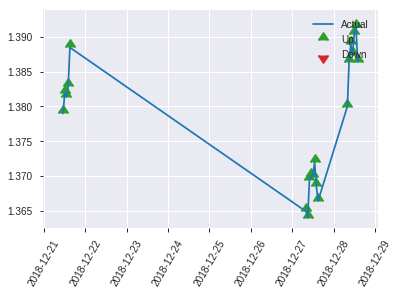


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2632799700905352
RMSE: 0.5131081465836761
LogLoss: 0.7204257875122764
Mean Per-Class Error: 0.399967679379444
AUC: 0.5935143288084465
pr_auc: 0.5660680267974939
Gini: 0.1870286576168929
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4576098322868347: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    102  1        (102.0/102.0)
1      0    91   0        (0.0/91.0)
Total  0    193  0.5285   (102.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45761      0.640845  192
max f2                       0.45761      0.816876  192
max f0point5                 0.620442     0.577342  91
max accuracy                 0.631447     0.601036  79
max precision                0.769775     1         0
max recall                   0.45761      1         192
max specificity              0.769775     1         0
max absolute_mcc             0.620442     0.199957  91
max min_per_class_accuracy   0.620442     0.582418  91
max mean_per_class_accuracy  0.620442     0.600032  91

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 61.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.739639           2.12088   2.12088            1                0.757518  1                           0.757518            0.021978        0.021978                   112.088   112.088
    2        0.0207254                   0.724138           2.12088   2.12088            1                0.737649  1                           0.747584            0.021978        0.043956                   112.088   112.088
    3        0.0310881                   0.715261           0         1.41392            0                0.720381  0.666667                    0.738516            0               0.043956                   -100      41.3919
    4        0.0414508                   0.71023            2.12088   1.59066            1                0.713736  0.75                        0.732321            0.021978        0.0659341                  112.088   59.0659
    5        0.0518135                   0.705862           2.12088   1.6967             1                0.708333  0.8                         0.727523            0.021978        0.0879121                  112.088   69.6703
    6        0.103627                    0.682455           0.848352  1.27253            0.4              0.693883  0.6                         0.710703            0.043956        0.131868                   -15.1648  27.2527
    7        0.150259                    0.671585           1.17827   1.24327            0.555556         0.676382  0.586207                    0.700052            0.0549451       0.186813                   17.8266   24.3274
    8        0.202073                    0.662948           1.48462   1.30516            0.7              0.667288  0.615385                    0.691651            0.0769231       0.263736                   48.4615   30.5156
    9        0.300518                    0.65204            1.22788   1.27984            0.578947         0.658238  0.603448                    0.680705            0.120879        0.384615                   22.7877   27.9841
    10       0.398964                    0.633817           1.11625   1.23947            0.526316         0.64276   0.584416                    0.671342            0.10989         0.494505                   11.6252   23.9475
    11       0.502591                    0.614555           0.954396  1.1807             0.45             0.624421  0.556701                    0.661668            0.0989011       0.593407                   -4.56044  18.0696
    12       0.601036                    0.600113           0.781377  1.11529            0.368421         0.605939  0.525862                    0.65254             0.0769231       0.67033                    -21.8623  11.529
    13       0.699482                    0.58063            1.00463   1.09972            0.473684         0.593733  0.518519                    0.644263            0.0989011       0.769231                   0.462695  9.97151
    14       0.797927                    0.554786           0.669751  1.04667            0.315789         0.563706  0.493506                    0.634324            0.0659341       0.835165                   -33.0249  4.66676
    15       0.896373                    0.522683           0.558126  0.993013           0.263158         0.539227  0.468208                    0.62388             0.0549451       0.89011                    -44.1874  -0.698723
    16       1                           0.45761            1.06044   1                  0.5              0.50097   0.471503                    0.611143        

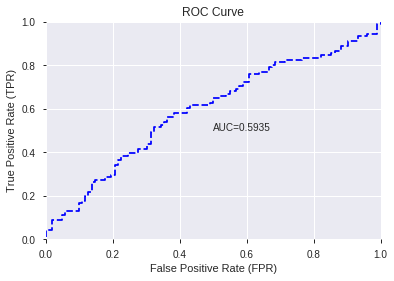

This function is available for GLM models only


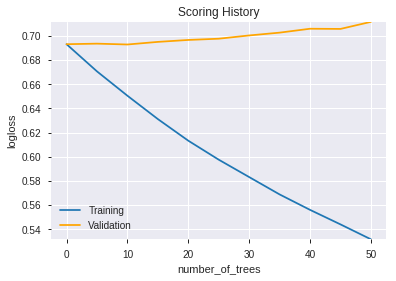

--2019-09-06 01:59:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


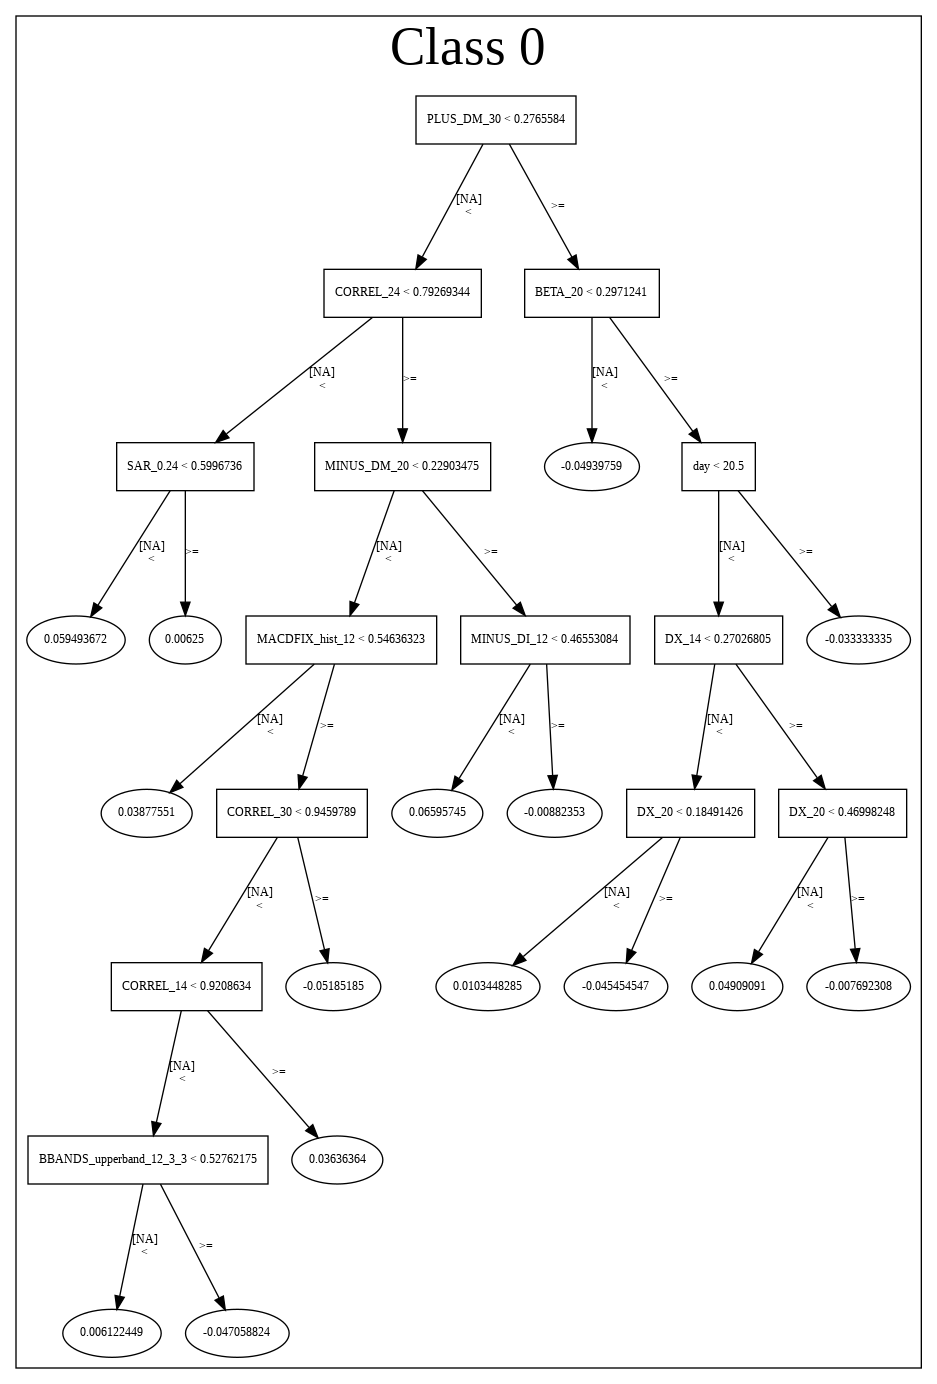

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190906_015859',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190906_015859',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b1e5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_b1e5',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_015959_model_1  0.556184  3.968446              0.471181  0.722143  0.521490
1  DeepLearning_grid_1_AutoML_20190906_015959_model_3  0.547619  0.895366              0.480392  0.564185  0.318305
2  DeepLearning_grid_1_AutoML_20190906_015959_model_2  0.547404  2.406153              0.495098  0.672141  0.451774
3  DeepLearning_grid_1_AutoML_20190906_015959_model_9  0.544926  0.700598              0.485294  0.503696  0.253710
4  DeepLearning_grid_1_AutoML_20190906_015959_model_6  0.531997  0.742137              0.463154  0.522831  0.273352
5  DeepLearning_grid_1_AutoML_20190906_015959_model_8  0.527796  0.695368              0.495098  0.501108  0.251109
6               DeepLearning_1_AutoML_20190906_015959  0.517776  2.007052              0.485294  0.697337  0.486280
7  DeepLearning_grid_1_AutoML_20190906_015959_model_4  0.516160  0.817062              0.500000  0.538743  0.290244
8  DeepLearning_grid_1_AutoML_20190906_015959_model_7  0.503232  0.744916              0.500000  0.522299  0.272796
9  DeepLearning_grid_1_AutoML_20190906_015959_model_5  0.493267  0.715959              0.500000  0.511035  0.261157

variable  relative_importance  scaled_importance  percentage
0            CDLHOMINGPIGEON             1.000000           1.000000    0.026348
1         CDLEVENINGDOJISTAR             0.993524           0.993524    0.026177
2         CDLIDENTICAL3CROWS             0.949390           0.949390    0.025014
3            CDLLADDERBOTTOM             0.938051           0.938051    0.024716
4          CDL3WHITESOLDIERS             0.924632           0.924632    0.024362
5         CDLMORNINGDOJISTAR             0.915003           0.915003    0.024108
6                CDLPIERCING             0.908639           0.908639    0.023941
7             CDLMORNINGSTAR             0.902135           0.902135    0.023769
8                     Volume             0.872730           0.872730    0.022995
9                     SAREXT             0.836458           0.836458    0.022039
10              is_month_end             0.828722           0.828722    0.021835
11                 CORREL_20             0.825280           0.825280    0.021744
12                 CDLTAKURI             0.816552           0.816552    0.021514
13              HT_TRENDMODE             0.815745           0.815745    0.021493
14                   ADXR_14             0.798269           0.798269    0.021033
15               CDLDOJISTAR             0.798184           0.798184    0.021030
16                       OBV             0.783802           0.783802    0.020651
17        CDLCLOSINGMARUBOZU             0.781554           0.781554    0.020592
18                       BOP             0.767030           0.767030    0.020210
19               STOCH_slowk             0.763565           0.763565    0.020118
20                        AD             0.756850           0.756850    0.019941
21               HT_DCPERIOD             0.750260           0.750260    0.019768
22                   NATR_14             0.744222           0.744222    0.019609
23            MACDFIX_hist_8             0.725987           0.725987    0.019128
24                aroonup_30             0.721858           0.721858    0.019019
25                     ADOSC             0.720615           0.720615    0.018987
26                    TSF_12             0.717350           0.717350    0.018901
27               AROONOSC_24             0.700065           0.700065    0.018445
28                   TRIX_14             0.697709           0.697709    0.018383
29   BBANDS_lowerband_24_6_5             0.696956           0.696956    0.018363
30   BBANDS_upperband_20_3_5             0.696709           0.696709    0.018357
31        LINEARREG_SLOPE_20             0.694155           0.694155    0.018289
32  BBANDS_middleband_30_2_4             0.693068           0.693068    0.018261
33             MINMAX_min_24             0.688971           0.688971    0.018153
34   BBANDS_upperband_20_2_5             0.688332           0.688332    0.018136
35                 PLUS_DI_8             0.685404           0.685404    0.018059
36   BBANDS_lowerband_14_6_5             0.677311           0.677311    0.017846
37                PLUS_DI_14             0.675269           0.675269    0.017792
38  BBANDS_middleband_14_5_5             0.672630           0.672630    0.017722
39                  MAVP_8_0             0.672592           0.672592    0.017721
40                       PPO             0.671516           0.671516    0.017693
41                  TYPPRICE             0.671443           0.671443    0.017691
42   BBANDS_lowerband_14_3_3             0.670322           0.670322    0.017662
43                    MOM_24             0.670292           0.670292    0.017661
44   BBANDS_upperband_12_1_3             0.669490           0.669490    0.017640
45                    MAX_30             0.667558           0.667558    0.017589
46    LINEARREG_INTERCEPT_30             0.665311           0.665311    0.017529
47            MACDEXT_signal             0.663476           0.663476    0.017481
48    BBANDS_lowerband_8_0_5             0.662717  

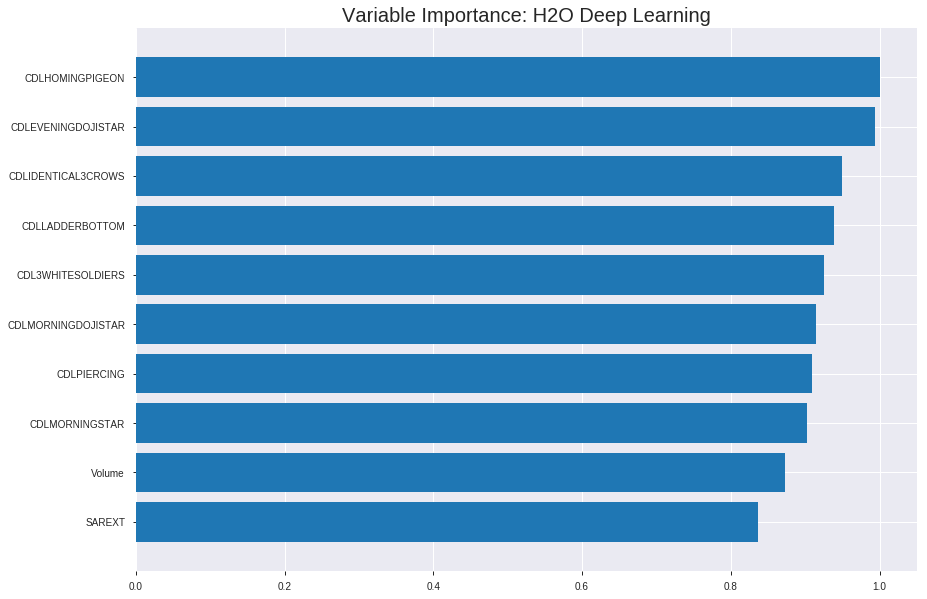

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_015959_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2791867931763876
RMSE: 0.5283812952559804
LogLoss: 1.066709017641102
Mean Per-Class Error: 0.3547016616314199
AUC: 0.6712075370617578
pr_auc: 0.6556329352189302
Gini: 0.3424150741235157
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.000681327191345126: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      38   624   0.9426   (624.0/662.0)
1      15   673   0.0218   (15.0/688.0)
Total  53   1297  0.4733   (639.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.000681327  0.678086  398
max f2                       0.000157384  0.838615  399
max f0point5                 0.735896     0.654601  138
max accuracy                 0.735896     0.643704  138
max precision                0.992988     0.833333  6
max recall                   0.000157384  1         399
max specificity              0.999841     0.990937  0
max absolute_mcc             0.735896     0.294335  138
max min_per_class_accuracy   0.635705     0.642442  176
max mean_per_class_accuracy  0.735896     0.645298  138

Gains/Lift Table: Avg response rate: 50.96 %, avg score: 56.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.99994            1.82205   1.82205            0.928571         0.999995    0.928571                    0.999995            0.0188953       0.0188953                  82.2051   82.2051
    2        0.02                        0.998628           1.20751   1.52616            0.615385         0.999537    0.777778                    0.999774            0.0116279       0.0305233                  20.7513   52.6163
    3        0.0303704                   0.997146           1.68189   1.57934            0.857143         0.997927    0.804878                    0.999143            0.0174419       0.0479651                  68.1894   57.9339
    4        0.04                        0.994819           1.66033   1.59884            0.846154         0.995934    0.814815                    0.998371            0.0159884       0.0639535                  66.0331   59.8837
    5        0.0503704                   0.991568           1.68189   1.61594            0.857143         0.993302    0.823529                    0.997327            0.0174419       0.0813953                  68.1894   61.5937
    6        0.1                         0.978765           1.46434   1.5407             0.746269         0.985197    0.785185                    0.991307            0.0726744       0.15407                    46.4335   54.0698
    7        0.15037                     0.956825           1.64479   1.57557            0.838235         0.968604    0.802956                    0.983702            0.0828488       0.236919                   64.4793   57.5567
    8        0.2                         0.932443           1.14218   1.46802            0.58209          0.947334    0.748148                    0.974677            0.056686        0.293605                   14.2182   46.8023
    9        0.3                         0.85941            1.19186   1.37597            0.607407         0.900488    0.701235                    0.949947            0.119186        0.412791                   19.186    37.5969
    10       0.4                         0.764471           1.25      1.34448            0.637037         0.814055    0.685185                    0.915974            0.125           0.537791                   25        34.4477
    11       0.5                         0.642161           1.01744   1.27907            0.518519         0.702923    0.651852                    0.873364            0.101744        0.639535                   1.74419   27.907
    12       0.6                         0.491501           0.857558  1.20882            0.437037         0.564169    0.616049                    0.821832            0.0857558       0.725291                   -14.2442  20.8818
    13       0.7                         0.326069           0.697674  1.1358             0.355556         0.414946    0.578836                    0.763705            0.0697674       0.795058                   -30.2326  13.5797
    14       0.8                         0.129495           0.508721  1.05741            0.259259         0.227998    0.538889                    0.696742            0.0508721       0.84593                    -49.1279  5.74128
    15       0.9                         0.00951469         0.828488  1.03198            0.422222         0.0509914   0.525926                    0.624992            0.0828488       0.928779                   -17.1512  3.19767
    16       1                           1.02562e-16        0.712209  1                  0.362963         0.00226851  0.50963   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.42795348305091396
RMSE: 0.6541815367701186
LogLoss: 1.9693122346409753
Mean Per-Class Error: 0.4781566472742944
AUC: 0.48890325360913595
pr_auc: 0.4490168498252606
Gini: -0.022193492781728108
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0001257956008312271: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    201  0.9853   (201.0/204.0)
1      0    182  0        (0.0/182.0)
Total  3    383  0.5207   (201.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.000125796  0.644248  382
max f2                       0.000125796  0.819082  382
max f0point5                 0.00193634   0.535936  357
max accuracy                 0.999999     0.528497  1
max precision                0.999999     0.5       1
max recall                   0.000125796  1         382
max specificity              1            0.995098  0
max absolute_mcc             0.999201     0.092273  15
max min_per_class_accuracy   0.472566     0.504902  192
max mean_per_class_accuracy  0.00193634   0.521843  357

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 49.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.999949           0.53022   0.53022            0.25             0.99999     0.25                        0.99999             0.00549451      0.00549451                 -46.978   -46.978
    2        0.0207254                   0.999792           1.06044   0.79533            0.5              0.999889    0.375                       0.999939            0.010989        0.0164835                  6.04396   -20.467
    3        0.0310881                   0.999551           0         0.53022            0                0.999683    0.25                        0.999854            0               0.0164835                  -100      -46.978
    4        0.0414508                   0.999183           0.53022   0.53022            0.25             0.999348    0.25                        0.999727            0.00549451      0.021978                   -46.978   -46.978
    5        0.0518135                   0.999032           1.59066   0.742308           0.75             0.999115    0.35                        0.999605            0.0164835       0.0384615                  59.0659   -25.7692
    6        0.101036                    0.994873           1.00463   0.870104           0.473684         0.996821    0.410256                    0.998249            0.0494505       0.0879121                  0.462695  -12.9896
    7        0.150259                    0.988394           0.781377  0.841038           0.368421         0.991927    0.396552                    0.996178            0.0384615       0.126374                   -21.8623  -15.8962
    8        0.202073                    0.979302           1.16648   0.924486           0.55             0.983268    0.435897                    0.992868            0.0604396       0.186813                   16.6484   -7.55142
    9        0.300518                    0.930731           1.06044   0.969022           0.5              0.9602      0.456897                    0.982166            0.104396        0.291209                   6.04396   -3.09776
    10       0.401554                    0.743996           1.14201   1.01255            0.538462         0.856162    0.477419                    0.950462            0.115385        0.406593                   14.2012   1.25487
    11       0.5                         0.470905           1.00463   1.01099            0.473684         0.629098    0.476684                    0.887188            0.0989011       0.505495                   0.462695  1.0989
    12       0.601036                    0.215634           0.815723  0.978164           0.384615         0.347782    0.461207                    0.796512            0.0824176       0.587912                   -18.4277  -2.18359
    13       0.699482                    0.0599899          1.00463   0.981888           0.473684         0.124795    0.462963                    0.701974            0.0989011       0.686813                   0.462695  -1.81115
    14       0.800518                    0.0140027          1.14201   1.0021             0.538462         0.0321753   0.472492                    0.617437            0.115385        0.802198                   14.2012   0.209823
    15       0.898964                    0.00301779         1.06044   1.00849            0.5              0.00753549  0.475504                    0.550646            0.104396        0.906593                   6.04396   0.848719
    16       1                           1.26697e-14        0.924486  1                  0.435897         0.00122039  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 02:00:01  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 02:00:06  5.255 sec         2625 obs/sec      10        1             13500      0.615803         2.2728              -0.517416      0.56464         0.522582           1.40158          0.49037                          0.715388           4.36499               -1.05379         0.465807          0.438371             1.06044            0.520725
    2019-09-06 02:00:15  14.409 sec        2849 obs/sec      30        3             40500      0.558258         1.33283             -0.247072      0.622613        0.616436           1.96221          0.49037                          0.690629           2.81469               -0.91409         0.47312           0.451602             1.59066            0.518135
    2019-09-06 02:00:24  22.962 sec        2974 obs/sec      50        5             67500      0.528381         1.06671             -0.117162      0.671208        0.655633           1.82205          0.473333                         0.654182           1.96931               -0.717393        0.488903          0.449017             0.53022            0.520725
    2019-09-06 02:00:31  30.924 sec        3091 obs/sec      70        7             94500      0.495864         0.876295            0.0161123      0.710826        0.698033           1.82205          0.34                             0.660721           2.10158               -0.751898        0.475975          0.437921             0.53022            0.520725
    2019-09-06 02:00:39  38.504 sec        3191 obs/sec      90        9             121500     0.490085         0.880465            0.0389105      0.722488        0.706588           1.54174          0.312593                         0.67406            2.48936               -0.823349        0.47246           0.43931              0.53022            0.525907
    2019-09-06 02:00:46  45.933 sec        3269 obs/sec      110       11            148500     0.48047          0.89587             0.0762529      0.739964        0.738534           1.68189          0.316296                         0.663954           2.24604               -0.769085        0.470157          0.437454             0.53022            0.525907
    2019-09-06 02:00:54  53.204 sec        3335 obs/sec      130       13            175500     0.485273         0.92031             0.0576928      0.745627        0.754693           1.82205          0.311111                         0.66541            2.39028               -0.776854        0.466844          0.437122             0.53022            0.528497
    2019-09-06 02:01:01  1 min  0.510 sec  3383 obs/sec      150       15            202500     0.46503          0.829042            0.134669       0.781989        0.78201            1.96221          0.256296                         0.67913            2.51716               -0.850881        0.467168          0.436641             0.53022            0.523316
    2019-09-06 02:01:01

Variable Importances: 


variable                relative_importance    scaled_importance    percentage
----------------------  ---------------------  -------------------  --------------------
CDLHOMINGPIGEON         1.0                    1.0                  0.026347797581766606
CDLEVENINGDOJISTAR      0.9935239553451538     0.9935239553451538   0.026177168068070238
CDLIDENTICAL3CROWS      0.9493899345397949     0.9493899345397949   0.025014333821421163
CDLLADDERBOTTOM         0.9380505084991455     0.9380505084991455   0.02471556491940872
CDL3WHITESOLDIERS       0.9246320724487305     0.9246320724487305   0.024362018682488506
---                     ---                    ---                  ---
MAX_30                  0.6675577163696289     0.6675577163696289   0.017588675585053344
LINEARREG_INTERCEPT_30  0.6653112769126892     0.6653112769126892   0.017529486852962205
MACDEXT_signal          0.663475751876831      0.663475751876831    0.01748112481086115
BBANDS_lowerband_8_0_5  0.6627165079116821     0.6627165079116821   0.01746112040455223
MA_8_5                  0.6461350917816162     0.6461350917816162   0.01702423660873821


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5699481865284974)

('F1', 0.6521739130434784)

('auc', 0.556184012066365)

('logloss', 3.9684456518499225)

('mean_per_class_error', 0.43665158371040724)

('rmse', 0.7221425258774657)

('mse', 0.5214898276806863)

deeplearning prediction progress: |███████████████████████████████████████| 100%


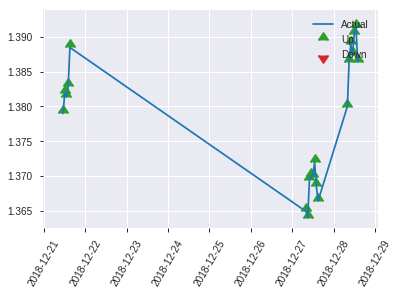


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5214898276806863
RMSE: 0.7221425258774657
LogLoss: 3.9684456518499225
Mean Per-Class Error: 0.43665158371040724
AUC: 0.556184012066365
pr_auc: 0.5065536425705893
Gini: 0.11236802413273006
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9419970344783632: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      7    95   0.9314   (95.0/102.0)
1      1    90   0.011    (1.0/91.0)
Total  8    185  0.4974   (96.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.941997     0.652174  181
max f2                       0.941997     0.819672  181
max f0point5                 0.941997     0.541516  181
max accuracy                 0.999929     0.569948  50
max precision                1            1         0
max recall                   0.0491795    1         189
max specificity              1            1         0
max absolute_mcc             0.941997     0.144345  181
max min_per_class_accuracy   0.999624     0.549451  92
max mean_per_class_accuracy  0.999683     0.563348  88

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 98.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   1                  1.06044   1.06044            0.5              1         0.5                         1                   0.010989        0.010989                   6.04396   6.04396
    2        0.0207254                   1                  1.06044   1.06044            0.5              1         0.5                         1                   0.010989        0.021978                   6.04396   6.04396
    3        0.0310881                   0.999999           1.06044   1.06044            0.5              1         0.5                         1                   0.010989        0.032967                   6.04396   6.04396
    4        0.0414508                   0.999998           0         0.79533            0                0.999999  0.375                       1                   0               0.032967                   -100      -20.467
    5        0.0518135                   0.999997           2.12088   1.06044            1                0.999998  0.5                         0.999999            0.021978        0.0549451                  112.088   6.04396
    6        0.103627                    0.999987           1.06044   1.06044            0.5              0.999993  0.5                         0.999996            0.0549451       0.10989                    6.04396   6.04396
    7        0.150259                    0.99997            0.942613  1.02387            0.444444         0.999978  0.482759                    0.99999             0.043956        0.153846                   -5.73871  2.38727
    8        0.202073                    0.999957           1.6967    1.19639            0.8              0.999965  0.564103                    0.999984            0.0879121       0.241758                   69.6703   19.6393
    9        0.300518                    0.999886           1.00463   1.13357            0.473684         0.999932  0.534483                    0.999967            0.0989011       0.340659                   0.462695  13.3573
    10       0.398964                    0.999791           1.00463   1.10176            0.473684         0.999844  0.519481                    0.999936            0.0989011       0.43956                    0.462695  10.1755
    11       0.502591                    0.999596           1.06044   1.09324            0.5              0.999709  0.515464                    0.999889            0.10989         0.549451                   6.04396   9.32367
    12       0.601036                    0.999053           1.00463   1.07872            0.473684         0.999381  0.508621                    0.999806            0.0989011       0.648352                   0.462695  7.8723
    13       0.699482                    0.997738           0.781377  1.03687            0.368421         0.998558  0.488889                    0.99963             0.0769231       0.725275                   -21.8623  3.68742
    14       0.797927                    0.99246            1.00463   1.0329             0.473684         0.995977  0.487013                    0.99918             0.0989011       0.824176                   0.462695  3.28957
    15       0.896373                    0.977497           0.893002  1.01753            0.421053         0.987076  0.479769                    0.99785             0.0879121       0.912088                   -10.6998  1.75316
    16       1                           0.0491795          0.848352  1                  0.4              0.887898  0.471503                    0.986456          

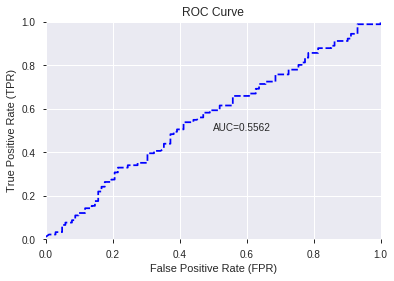

This function is available for GLM models only


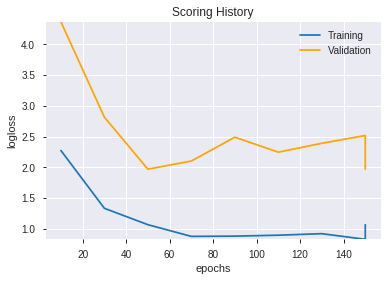

--2019-09-06 02:09:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.38.196
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.38.196|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


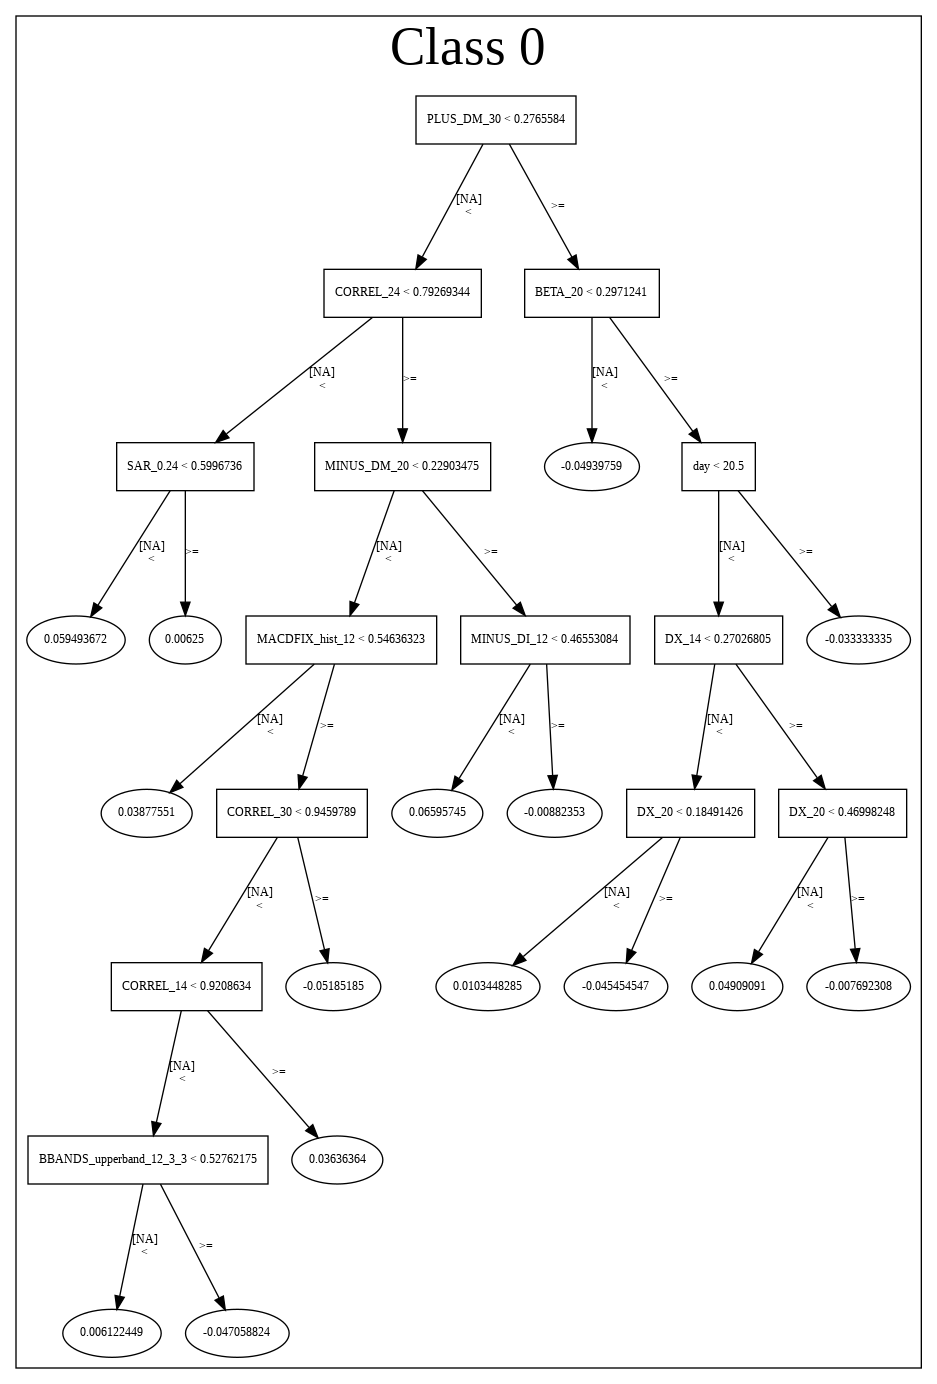

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_015959_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_015959_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b1e5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLHOMINGPIGEON',
 'CDLEVENINGDOJISTAR',
 'CDLIDENTICAL3CROWS',
 'CDLLADDERBOTTOM',
 'CDL3WHITESOLDIERS',
 'CDLMORNINGDOJISTAR',
 'CDLPIERCING',
 'CDLMORNINGSTAR',
 'Volume',
 'SAREXT',
 'is_month_end',
 'CORREL_20',
 'CDLTAKURI',
 'HT_TRENDMODE',
 'ADXR_14',
 'CDLDOJISTAR',
 'OBV',
 'CDLCLOSINGMARUBOZU',
 'BOP',
 'STOCH_slowk',
 'AD',
 'HT_DCPERIOD',
 'NATR_14',
 'MACDFIX_hist_8',
 'aroonup_30',
 'ADOSC',
 'TSF_12',
 'AROONOSC_24',
 'TRIX_14',
 'BBANDS_lowerband_24_6_5',
 'BBANDS_upperband_20_3_5',
 'LINEARREG_SLOPE_20',
 'BBANDS_middleband_30_2_4',
 'MINMAX_min_24',
 'BBANDS_upperband_20_2_5',
 'PLUS_DI_8',
 'BBANDS_lowerband_14_6_5',
 'PLUS_DI_14',
 'BBANDS_middleband_14_5_5',
 'MAVP_8_0',
 'PPO',
 'TYPPRICE',
 'BBANDS_lowerband_14_3_3',
 'MOM_24',
 'BBANDS_upperband_12_1_3',
 'MAX_30',
 'LINEARREG_INTERCEPT_30',
 'MACDEXT_signal',
 'BBANDS_lowerband_8_0_5',
 'MA_8_5']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190906_020914_model_1  0.555915  0.699936              0.485294  0.503371  0.253383

variable  relative_importance  scaled_importance  percentage
0                     Volume             0.013973           1.000000    0.064277
1                        OBV             0.013653           0.977130    0.062807
2                  CDLTAKURI             0.012406           0.887849    0.057069
3                 PLUS_DI_14             0.011805           0.844860    0.054305
4                  PLUS_DI_8             0.010567           0.756249    0.048610
5                  CORREL_20             0.008191           0.586195    0.037679
6                    ADXR_14             0.007816           0.559397    0.035957
7         CDLEVENINGDOJISTAR             0.007721           0.552585    0.035519
8    BBANDS_upperband_20_2_5             0.007279           0.520936    0.033484
9    BBANDS_upperband_20_3_5             0.007278           0.520888    0.033481
10                   NATR_14             0.007255           0.519236    0.033375
11               CDLDOJISTAR             0.007129           0.510203    0.032794
12               HT_DCPERIOD             0.006832           0.488989    0.031431
13   BBANDS_upperband_12_1_3             0.005754           0.411830    0.026471
14        CDLIDENTICAL3CROWS             0.005716           0.409089    0.026295
15           CDLLADDERBOTTOM             0.005672           0.405926    0.026092
16         CDL3WHITESOLDIERS             0.005408           0.387044    0.024878
17                    SAREXT             0.004739           0.339176    0.021801
18              is_month_end             0.003979           0.284781    0.018305
19                    MAX_30             0.003779           0.270489    0.017386
20              HT_TRENDMODE             0.003566           0.255220    0.016405
21               AROONOSC_24             0.003527           0.252403    0.016224
22                       BOP             0.003507           0.250963    0.016131
23   BBANDS_lowerband_14_6_5             0.003356           0.240177    0.015438
24        CDLMORNINGDOJISTAR             0.003338           0.238877    0.015354
25   BBANDS_lowerband_24_6_5             0.003170           0.226873    0.014583
26                        AD             0.003127           0.223798    0.014385
27           CDLHOMINGPIGEON             0.002985           0.213642    0.013732
28        CDLCLOSINGMARUBOZU             0.002975           0.212909    0.013685
29    BBANDS_lowerband_8_0_5             0.002891           0.206935    0.013301
30                     ADOSC             0.002807           0.200857    0.012911
31    LINEARREG_INTERCEPT_30             0.002548           0.182375    0.011723
32                  MAVP_8_0             0.002317           0.165789    0.010656
33  BBANDS_middleband_30_2_4             0.002211           0.158224    0.010170
34                  TYPPRICE             0.002153           0.154057    0.009902
35  BBANDS_middleband_14_5_5             0.002117           0.151514    0.009739
36            CDLMORNINGSTAR             0.002053           0.146921    0.009444
37                    TSF_12             0.002030           0.145293    0.009339
38                    MA_8_5             0.001943           0.139022    0.008936
39   BBANDS_lowerband_14_3_3             0.001376           0.098499    0.006331
40            MACDFIX_hist_8             0.001191           0.085246    0.005479
41                   TRIX_14             0.001026           0.073446    0.004721
42                    MOM_24             0.000857           0.061323    0.003942
43             MINMAX_min_24             0.000787           0.056357    0.003622
44        LINEARREG_SLOPE_20             0.000739           0.052908    0.003401
45               STOCH_slowk             0.000653           0.046741    0.003004
46                aroonup_30             0.000515           0.036847    0.002368
47            MACDEXT_signal             0.000318           0.022756    0.001463
48                       PPO             0.000183  

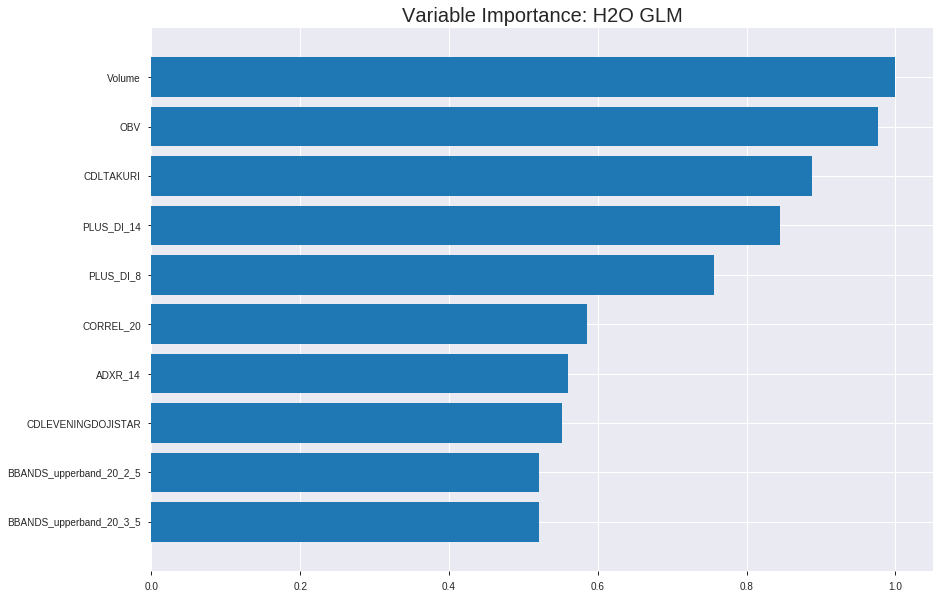

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_020914_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2480303870790983
RMSE: 0.4980264923466404
LogLoss: 0.6892021757980633
Null degrees of freedom: 1349
Residual degrees of freedom: 1299
Null deviance: 1870.9966158108023
Residual deviance: 1860.8458746547708
AIC: 1962.8458746547708
AUC: 0.5824426508817537
pr_auc: 0.5869078816080777
Gini: 0.16488530176350746
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4879866854529782: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      43   619   0.935    (619.0/662.0)
1      18   670   0.0262   (18.0/688.0)
Total  61   1289  0.4719   (637.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.487987     0.677795  360
max f2                       0.470936     0.839639  394
max f0point5                 0.500548     0.582983  275
max accuracy                 0.509735     0.560741  201
max precision                0.571943     1         0
max recall                   0.470936     1         394
max specificity              0.571943     1         0
max absolute_mcc             0.515581     0.132232  151
max min_per_class_accuracy   0.510211     0.555233  198
max mean_per_class_accuracy  0.515581     0.56245   151

Gains/Lift Table: Avg response rate: 50.96 %, avg score: 50.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.539095           1.54174   1.54174            0.785714         0.549828  0.785714                    0.549828            0.0159884       0.0159884                  54.1736   54.1736
    2        0.02                        0.534768           1.35845   1.45349            0.692308         0.535971  0.740741                    0.543156            0.0130814       0.0290698                  35.8453   45.3488
    3        0.0303704                   0.533171           1.12126   1.34005            0.571429         0.533867  0.682927                    0.539984            0.0116279       0.0406977                  12.1262   34.0045
    4        0.04                        0.532176           1.05657   1.2718             0.538462         0.532669  0.648148                    0.538223            0.0101744       0.0508721                  5.65742   27.1802
    5        0.0503704                   0.530824           1.26142   1.26966            0.642857         0.531473  0.647059                    0.536833            0.0130814       0.0639535                  26.142    26.9665
    6        0.1                         0.525597           1.34719   1.30814            0.686567         0.527964  0.666667                    0.532431            0.0668605       0.130814                   34.7188   30.814
    7        0.15037                     0.522126           1.15424   1.25659            0.588235         0.523879  0.640394                    0.529566            0.0581395       0.188953                   15.4241   25.6587
    8        0.2                         0.520273           1.14218   1.2282             0.58209          0.521207  0.625926                    0.527492            0.056686        0.24564                    14.2182   22.8198
    9        0.3                         0.516622           1.06105   1.17248            0.540741         0.518606  0.597531                    0.52453             0.106105        0.351744                   6.10465   17.2481
    10       0.4                         0.513446           0.959302  1.11919            0.488889         0.515066  0.57037                     0.522164            0.0959302       0.447674                   -4.06977  11.9186
    11       0.5                         0.51007            1.09012   1.11337            0.555556         0.511805  0.567407                    0.520092            0.109012        0.556686                   9.01163   11.3372
    12       0.6                         0.507073           0.915698  1.08043            0.466667         0.508629  0.550617                    0.518182            0.0915698       0.648256                   -8.43023  8.04264
    13       0.7                         0.502853           1.03198   1.0735             0.525926         0.505038  0.54709                     0.516304            0.103198        0.751453                   3.19767   7.3505
    14       0.8                         0.498247           0.930233  1.0556             0.474074         0.500644  0.537963                    0.514347            0.0930233       0.844477                   -6.97674  5.55959
    15       0.9                         0.492384           0.799419  1.02713            0.407407         0.495355  0.523457                    0.512236            0.0799419       0.924419                   -20.0581  2.71318
    16       1                           0.430947           0.755814  1                  0.385185         0.486168  0.50963                     0.50963            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25049515695103736
RMSE: 0.5004949120131366
LogLoss: 0.6941382973670179
Null degrees of freedom: 385
Residual degrees of freedom: 335
Null deviance: 536.100336915834
Residual deviance: 535.8747655673378
AIC: 637.8747655673378
AUC: 0.5159179056237879
pr_auc: 0.48512581258086573
Gini: 0.03183581124757584
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4948107605922923: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      25   179  0.8775   (179.0/204.0)
1      5    177  0.0275   (5.0/182.0)
Total  30   356  0.4767   (184.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494811     0.657993  355
max f2                       0.487162     0.819082  382
max f0point5                 0.495487     0.553097  349
max accuracy                 0.53442      0.541451  12
max precision                0.551832     1         0
max recall                   0.487162     1         382
max specificity              0.551832     1         0
max absolute_mcc             0.495487     0.178002  349
max min_per_class_accuracy   0.50959      0.504902  192
max mean_per_class_accuracy  0.495487     0.551848  349

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 51.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.540701           1.59066   1.59066            0.75             0.546016  0.75                        0.546016            0.0164835       0.0164835                  59.0659   59.0659
    2        0.0207254                   0.536947           1.06044   1.32555            0.5              0.539038  0.625                       0.542527            0.010989        0.0274725                  6.04396   32.5549
    3        0.0310881                   0.534769           1.59066   1.41392            0.75             0.536032  0.666667                    0.540362            0.0164835       0.043956                   59.0659   41.3919
    4        0.0414508                   0.533472           0.53022   1.19299            0.25             0.533873  0.5625                      0.53874             0.00549451      0.0494505                  -46.978   19.2995
    5        0.0518135                   0.53218            1.06044   1.16648            0.5              0.532853  0.55                        0.537562            0.010989        0.0604396                  6.04396   16.6484
    6        0.101036                    0.52927            1.11625   1.14201            0.526316         0.530324  0.538462                    0.534036            0.0549451       0.115385                   11.6252   14.2012
    7        0.150259                    0.52765            0.669751  0.987306           0.315789         0.528591  0.465517                    0.532252            0.032967        0.148352                   -33.0249  -1.26942
    8        0.202073                    0.52553            0.848352  0.951677           0.4              0.526483  0.448718                    0.530773            0.043956        0.192308                   -15.1648  -4.83235
    9        0.300518                    0.520291           0.948814  0.950739           0.447368         0.522935  0.448276                    0.528205            0.0934066       0.285714                   -5.11857  -4.92611
    10       0.401554                    0.514414           0.978867  0.957816           0.461538         0.517404  0.451613                    0.525488            0.0989011       0.384615                   -2.11327  -4.21836
    11       0.5                         0.509513           1.22788   1.01099            0.578947         0.511632  0.476684                    0.52276             0.120879        0.505495                   22.7877   1.0989
    12       0.601036                    0.505731           1.03325   1.01473            0.487179         0.507864  0.478448                    0.520256            0.104396        0.60989                    3.32488   1.4731
    13       0.699482                    0.502542           1.11625   1.02902            0.526316         0.504278  0.485185                    0.518007            0.10989         0.71978                    11.6252   2.90191
    14       0.800518                    0.499392           1.03325   1.02955            0.487179         0.500904  0.485437                    0.515848            0.104396        0.824176                   3.32488   2.9553
    15       0.898964                    0.495724           1.28369   1.05738            0.605263         0.497525  0.498559                    0.513842            0.126374        0.950549                   28.369    5.73835
    16       1                           0.464398           0.489434  1                  0.230769         0.491115  0.471503                    0.511545        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 02:09:14  0.000 sec   2            3.5       51            1.38078           1.38833
    2019-09-06 02:09:14  0.016 sec   4            2.2       51            1.3784            1.38828
    2019-09-06 02:09:14  0.030 sec   6            1.3       51            1.3753            1.38844
    2019-09-06 02:09:14  0.046 sec   8            0.84      51            1.37153           1.3891
    2019-09-06 02:09:14  0.065 sec   10           0.52      51            1.36729           1.39062
    2019-09-06 02:09:14  0.076 sec   12           0.32      51            1.36289           1.39328
    2019-09-06 02:09:14  0.089 sec   14           0.2       51            1.35865           1.39701

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5854922279792746)

('F1', 0.6476868327402135)

('auc', 0.5559146735617324)

('logloss', 0.6999357101501577)

('mean_per_class_error', 0.40578539107950873)

('rmse', 0.5033714764493809)

('mse', 0.25338284330282956)

glm prediction progress: |████████████████████████████████████████████████| 100%


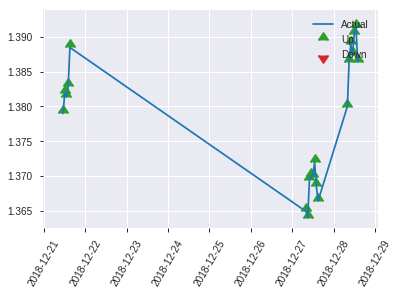


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25338284330282956
RMSE: 0.5033714764493809
LogLoss: 0.6999357101501577
Null degrees of freedom: 192
Residual degrees of freedom: 142
Null deviance: 268.05016845791704
Residual deviance: 270.17518411796084
AIC: 372.17518411796084
AUC: 0.5559146735617324
pr_auc: 0.5012590386858857
Gini: 0.11182934712346482
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5181771268344381: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      3    99   0.9706   (99.0/102.0)
1      0    91   0        (0.0/91.0)
Total  3    190  0.513    (99.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.518177     0.647687  189
max f2                       0.518177     0.8213    189
max f0point5                 0.540597     0.575296  124
max accuracy                 0.540597     0.585492  124
max precision                0.56317      0.714286  6
max recall                   0.518177     1         189
max specificity              0.580389     0.990196  0
max absolute_mcc             0.540597     0.196906  124
max min_per_class_accuracy   0.547173     0.549451  93
max mean_per_class_accuracy  0.540597     0.594215  124

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 54.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.572996           1.06044   1.06044            0.5              0.579008  0.5                         0.579008            0.010989        0.010989                   6.04396   6.04396
    2        0.0207254                   0.566327           1.06044   1.06044            0.5              0.569848  0.5                         0.574428            0.010989        0.021978                   6.04396   6.04396
    3        0.0310881                   0.563556           2.12088   1.41392            1                0.565479  0.666667                    0.571445            0.021978        0.043956                   112.088   41.3919
    4        0.0414508                   0.56187            1.06044   1.32555            0.5              0.562968  0.625                       0.569326            0.010989        0.0549451                  6.04396   32.5549
    5        0.0518135                   0.561065           1.06044   1.27253            0.5              0.561268  0.6                         0.567714            0.010989        0.0659341                  6.04396   27.2527
    6        0.103627                    0.559074           0.848352  1.06044            0.4              0.559981  0.5                         0.563848            0.043956        0.10989                    -15.1648  6.04396
    7        0.150259                    0.557239           0.471306  0.877605           0.222222         0.55812   0.413793                    0.56207             0.021978        0.131868                   -52.8694  -12.2395
    8        0.202073                    0.555979           0.636264  0.815723           0.3              0.556713  0.384615                    0.560697            0.032967        0.164835                   -36.3736  -18.4277
    9        0.300518                    0.55238            1.22788   0.950739           0.578947         0.554188  0.448276                    0.558564            0.120879        0.285714                   22.7877   -4.92611
    10       0.398964                    0.549866           1.67438   1.1293             0.789474         0.551568  0.532468                    0.556838            0.164835        0.450549                   67.4378   12.9299
    11       0.502591                    0.546336           1.06044   1.1151             0.5              0.548284  0.525773                    0.555074            0.10989         0.56044                    6.04396   11.5101
    12       0.601036                    0.541841           1.22788   1.13357            0.578947         0.544184  0.534483                    0.553291            0.120879        0.681319                   22.7877   13.3573
    13       0.699482                    0.538416           0.893002  1.09972            0.421053         0.540224  0.518519                    0.551452            0.0879121       0.769231                   -10.6998  9.97151
    14       0.797927                    0.534813           0.446501  1.01912            0.210526         0.536681  0.480519                    0.549629            0.043956        0.813187                   -55.3499  1.91237
    15       0.896373                    0.529745           1.22788   1.04205            0.578947         0.532912  0.491329                    0.547793            0.120879        0.934066                   22.7877   4.20504
    16       1                           0.506014           0.636264  1                  0.3              0.522884  0.471503                    0.545212      

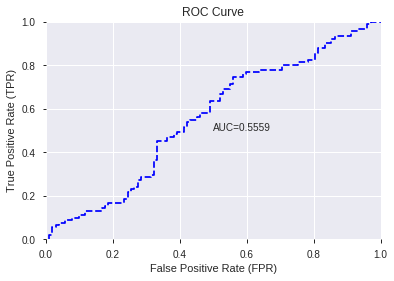

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


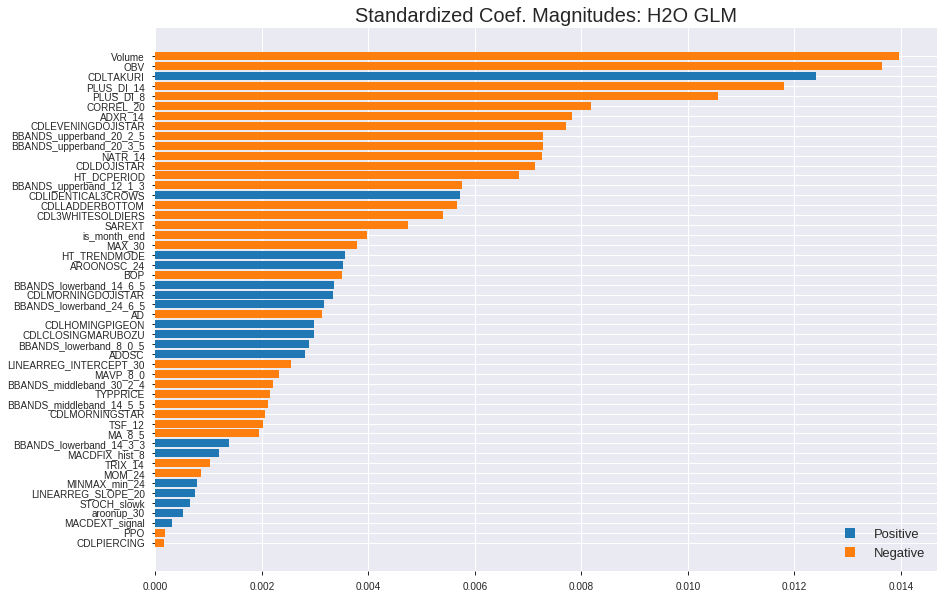

'log_likelihood'
--2019-09-06 02:09:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.80.80
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.80.80|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


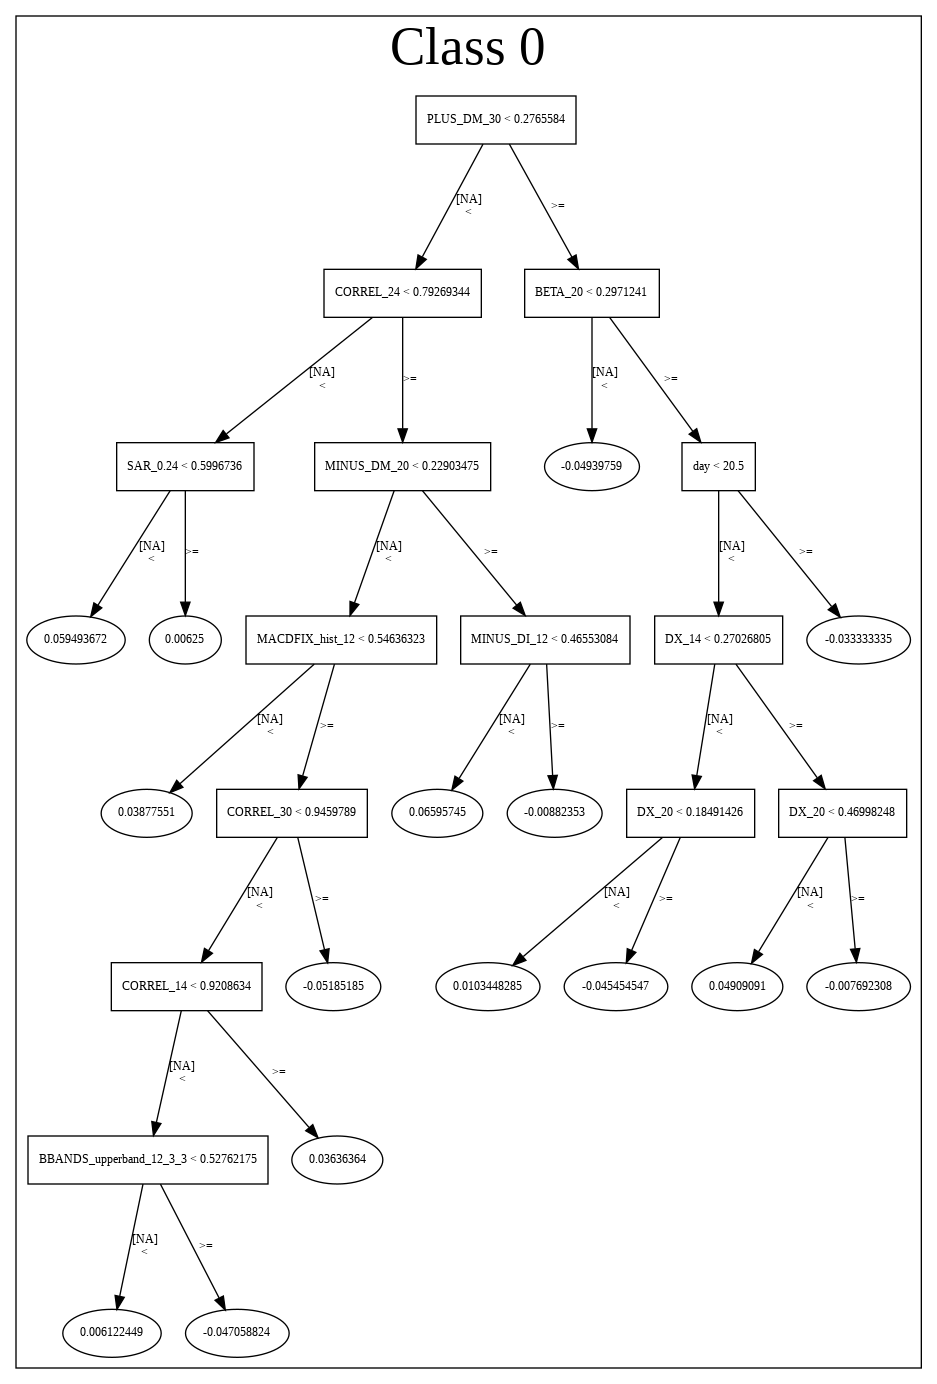

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_020914_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_020914_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b1e5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['Volume',
 'OBV',
 'CDLTAKURI',
 'PLUS_DI_14',
 'PLUS_DI_8',
 'CORREL_20',
 'ADXR_14',
 'CDLEVENINGDOJISTAR',
 'BBANDS_upperband_20_2_5',
 'BBANDS_upperband_20_3_5',
 'NATR_14',
 'CDLDOJISTAR',
 'HT_DCPERIOD',
 'BBANDS_upperband_12_1_3',
 'CDLIDENTICAL3CROWS',
 'CDLLADDERBOTTOM',
 'CDL3WHITESOLDIERS',
 'SAREXT',
 'is_month_end',
 'MAX_30',
 'HT_TRENDMODE',
 'AROONOSC_24',
 'BOP',
 'BBANDS_lowerband_14_6_5',
 'CDLMORNINGDOJISTAR',
 'BBANDS_lowerband_24_6_5',
 'AD',
 'CDLHOMINGPIGEON',
 'CDLCLOSINGMARUBOZU',
 'BBANDS_lowerband_8_0_5',
 'ADOSC',
 'LINEARREG_INTERCEPT_30',
 'MAVP_8_0',
 'BBANDS_middleband_30_2_4',
 'TYPPRICE',
 'BBANDS_middleband_14_5_5',
 'CDLMORNINGSTAR',
 'TSF_12',
 'MA_8_5',
 'BBANDS_lowerband_14_3_3',
 'MACDFIX_hist_8',
 'TRIX_14',
 'MOM_24',
 'MINMAX_min_24',
 'LINEARREG_SLOPE_20',
 'STOCH_slowk',
 'aroonup_30',
 'MACDEXT_signal',
 'PPO',
 'CDLPIERCING']

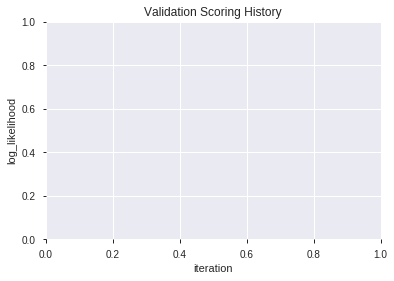

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_020934_model_7  0.536953  0.726415              0.485294  0.515219  0.265451
1               XGBoost_1_AutoML_20190906_020934  0.511528  0.709651              0.490789  0.507938  0.258001
2  XGBoost_grid_1_AutoML_20190906_020934_model_6  0.490196  0.733921              0.495098  0.518457  0.268797
3  XGBoost_grid_1_AutoML_20190906_020934_model_2  0.486964  0.701667              0.485887  0.504206  0.254224
4  XGBoost_grid_1_AutoML_20190906_020934_model_1  0.484702  0.720905              0.495098  0.513330  0.263507
5  XGBoost_grid_1_AutoML_20190906_020934_model_4  0.482439  0.736801              0.500000  0.520642  0.271068
6               XGBoost_3_AutoML_20190906_020934  0.469403  0.719544              0.495098  0.512549  0.262706
7               XGBoost_2_AutoML_20190906_020934  0.466117  0.749538              0.500000  0.526306  0.276998
8  XGBoost_grid_1_AutoML_20190906_020934_model_5  0.450011  0.743461              0.500000  0.523036  0.273566
9  XGBoost_grid_1_AutoML_20190906_020934_model_3  0.441284  0.734641              0.461377  0.519460  0.269839

variable  relative_importance  scaled_importance  percentage
0                     Volume           382.893921           1.000000    0.063242
1                        OBV           359.829224           0.939762    0.059432
2                        BOP           312.849243           0.817065    0.051673
3                      ADOSC           267.815094           0.699450    0.044235
4                STOCH_slowk           261.053253           0.681790    0.043118
5                    NATR_14           255.146637           0.666364    0.042142
6                        PPO           219.562897           0.573430    0.036265
7                     MOM_24           215.699753           0.563341    0.035627
8                  CORREL_20           212.709274           0.555531    0.035133
9             MACDFIX_hist_8           212.032333           0.553763    0.035021
10               HT_DCPERIOD           197.790558           0.516568    0.032669
11                   TRIX_14           195.350296           0.510194    0.032266
12                 PLUS_DI_8           195.068436           0.509458    0.032219
13                   ADXR_14           184.198593           0.481070    0.030424
14                PLUS_DI_14           176.379517           0.460649    0.029132
15                    SAREXT           175.562805           0.458516    0.028997
16   BBANDS_lowerband_14_6_5           160.824799           0.420024    0.026563
17        LINEARREG_SLOPE_20           158.043045           0.412759    0.026104
18            MACDEXT_signal           155.630692           0.406459    0.025705
19                        AD           150.140671           0.392121    0.024799
20   BBANDS_upperband_12_1_3           149.019852           0.389194    0.024613
21  BBANDS_middleband_14_5_5           112.406578           0.293571    0.018566
22   BBANDS_upperband_20_3_5           110.756126           0.289261    0.018293
23                    MAX_30           109.289627           0.285431    0.018051
24    BBANDS_lowerband_8_0_5           108.067169           0.282238    0.017849
25   BBANDS_upperband_20_2_5           102.932983           0.268829    0.017001
26    LINEARREG_INTERCEPT_30            98.255981           0.256614    0.016229
27                aroonup_30            95.300720           0.248896    0.015741
28   BBANDS_lowerband_24_6_5            94.602356           0.247072    0.015625
29               AROONOSC_24            94.260895           0.246180    0.015569
30                    TSF_12            89.991768           0.235031    0.014864
31  BBANDS_middleband_30_2_4            85.226608           0.222585    0.014077
32                  TYPPRICE            81.825661           0.213703    0.013515
33             MINMAX_min_24            79.821709           0.208470    0.013184
34                    MA_8_5            73.045143           0.190771    0.012065
35   BBANDS_lowerband_14_3_3            49.833912           0.130151    0.008231
36                  MAVP_8_0            34.866875           0.091061    0.005759
37              HT_TRENDMODE            26.359585           0.068843    0.004354
38        CDLCLOSINGMARUBOZU             9.979257           0.026063    0.001648

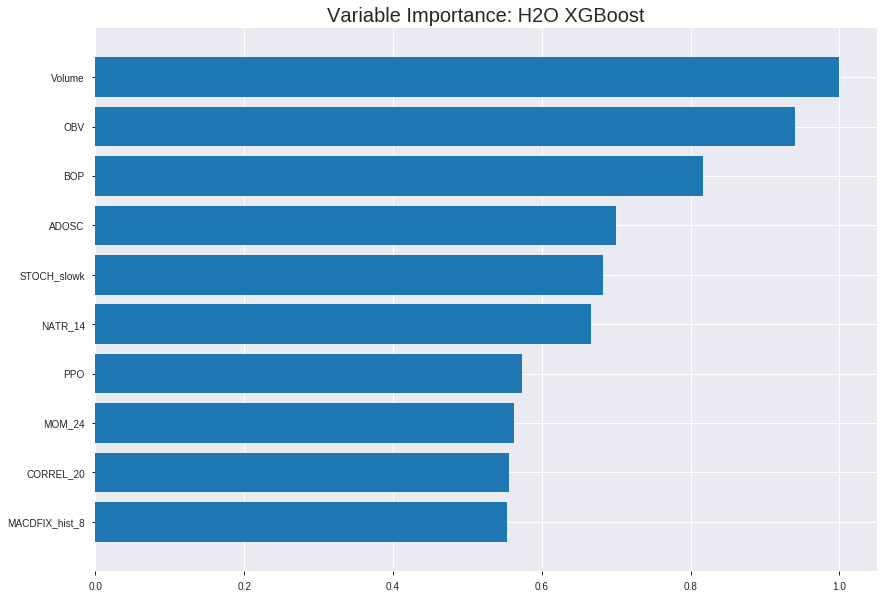

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_020934_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1573536568279844
RMSE: 0.39667827874485945
LogLoss: 0.49901844393540906
Mean Per-Class Error: 0.11072419728799265
AUC: 0.9508305961497928
pr_auc: 0.9529711324775295
Gini: 0.9016611922995856
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5239497423171997: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      602  60   0.0906   (60.0/662.0)
1      90   598  0.1308   (90.0/688.0)
Total  692  658  0.1111   (150.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.52395      0.888559  190
max f2                       0.446315     0.914516  242
max f0point5                 0.53432      0.904088  181
max accuracy                 0.52395      0.888889  190
max precision                0.856144     1         0
max recall                   0.28895      1         349
max specificity              0.856144     1         0
max absolute_mcc             0.52395      0.778654  190
max min_per_class_accuracy   0.510678     0.883686  197
max mean_per_class_accuracy  0.52395      0.889276  190

Gains/Lift Table: Avg response rate: 50.96 %, avg score: 50.85 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.792472           1.96221    1.96221            1                0.813644  1                           0.813644            0.0203488       0.0203488                  96.2209   96.2209
    2        0.02                        0.775437           1.96221    1.96221            1                0.784935  1                           0.799821            0.0188953       0.0392442                  96.2209   96.2209
    3        0.0303704                   0.757564           1.96221    1.96221            1                0.767954  1                           0.78894             0.0203488       0.059593                   96.2209   96.2209
    4        0.04                        0.747678           1.96221    1.96221            1                0.752538  1                           0.780177            0.0188953       0.0784884                  96.2209   96.2209
    5        0.0503704                   0.736337           1.96221    1.96221            1                0.744117  1                           0.772753            0.0203488       0.0988372                  96.2209   96.2209
    6        0.1                         0.701981           1.96221    1.96221            1                0.717263  1                           0.745213            0.0973837       0.196221                   96.2209   96.2209
    7        0.15037                     0.675502           1.93335    1.95254            0.985294         0.688566  0.995074                    0.726238            0.0973837       0.293605                   93.3353   95.2543
    8        0.2                         0.653306           1.90364    1.94041            0.970149         0.664047  0.988889                    0.710805            0.0944767       0.388081                   90.3636   94.0407
    9        0.3                         0.607966           1.875      1.9186             0.955556         0.631187  0.977778                    0.684266            0.1875          0.575581                   87.5      91.8605
    10       0.4                         0.561293           1.68605    1.86047            0.859259         0.585015  0.948148                    0.659453            0.168605        0.744186                   68.6047   86.0465
    11       0.5                         0.513353           1.32267    1.75291            0.674074         0.539432  0.893333                    0.635449            0.132267        0.876453                   32.2674   75.2907
    12       0.6                         0.46669            0.639535   1.56734            0.325926         0.490226  0.798765                    0.611245            0.0639535       0.940407                   -36.0465  56.7345
    13       0.7                         0.410043           0.377907   1.39743            0.192593         0.435532  0.712169                    0.586143            0.0377907       0.978198                   -62.2093  39.7425
    14       0.8                         0.363099           0.188953   1.24637            0.0962963        0.386422  0.635185                    0.561178            0.0188953       0.997093                   -81.1047  24.6366
    15       0.9                         0.306356           0.0145349  1.1095             0.00740741       0.337061  0.565432                    0.536276            0.00145349      0.998547                   -98.5465  10.9496
    16       1                           0.137093           0.0145349  1                  0.00740741       0.258612  0.50963                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26345010748037356
RMSE: 0.5132739107731598
LogLoss: 0.7224162848434762
Mean Per-Class Error: 0.47115384615384615
AUC: 0.5150290885585004
pr_auc: 0.4739109223024108
Gini: 0.03005817711700076
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2779306173324585: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    202  0.9902   (202.0/204.0)
1      0    182  0        (0.0/182.0)
Total  2    384  0.5233   (202.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.277931     0.64311    383
max f2                       0.277931     0.818345   383
max f0point5                 0.314684     0.531287   377
max accuracy                 0.614321     0.541451   106
max precision                0.614321     0.523364   106
max recall                   0.277931     1          383
max specificity              0.796345     0.995098   0
max absolute_mcc             0.750784     0.0835953  2
max min_per_class_accuracy   0.537844     0.5        191
max mean_per_class_accuracy  0.614321     0.528846   106

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 53.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.747768           0.53022   0.53022            0.25             0.770686  0.25                        0.770686            0.00549451      0.00549451                 -46.978   -46.978
    2        0.0207254                   0.737585           1.59066   1.06044            0.75             0.744469  0.5                         0.757578            0.0164835       0.021978                   59.0659   6.04396
    3        0.0310881                   0.72826            0         0.70696            0                0.732112  0.333333                    0.749089            0               0.021978                   -100      -29.304
    4        0.0414508                   0.725047           0.53022   0.662775           0.25             0.725951  0.3125                      0.743305            0.00549451      0.0274725                  -46.978   -33.7225
    5        0.0518135                   0.711189           1.06044   0.742308           0.5              0.720153  0.35                        0.738674            0.010989        0.0384615                  6.04396   -25.7692
    6        0.101036                    0.688488           1.45113   1.08763            0.684211         0.699267  0.512821                    0.719476            0.0714286       0.10989                    45.1128   8.76303
    7        0.150259                    0.664313           0.893002  1.02387            0.421053         0.67672   0.482759                    0.70547             0.043956        0.153846                   -10.6998  2.38727
    8        0.202073                    0.638282           1.27253   1.08763            0.6              0.649394  0.512821                    0.691091            0.0659341       0.21978                    27.2527   8.76303
    9        0.300518                    0.606312           1.06044   1.07872            0.5              0.622522  0.508621                    0.668629            0.104396        0.324176                   6.04396   7.8723
    10       0.401554                    0.569364           0.761341  0.998866           0.358974         0.586108  0.470968                    0.647866            0.0769231       0.401099                   -23.8659  -0.113435
    11       0.5                         0.536886           1.00463   1                  0.473684         0.553845  0.471503                    0.629354            0.0989011       0.5                        0.462695  0
    12       0.601036                    0.505919           1.19639   1.03301            0.564103         0.523577  0.487069                    0.611572            0.120879        0.620879                   19.6393   3.30144
    13       0.699482                    0.465003           0.893002  1.01331            0.421053         0.48291   0.477778                    0.593464            0.0879121       0.708791                   -10.6998  1.33089
    14       0.800518                    0.423489           0.978867  1.00896            0.461538         0.446303  0.475728                    0.57489             0.0989011       0.807692                   -2.11327  0.896191
    15       0.898964                    0.3798             1.06044   1.0146             0.5              0.403008  0.478386                    0.556068            0.104396        0.912088                   6.04396   1.45992
    16       1                           0.269845           0.870104  1                  0.410256         0.336773  0.471503                    0.533911           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 02:09:42  4.622 sec   0                  0.5              0.693147            0.5             0                  1                0.49037                          0.5                0.693147              0.5               0                    1                  0.528497
    2019-09-06 02:09:42  4.685 sec   5                  0.485044         0.663594            0.791022        0.78009            1.70058          0.308889                         0.499628           0.69241               0.533371          0.472347             1.06044            0.497409
    2019-09-06 02:09:42  4.742 sec   10                 0.47179          0.637882            0.835627        0.835509           1.96221          0.237037                         0.500567           0.694323              0.525089          0.480648             1.27253            0.512953
    2019-09-06 02:09:42  4.785 sec   15                 0.460592         0.61643             0.866951        0.864439           1.96221          0.206667                         0.502921           0.699146              0.509063          0.466154             1.06044            0.523316
    2019-09-06 02:09:42  4.846 sec   20                 0.448913         0.594336            0.887596        0.890131           1.96221          0.188148                         0.504647           0.702854              0.510248          0.463693             0.53022            0.502591
    2019-09-06 02:09:42  4.906 sec   25                 0.440125         0.577825            0.901982        0.904956           1.96221          0.174815                         0.508359           0.710746              0.505629          0.462307             0.53022            0.510363
    2019-09-06 02:09:42  4.975 sec   30                 0.430066         0.55924             0.915748        0.918664           1.96221          0.168148                         0.508267           0.710651              0.514194          0.475164             0                  0.520725
    2019-09-06 02:09:42  5.044 sec   35                 0.420697         0.541974            0.923672        0.927868           1.96221          0.154815                         0.51134            0.717584              0.516457          0.476383             0.53022            0.515544
    2019-09-06 02:09:42  5.107 sec   40                 0.413273         0.528377            0.931752        0.935359           1.96221          0.156296                         0.509844           0.71445               0.524025          0.4816               0.53022            0.520725
    2019-09-06 02:09:42  5.161 sec   45                 0.404722         0.513229            0.942794        0.945474           1.96221          0.128889                         0.512507           0.720658              0.518961          0.473974             0.53022            0.512953
    2019-09-06 02:09:42  5.211 sec   50                 0.396678         0.499018            0.950831        0.952971           1.96221          0.111111                         0.513274           0.722416              0.515029          0.473911             0.53022            0.523316

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  --------------------
Volume                   382.8939208984375      1.0                   0.06324200795035975
OBV                      359.8292236328125      0.9397621743079517    0.05943244689903085
BOP                      312.8492431640625      0.8170650566349568    0.05167283480766908
ADOSC                    267.8150939941406      0.6994498459670727    0.044234612719527514
STOCH_slowk              261.0532531738281      0.6817900178756623    0.04311776973096855
---                      ---                    ---                   ---
MA_8_5                   73.0451431274414       0.19077122707000774   0.012064755459061315
BBANDS_lowerband_14_3_3  49.83391189575195      0.13015070016995747   0.00823099161489334
MAVP_8_0                 34.86687469482422      0.09106144754926168   0.005758908789881675
HT_TRENDMODE             26.35958480834961      0.0688430486086027    0.004353772627432254
CDLCLOSINGMARUBOZU       9.979256629943848      0.026062718902739757  0.001648258676055059


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5492227979274611)

('F1', 0.6476868327402135)

('auc', 0.5369532428355958)

('logloss', 0.7264151671298708)

('mean_per_class_error', 0.44246929541047186)

('rmse', 0.5152189344301601)

('mse', 0.2654505503953496)

xgboost prediction progress: |████████████████████████████████████████████| 100%


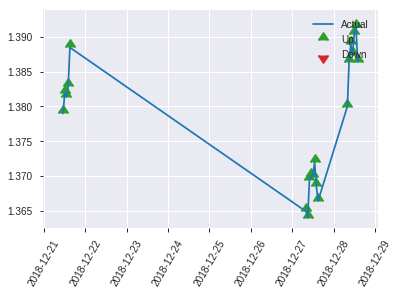


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2654505503953496
RMSE: 0.5152189344301601
LogLoss: 0.7264151671298708
Mean Per-Class Error: 0.44246929541047186
AUC: 0.5369532428355958
pr_auc: 0.47788754601360633
Gini: 0.07390648567119151
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.400959849357605: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      3    99   0.9706   (99.0/102.0)
1      0    91   0        (0.0/91.0)
Total  3    190  0.513    (99.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.40096      0.647687  189
max f2                       0.40096      0.8213    189
max f0point5                 0.533615     0.552448  155
max accuracy                 0.563865     0.549223  123
max precision                0.777653     1         0
max recall                   0.40096      1         189
max specificity              0.777653     1         0
max absolute_mcc             0.533615     0.143588  155
max min_per_class_accuracy   0.589963     0.527473  95
max mean_per_class_accuracy  0.563865     0.557531  123

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 59.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.758191           1.06044   1.06044            0.5              0.772309  0.5                         0.772309            0.010989        0.010989                   6.04396   6.04396
    2        0.0207254                   0.735091           0         0.53022            0                0.754143  0.25                        0.763226            0               0.010989                   -100      -46.978
    3        0.0310881                   0.72075            0         0.35348            0                0.731656  0.166667                    0.752703            0               0.010989                   -100      -64.652
    4        0.0414508                   0.715068           1.06044   0.53022            0.5              0.717205  0.25                        0.743828            0.010989        0.021978                   6.04396   -46.978
    5        0.0518135                   0.706212           1.06044   0.636264           0.5              0.711351  0.3                         0.737333            0.010989        0.032967                   6.04396   -36.3736
    6        0.103627                    0.690209           1.27253   0.954396           0.6              0.699836  0.45                        0.718585            0.0659341       0.0989011                  27.2527   -4.56044
    7        0.150259                    0.676194           1.41392   1.09701            0.666667         0.684875  0.517241                    0.708123            0.0659341       0.164835                   41.3919   9.70064
    8        0.202073                    0.659043           0.636264  0.978867           0.3              0.666156  0.461538                    0.697362            0.032967        0.197802                   -36.3736  -2.11327
    9        0.300518                    0.628175           1.3395    1.09701            0.631579         0.639819  0.517241                    0.678512            0.131868        0.32967                    33.9503   9.70064
    10       0.398964                    0.60942            1.00463   1.07421            0.473684         0.621467  0.506494                    0.664436            0.0989011       0.428571                   0.462695  7.42115
    11       0.502591                    0.589785           0.954396  1.04951            0.45             0.598566  0.494845                    0.650854            0.0989011       0.527473                   -4.56044  4.95072
    12       0.601036                    0.572977           0.893002  1.02387            0.421053         0.580774  0.482759                    0.639376            0.0879121       0.615385                   -10.6998  2.38727
    13       0.699482                    0.555432           1.22788   1.05258            0.578947         0.562834  0.496296                    0.628603            0.120879        0.736264                   22.7877   5.25845
    14       0.797927                    0.535012           1.11625   1.06044            0.526316         0.54278   0.5                         0.618015            0.10989         0.846154                   11.6252   6.04396
    15       0.896373                    0.501218           0.669751  1.01753            0.315789         0.52002   0.479769                    0.607252            0.0659341       0.912088                   -33.0249  1.75316
    16       1                           0.365742           0.848352  1                  0.4              0.441923  0.471503                    0.59012       

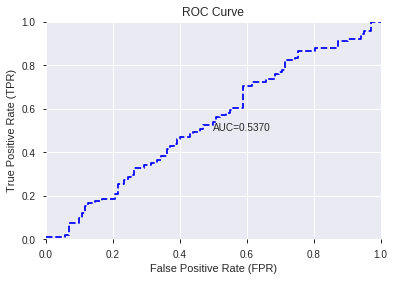

This function is available for GLM models only


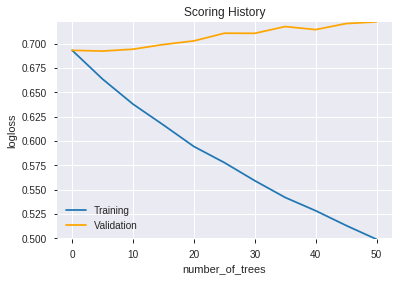

--2019-09-06 02:09:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

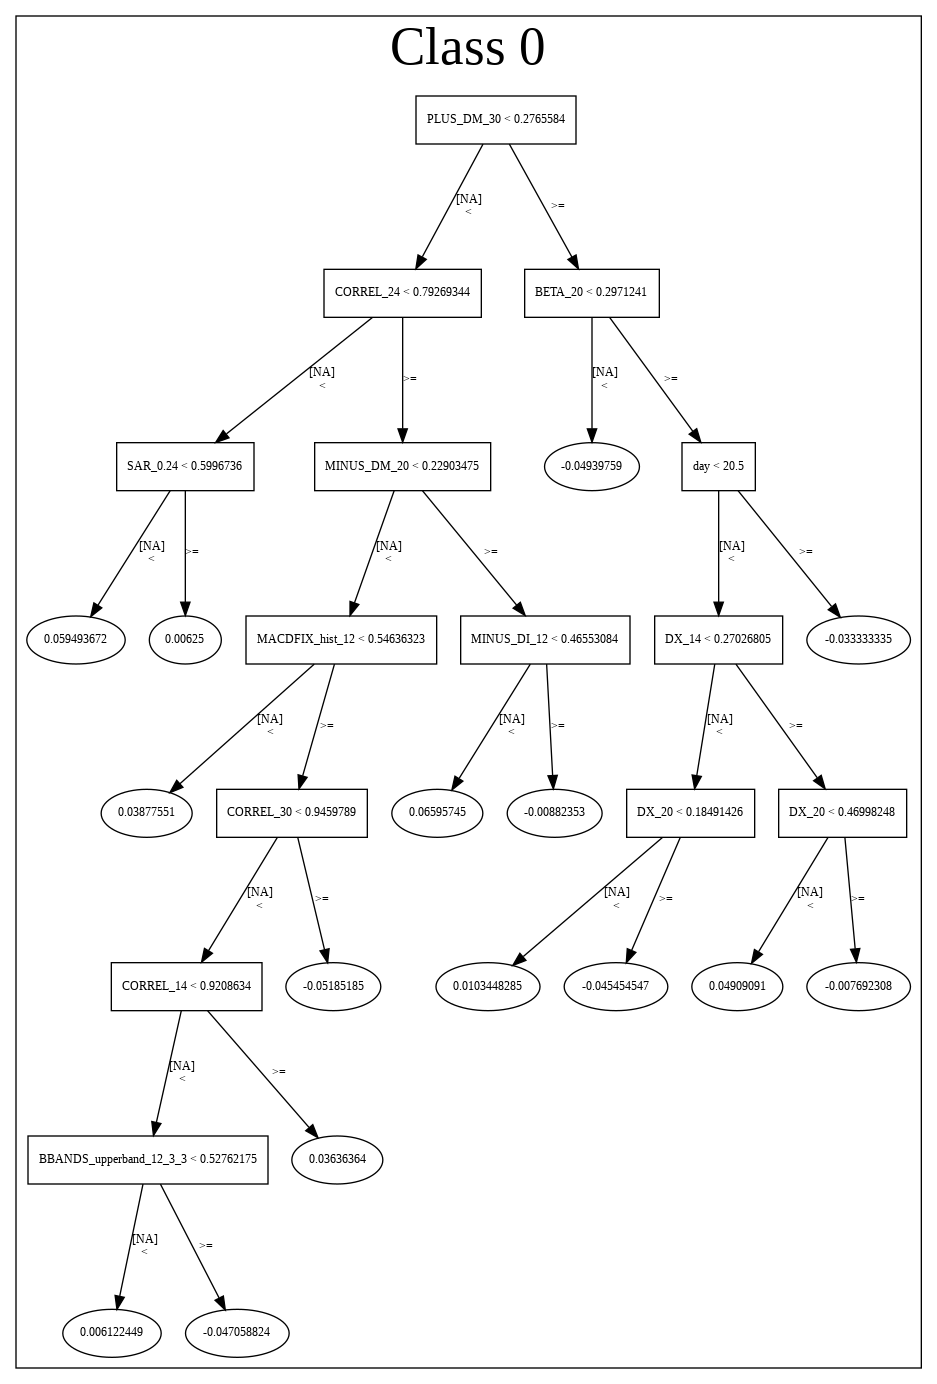

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_020934_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_020934_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b1e5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['Volume',
 'OBV',
 'BOP',
 'ADOSC',
 'STOCH_slowk',
 'NATR_14',
 'PPO',
 'MOM_24',
 'CORREL_20',
 'MACDFIX_hist_8',
 'HT_DCPERIOD',
 'TRIX_14',
 'PLUS_DI_8',
 'ADXR_14',
 'PLUS_DI_14',
 'SAREXT',
 'BBANDS_lowerband_14_6_5',
 'LINEARREG_SLOPE_20',
 'MACDEXT_signal',
 'AD',
 'BBANDS_upperband_12_1_3',
 'BBANDS_middleband_14_5_5',
 'BBANDS_upperband_20_3_5',
 'MAX_30',
 'BBANDS_lowerband_8_0_5',
 'BBANDS_upperband_20_2_5',
 'LINEARREG_INTERCEPT_30',
 'aroonup_30',
 'BBANDS_lowerband_24_6_5',
 'AROONOSC_24',
 'TSF_12',
 'BBANDS_middleband_30_2_4',
 'TYPPRICE',
 'MINMAX_min_24',
 'MA_8_5',
 'BBANDS_lowerband_14_3_3',
 'MAVP_8_0',
 'HT_TRENDMODE',
 'CDLCLOSINGMARUBOZU']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 937] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_021008_model_2  0.566150  1.825166              0.485294  0.682971  0.466449
1               DeepLearning_1_AutoML_20190906_021008  0.565395  1.210290              0.472958  0.626495  0.392496
2  DeepLearning_grid_1_AutoML_20190906_021008_model_7  0.524833  0.695182              0.500000  0.500986  0.250987
3  DeepLearning_grid_1_AutoML_20190906_021008_model_3  0.521547  0.727250              0.495098  0.512982  0.263150
4  DeepLearning_grid_1_AutoML_20190906_021008_model_6  0.520470  0.691580              0.500000  0.499218  0.249218
5  DeepLearning_grid_1_AutoML_20190906_021008_model_8  0.500000  0.692951              0.500000  0.499902  0.249902
6  DeepLearning_grid_1_AutoML_20190906_021008_model_9  0.500000  0.692026              0.500000  0.499439  0.249440
7  DeepLearning_grid_1_AutoML_20190906_021008_model_4  0.492566  1.061345              0.481577  0.595548  0.354677
8  DeepLearning_grid_1_AutoML_20190906_021008_model_1  0.486641  1.896427              0.495098  0.653179  0.426643
9  DeepLearning_grid_1_AutoML_20190906_021008_model_5  0.481577  0.695451              0.500000  0.501148  0.251149

variable  relative_importance  scaled_importance  percentage
0                         OBV             1.000000           1.000000    0.002472
1                HT_TRENDMODE             0.784443           0.784443    0.001939
2                    CORREL_8             0.778279           0.778279    0.001924
3                   dayofweek             0.774004           0.774004    0.001913
4                        hour             0.763863           0.763863    0.001888
...                       ...                  ...                ...         ...
1031           CDL3LINESTRIKE             0.320168           0.320168    0.000791
1032  BBANDS_lowerband_14_5_5             0.319582           0.319582    0.000790
1033  BBANDS_lowerband_20_7_2             0.318417           0.318417    0.000787
1034                MAVP_14_3             0.316770           0.316770    0.000783
1035   BBANDS_lowerband_8_4_2             0.313232           0.313232    0.000774

[1036 rows x 4 columns]

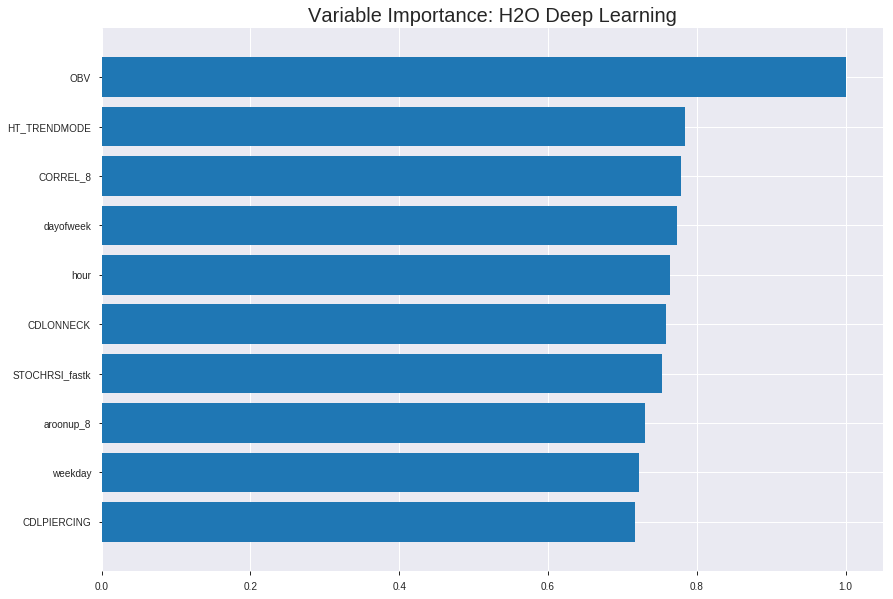

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_021008_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2796850674956461
RMSE: 0.5288525952433685
LogLoss: 0.8054570389628518
Mean Per-Class Error: 0.4234635178809808
AUC: 0.5820331711515492
pr_auc: 0.5646165332341467
Gini: 0.16406634230309836
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26092615740344643: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      14   648   0.9789   (648.0/662.0)
1      5    683   0.0073   (5.0/688.0)
Total  19   1331  0.4837   (653.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.260926     0.676573  384
max f2                       0.180855     0.839229  396
max f0point5                 0.614849     0.588942  212
max accuracy                 0.614849     0.577778  212
max precision                0.997111     1         0
max recall                   0.180855     1         396
max specificity              0.997111     1         0
max absolute_mcc             0.614849     0.154393  212
max min_per_class_accuracy   0.655962     0.567976  188
max mean_per_class_accuracy  0.614849     0.576536  212

Gains/Lift Table: Avg response rate: 50.96 %, avg score: 65.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.971019           0.981105  0.981105           0.5              0.982688  0.5                         0.982688            0.0101744       0.0101744                  -1.88953  -1.88953
    2        0.02                        0.963676           1.35845   1.16279            0.692308         0.967828  0.592593                    0.975533            0.0130814       0.0232558                  35.8453   16.2791
    3        0.0303704                   0.960148           1.26142   1.19647            0.642857         0.961851  0.609756                    0.970861            0.0130814       0.0363372                  26.142    19.6469
    4        0.04                        0.951308           1.20751   1.19913            0.615385         0.955972  0.611111                    0.967277            0.0116279       0.0479651                  20.7513   19.9128
    5        0.0503704                   0.94641            0.840947  1.12538            0.428571         0.948453  0.573529                    0.963401            0.00872093      0.056686                   -15.9053  12.5385
    6        0.1                         0.910861           1.11289   1.11919            0.567164         0.927558  0.57037                     0.945613            0.0552326       0.111919                   11.2895   11.9186
    7        0.15037                     0.876487           1.1831    1.14059            0.602941         0.892848  0.581281                    0.927938            0.059593        0.171512                   18.3097   14.0595
    8        0.2                         0.845401           1.20075   1.15552            0.61194          0.861806  0.588889                    0.911527            0.059593        0.231105                   20.0755   15.5523
    9        0.3                         0.783861           1.13372   1.14826            0.577778         0.814594  0.585185                    0.879216            0.113372        0.344477                   13.3721   14.8256
    10       0.4                         0.724431           1.16279   1.15189            0.592593         0.752074  0.587037                    0.847431            0.116279        0.460756                   16.2791   15.189
    11       0.5                         0.656771           1.06105   1.13372            0.540741         0.690832  0.577778                    0.816111            0.106105        0.56686                    6.10465   13.3721
    12       0.6                         0.589392           1.01744   1.11434            0.518519         0.623642  0.567901                    0.784033            0.101744        0.668605                   1.74419   11.4341
    13       0.7                         0.526191           0.799419  1.06935            0.407407         0.558573  0.544974                    0.751824            0.0799419       0.748547                   -20.0581  6.93522
    14       0.8                         0.466474           0.901163  1.04833            0.459259         0.497299  0.534259                    0.720008            0.0901163       0.838663                   -9.88372  4.83285
    15       0.9                         0.393718           0.857558  1.02713            0.437037         0.431689  0.523457                    0.687973            0.0857558       0.924419                   -14.2442  2.71318
    16       1                           0.133591           0.755814  1                  0.385185         0.325084  0.50963                     0.651684         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.30602687327492806
RMSE: 0.5531969570369382
LogLoss: 0.8785283547070095
Mean Per-Class Error: 0.46886446886446886
AUC: 0.508430295195001
pr_auc: 0.47201156428138635
Gini: 0.016860590390002095
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21319081618127947: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    200  0.9804   (200.0/204.0)
1      0    182  0        (0.0/182.0)
Total  4    382  0.5181   (200.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.213191     0.64539    381
max f2                       0.213191     0.81982    381
max f0point5                 0.354526     0.538309   332
max accuracy                 0.984599     0.533679   3
max precision                0.988682     1          0
max recall                   0.213191     1          381
max specificity              0.988682     1          0
max absolute_mcc             0.213191     0.0966538  381
max min_per_class_accuracy   0.590572     0.521978   191
max mean_per_class_accuracy  0.354526     0.531136   332

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 60.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.983172           1.59066   1.59066            0.75             0.985659  0.75                        0.985659            0.0164835       0.0164835                  59.0659   59.0659
    2        0.0207254                   0.973191           1.06044   1.32555            0.5              0.978504  0.625                       0.982082            0.010989        0.0274725                  6.04396   32.5549
    3        0.0310881                   0.967828           0.53022   1.06044            0.25             0.969828  0.5                         0.977997            0.00549451      0.032967                   -46.978   6.04396
    4        0.0414508                   0.962566           0.53022   0.927885           0.25             0.964988  0.4375                      0.974745            0.00549451      0.0384615                  -46.978   -7.21154
    5        0.0518135                   0.958621           0         0.742308           0                0.960002  0.35                        0.971796            0               0.0384615                  -100      -25.7692
    6        0.101036                    0.899889           1.00463   0.870104           0.473684         0.927639  0.410256                    0.950284            0.0494505       0.0879121                  0.462695  -12.9896
    7        0.150259                    0.839727           1.3395    1.02387            0.631579         0.877576  0.482759                    0.926466            0.0659341       0.153846                   33.9503   2.38727
    8        0.202073                    0.807528           1.06044   1.03325            0.5              0.824273  0.487179                    0.900262            0.0549451       0.208791                   6.04396   3.32488
    9        0.300518                    0.730761           0.837189  0.969022           0.394737         0.768935  0.456897                    0.857241            0.0824176       0.291209                   -16.2811  -3.09776
    10       0.401554                    0.658954           1.25077   1.03991            0.589744         0.691422  0.490323                    0.815519            0.126374        0.417582                   25.0775   3.99149
    11       0.5                         0.588018           1.06044   1.04396            0.5              0.624148  0.492228                    0.77784             0.104396        0.521978                   6.04396   4.3956
    12       0.601036                    0.541659           0.870104  1.01473            0.410256         0.562021  0.478448                    0.74156             0.0879121       0.60989                    -12.9896  1.4731
    13       0.699482                    0.487588           0.893002  0.997599           0.421053         0.513403  0.47037                     0.709449            0.0879121       0.697802                   -10.6998  -0.24013
    14       0.800518                    0.416246           0.978867  0.995235           0.461538         0.458322  0.469256                    0.677753            0.0989011       0.796703                   -2.11327  -0.476546
    15       0.898964                    0.324652           1.3395    1.03294            0.631579         0.36509   0.487032                    0.643513            0.131868        0.928571                   33.9503   3.29354
    16       1                           0.167323           0.70696   1                  0.333333         0.274286  0.471503                    0.606208    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 02:11:31  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 02:11:33  1 min 24.503 sec  390 obs/sec       0.701481  1             947        0.634354         3.5347              -0.610219      0.575368        0.419171           1.12126          0.467407                         0.675504           4.05513               -0.83117         0.546151          0.471095             1.06044            0.510363
    2019-09-06 02:11:46  1 min 36.687 sec  411 obs/sec       4.15111   6             5604       0.568305         1.14812             -0.292361      0.578032        0.549549           1.68189          0.458519                         0.636725           1.85723               -0.62696         0.550043          0.524962             1.59066            0.510363
    2019-09-06 02:11:58  1 min 48.755 sec  417 obs/sec       7.62741   11            10297      0.557938         0.999653            -0.245642      0.574186        0.578495           1.40158          0.476296                         0.636881           1.56331               -0.627757        0.478722          0.453525             1.06044            0.523316
    2019-09-06 02:12:10  2 min  0.896 sec  420 obs/sec       11.1578   16            15063      0.544013         0.913107            -0.18424       0.572095        0.586696           1.40158          0.487407                         0.60261            1.27903               -0.457289        0.482924          0.460229             1.06044            0.520725
    2019-09-06 02:12:21  2 min 12.410 sec  427 obs/sec       14.6785   21            19816      0.528853         0.805457            -0.119155      0.582033        0.564617           0.981105         0.483704                         0.553197           0.878528              -0.228097        0.50843           0.472012             1.59066            0.518135
    2019-09-06 02:12:33  2 min 24.488 sec  427 obs/sec       18.1748   26            24536      0.539171         0.88359             -0.163254      0.593134        0.602585           1.54174          0.48                             0.619395           1.35224               -0.539602        0.480419          0.475454             2.12088            0.528497
    2019-09-06 02:12:44  2 min 35.261 sec  435 obs/sec       21.6681   31            29252      0.515292         0.743257            -0.0624977     0.622901        0.624682           1.54174          0.445185                         0.568609           0.900194              -0.297482        0.537761          0.50251              1.06044            0.518135
    2019-09-06 02:12:55  2 min 45.677 sec  442 obs/sec       25.1059   36            33893      0.552828         0.923797            -0.22293       0.595092        0.587953           0.700789         0.476296                         0.621824           1.26045               -0.5517          0.490789          0.478992             1.59066            0.528497
    2019-09-06 02:13:07

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
OBV                      1.0                    1.0                  0.002471916355653715
HT_TRENDMODE             0.7844431400299072     0.7844431400299072   0.0019390778279202853
CORREL_8                 0.7782787084579468     0.7782787084579468   0.0019238398686942482
dayofweek                0.7740044593811035     0.7740044593811035   0.0019132742824930615
hour                     0.763863205909729      0.763863205909729    0.0018882059521703408
---                      ---                    ---                  ---
CDL3LINESTRIKE           0.320168137550354      0.320168137550354    0.0007914288557699084
BBANDS_lowerband_14_5_5  0.3195818364620209     0.3195818364620209   0.0007899795685203202
BBANDS_lowerband_20_7_2  0.3184165060520172     0.3184165060520172   0.0007870989692200915
MAVP_14_3                0.316770076751709      0.316770076751709    0.0007830291337042321
BBANDS_lowerband_8_4_2   0.3132316470146179     0.3132316470146179   0.0007742824313637852


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5803108808290155)

('F1', 0.6476868327402135)

('auc', 0.566149536737772)

('logloss', 1.825166346864136)

('mean_per_class_error', 0.42490842490842495)

('rmse', 0.6829709657755191)

('mse', 0.46644934009234523)

deeplearning prediction progress: |███████████████████████████████████████| 100%


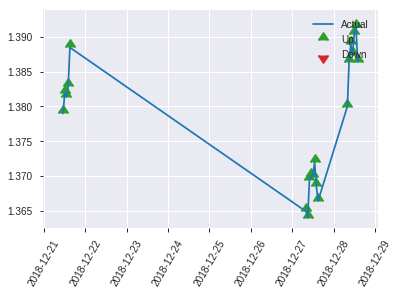


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.46644934009234523
RMSE: 0.6829709657755191
LogLoss: 1.825166346864136
Mean Per-Class Error: 0.42490842490842495
AUC: 0.566149536737772
pr_auc: 0.5250453069369997
Gini: 0.13229907347554404
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.653815980289735: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      3    99   0.9706   (99.0/102.0)
1      0    91   0        (0.0/91.0)
Total  3    190  0.513    (99.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.653816     0.647687  189
max f2                       0.653816     0.8213    189
max f0point5                 0.948754     0.554622  125
max accuracy                 0.975032     0.580311  77
max precision                0.998994     1         0
max recall                   0.653816     1         189
max specificity              0.998994     1         0
max absolute_mcc             0.998045     0.153831  9
max min_per_class_accuracy   0.97052      0.549451  93
max mean_per_class_accuracy  0.975032     0.575092  77

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 93.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.998697           2.12088   2.12088            1                0.998886  1                           0.998886            0.021978        0.021978                   112.088   112.088
    2        0.0207254                   0.998525           1.06044   1.59066            0.5              0.998618  0.75                        0.998752            0.010989        0.032967                   6.04396   59.0659
    3        0.0310881                   0.99832            2.12088   1.7674             1                0.998521  0.833333                    0.998675            0.021978        0.0549451                  112.088   76.7399
    4        0.0414508                   0.998187           1.06044   1.59066            0.5              0.998229  0.75                        0.998563            0.010989        0.0659341                  6.04396   59.0659
    5        0.0518135                   0.998045           2.12088   1.6967             1                0.998113  0.8                         0.998473            0.021978        0.0879121                  112.088   69.6703
    6        0.103627                    0.996415           0.212088  0.954396           0.1              0.997463  0.45                        0.997968            0.010989        0.0989011                  -78.7912  -4.56044
    7        0.150259                    0.991791           0.942613  0.950739           0.444444         0.993925  0.448276                    0.996713            0.043956        0.142857                   -5.73871  -4.92611
    8        0.202073                    0.987972           1.48462   1.08763            0.7              0.989981  0.512821                    0.994987            0.0769231       0.21978                    48.4615   8.76303
    9        0.300518                    0.980155           1.00463   1.06044            0.473684         0.983239  0.5                         0.991138            0.0989011       0.318681                   0.462695  6.04396
    10       0.398964                    0.975064           1.56275   1.18439            0.736842         0.977811  0.558442                    0.98785             0.153846        0.472527                   56.2753   18.4387
    11       0.502591                    0.969165           0.848352  1.1151             0.4              0.972347  0.525773                    0.984653            0.0879121       0.56044                    -15.1648  11.5101
    12       0.601036                    0.954158           1.00463   1.09701            0.473684         0.961071  0.517241                    0.980791            0.0989011       0.659341                   0.462695  9.70064
    13       0.699482                    0.935899           1.00463   1.084              0.473684         0.947426  0.511111                    0.976095            0.0989011       0.758242                   0.462695  8.40049
    14       0.797927                    0.914702           0.893002  1.06044            0.421053         0.926768  0.5                         0.970009            0.0879121       0.846154                   -10.6998  6.04396
    15       0.896373                    0.867964           0.669751  1.01753            0.315789         0.896713  0.479769                    0.961959            0.0659341       0.912088                   -33.0249  1.75316
    16       1                           0.552186           0.848352  1                  0.4              0.738788  0.471503                    0.938833       

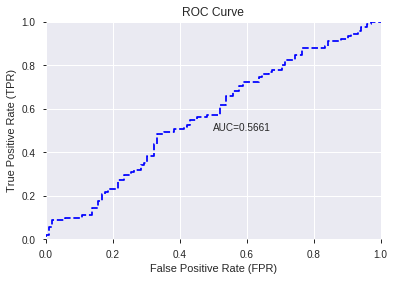

This function is available for GLM models only


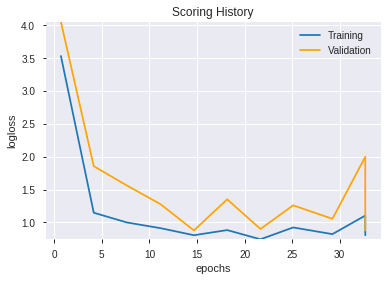

--2019-09-06 02:35:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.129.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.129.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


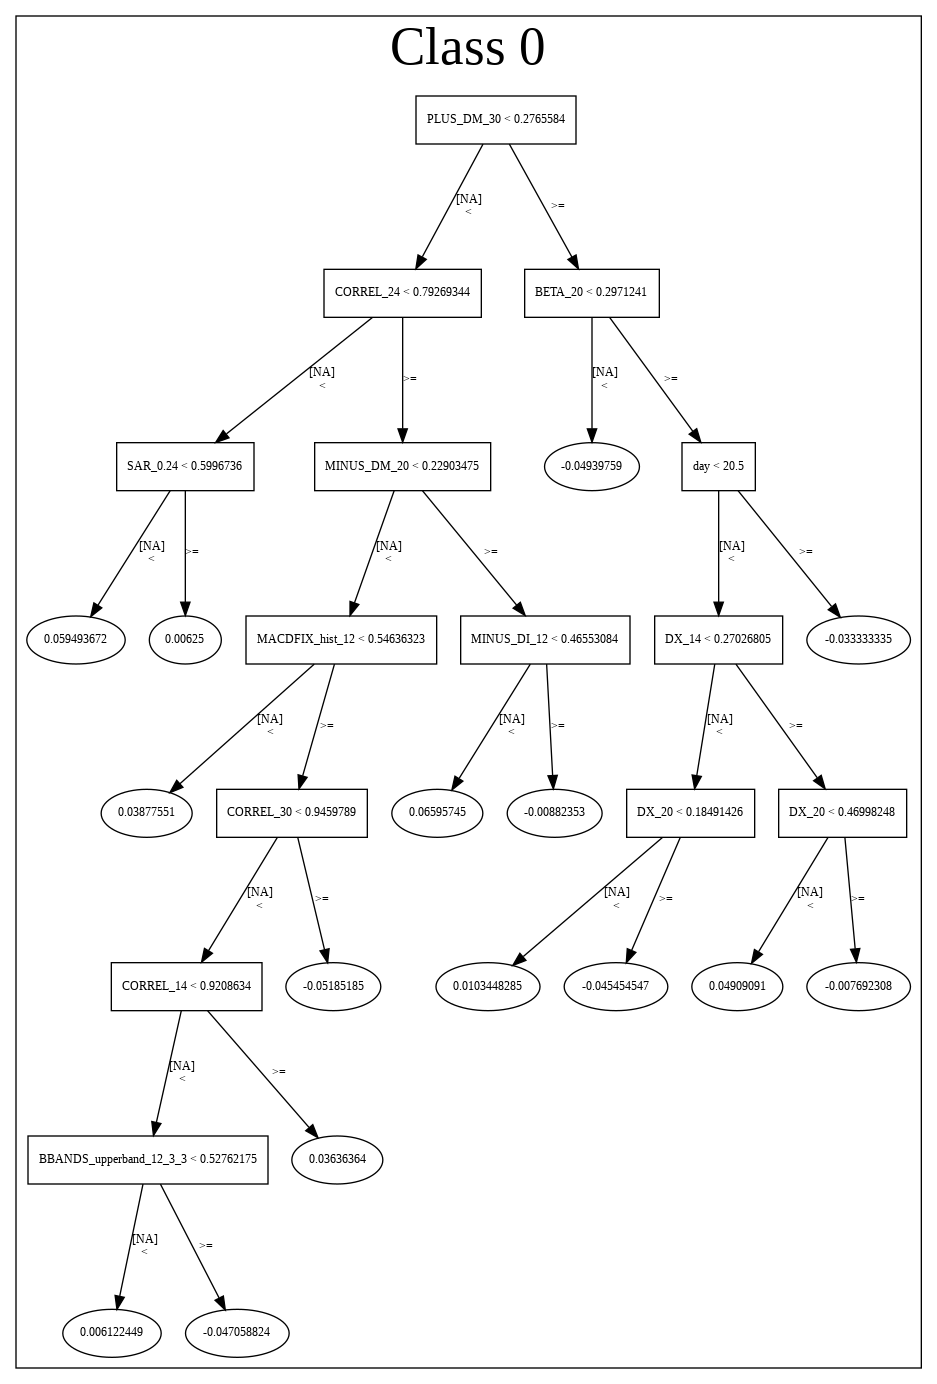

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_021008_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_021008_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_b1e5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['OBV',
 'HT_TRENDMODE',
 'CORREL_8',
 'dayofweek',
 'hour',
 'CDLONNECK',
 'STOCHRSI_fastk',
 'aroonup_8',
 'weekday',
 'CDLPIERCING',
 'Volume',
 'BOP',
 'SAREXT',
 'aroondown_8',
 'days_in_month',
 'aroondown_12',
 'CDLEVENINGDOJISTAR',
 'CDL3WHITESOLDIERS',
 'aroonup_24',
 'DX_8',
 'CDLLADDERBOTTOM',
 'aroondown_14',
 'AROONOSC_8',
 'day',
 'weekday_name',
 'HT_DCPERIOD',
 'CDLIDENTICAL3CROWS',
 'STOCHRSI_fastd',
 'aroonup_12',
 'quarter',
 'CORREL_24',
 'CDLSPINNINGTOP',
 'CDLHIKKAKEMOD',
 'STOCHF_fastk',
 'CDLBELTHOLD',
 'CDLSTALLEDPATTERN',
 'ADX_24',
 'aroonup_14',
 'CORREL_30',
 'BETA_14',
 'CDLDARKCLOUDCOVER',
 'CDLSTICKSANDWICH',
 'CDLLONGLINE',
 'aroondown_30',
 'month',
 'ADXR_8',
 'aroonup_20',
 'weekofyear',
 'CDLHIGHWAVE',
 'BETA_8',
 'ADXR_14',
 'TRANGE',
 'CDLLONGLEGGEDDOJI',
 'aroonup_30',
 'CDLGAPSIDESIDEWHITE',
 'STOCHF_fastd',
 'AROONOSC_12',
 'ADX_8',
 'STOCH_slowd',
 'week',
 'CCI_8',
 'dayofyear',
 'AROONOSC_14',
 'MFI_14',
 'CDLRICKSHAWMAN',
 'DX_12',
 'aroond

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190906_023607_model_1  0.538462  0.704137              0.480392  0.505416  0.255445

variable  relative_importance  scaled_importance    percentage
0                          OBV         8.201347e-03           1.000000  1.100896e-02
1             CDLDRAGONFLYDOJI         6.981459e-03           0.851258  9.371464e-03
2                    CDLTAKURI         6.490048e-03           0.791339  8.711826e-03
3          CDLRISEFALL3METHODS         6.309786e-03           0.769360  8.469853e-03
4                    CORREL_24         6.041323e-03           0.736626  8.109486e-03
...                        ...                  ...                ...           ...
1031  BBANDS_middleband_14_2_4         1.146090e-06           0.000140  1.538438e-06
1032  BBANDS_middleband_14_2_3         1.014739e-06           0.000124  1.362121e-06
1033  BBANDS_middleband_14_1_2         9.377802e-07           0.000114  1.258816e-06
1034  BBANDS_middleband_30_5_4         5.404598e-07           0.000066  7.254788e-07
1035  BBANDS_middleband_24_5_3         1.689791e-07           0.000021  2.268268e-07

[1036 rows x 4 columns]

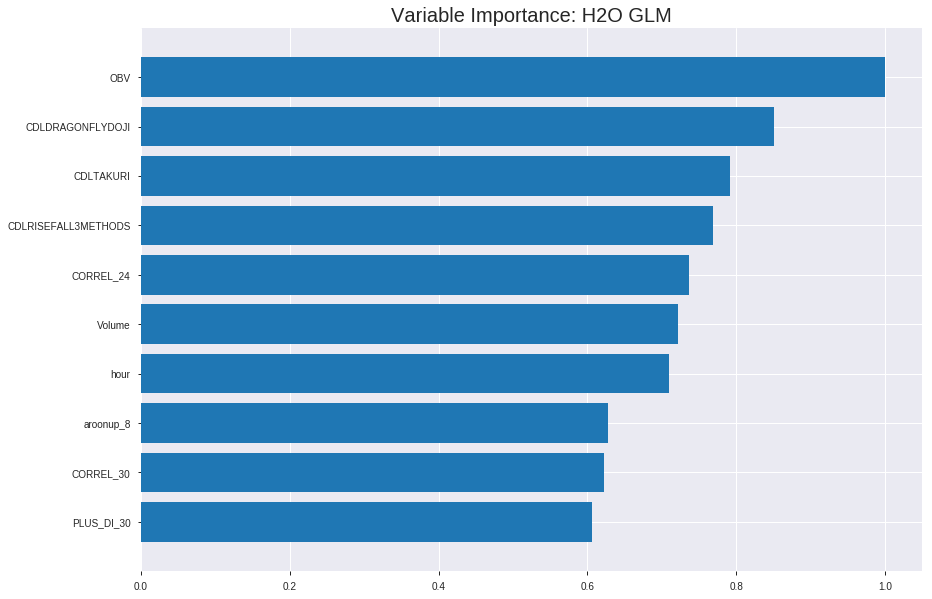

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_023607_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24551177034684762
RMSE: 0.4954914432629968
LogLoss: 0.684120829566374
Null degrees of freedom: 1349
Residual degrees of freedom: 313
Null deviance: 1870.9966158108023
Residual deviance: 1847.12623982921
AIC: 3921.12623982921
AUC: 0.5915104861940561
pr_auc: 0.5897194931733706
Gini: 0.1830209723881122
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43539495822111984: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      27   635   0.9592   (635.0/662.0)
1      9    679   0.0131   (9.0/688.0)
Total  36   1314  0.477    (644.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.435395     0.678322  370
max f2                       0.379427     0.838828  392
max f0point5                 0.512348     0.584511  188
max accuracy                 0.515523     0.577037  177
max precision                0.559153     0.75      39
max recall                   0.345124     1         398
max specificity              0.602282     0.998489  0
max absolute_mcc             0.515523     0.156144  177
max min_per_class_accuracy   0.512348     0.577035  188
max mean_per_class_accuracy  0.515523     0.577836  177

Gains/Lift Table: Avg response rate: 50.96 %, avg score: 50.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.575276           1.26142   1.26142            0.642857         0.583719  0.642857                    0.583719            0.0130814       0.0130814                  26.142    26.142
    2        0.02                        0.568568           1.50939   1.38081            0.769231         0.570939  0.703704                    0.577565            0.0145349       0.0276163                  50.9392   38.0814
    3        0.0303704                   0.56438            1.54174   1.43576            0.785714         0.566377  0.731707                    0.573745            0.0159884       0.0436047                  54.1736   43.5763
    4        0.04                        0.562668           1.35845   1.41715            0.692308         0.563547  0.722222                    0.57129             0.0130814       0.056686                   35.8453   41.7151
    5        0.0503704                   0.559649           1.54174   1.4428             0.785714         0.560903  0.735294                    0.569151            0.0159884       0.0726744                  54.1736   44.2801
    6        0.1                         0.552009           1.17147   1.30814            0.597015         0.555562  0.666667                    0.562407            0.0581395       0.130814                   17.1468   30.814
    7        0.15037                     0.545241           1.06767   1.22759            0.544118         0.548323  0.625616                    0.557689            0.0537791       0.184593                   6.76727   22.7589
    8        0.2                         0.538408           1.14218   1.2064             0.58209          0.541907  0.614815                    0.553773            0.056686        0.241279                   14.2182   20.6395
    9        0.3                         0.529087           1.09012   1.16764            0.555556         0.533848  0.595062                    0.547131            0.109012        0.350291                   9.01163   16.7636
    10       0.4                         0.520486           1.16279   1.16642            0.592593         0.524603  0.594444                    0.541499            0.116279        0.46657                    16.2791   16.6424
    11       0.5                         0.512292           1.07558   1.14826            0.548148         0.516061  0.585185                    0.536412            0.107558        0.574128                   7.55814   14.8256
    12       0.6                         0.503853           0.828488  1.09496            0.422222         0.508202  0.558025                    0.53171             0.0828488       0.656977                   -17.1512  9.49612
    13       0.7                         0.494091           0.915698  1.06935            0.466667         0.499099  0.544974                    0.527051            0.0915698       0.748547                   -8.43023  6.93522
    14       0.8                         0.484202           0.959302  1.0556             0.488889         0.48938   0.537963                    0.522342            0.0959302       0.844477                   -4.06977  5.55959
    15       0.9                         0.468045           0.901163  1.03844            0.459259         0.47704   0.529218                    0.517309            0.0901163       0.934593                   -9.88372  3.84367
    16       1                           0.31175            0.65407   1                  0.333333         0.440516  0.50963                     0.50963            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25185118703591347
RMSE: 0.5018477727716977
LogLoss: 0.696904537545105
Null degrees of freedom: 385
Residual degrees of freedom: -651
Null deviance: 536.100336915834
Residual deviance: 538.010302984821
AIC: 2612.010302984821
AUC: 0.496094591682827
pr_auc: 0.475451122049631
Gini: -0.007810816634346018
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37090961585639287: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    182  0        (0.0/182.0)
Total  0    386  0.5285   (204.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37091      0.640845  385
max f2                       0.37091      0.816876  385
max f0point5                 0.46285      0.534571  344
max accuracy                 0.570243     0.53886   3
max precision                0.581203     1         0
max recall                   0.37091      1         385
max specificity              0.581203     1         0
max absolute_mcc             0.570243     0.108337  3
max min_per_class_accuracy   0.502203     0.5       192
max mean_per_class_accuracy  0.475115     0.522678  310

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 50.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.570066           2.12088   2.12088            1                0.575289  1                           0.575289            0.021978        0.021978                   112.088   112.088
    2        0.0207254                   0.55969            0         1.06044            0                0.567103  0.5                         0.571196            0               0.021978                   -100      6.04396
    3        0.0310881                   0.555587           1.59066   1.23718            0.75             0.557905  0.583333                    0.566766            0.0164835       0.0384615                  59.0659   23.7179
    4        0.0414508                   0.554131           0.53022   1.06044            0.25             0.554728  0.5                         0.563756            0.00549451      0.043956                   -46.978   6.04396
    5        0.0518135                   0.550801           1.06044   1.06044            0.5              0.552437  0.5                         0.561492            0.010989        0.0549451                  6.04396   6.04396
    6        0.101036                    0.542087           0.781377  0.924486           0.368421         0.546155  0.435897                    0.55402             0.0384615       0.0934066                  -21.8623  -7.55142
    7        0.150259                    0.534298           1.00463   0.950739           0.473684         0.538687  0.448276                    0.548997            0.0494505       0.142857                   0.462695  -4.92611
    8        0.202073                    0.529591           1.27253   1.03325            0.6              0.532088  0.487179                    0.544662            0.0659341       0.208791                   27.2527   3.32488
    9        0.300518                    0.522424           0.948814  1.00559            0.447368         0.526186  0.474138                    0.538609            0.0934066       0.302198                   -5.11857  0.558924
    10       0.401554                    0.511681           0.870104  0.971499           0.410256         0.516604  0.458065                    0.533072            0.0879121       0.39011                    -12.9896  -2.85005
    11       0.5                         0.502199           1.11625   1                  0.526316         0.50701   0.471503                    0.527941            0.10989         0.5                        11.6252   0
    12       0.601036                    0.49339            0.978867  0.996448           0.461538         0.497342  0.469828                    0.522797            0.0989011       0.598901                   -2.11327  -0.355248
    13       0.699482                    0.483947           0.893002  0.981888           0.421053         0.489029  0.462963                    0.518045            0.0879121       0.686813                   -10.6998  -1.81115
    14       0.800518                    0.475482           1.30516   1.02269            0.615385         0.479069  0.482201                    0.513126            0.131868        0.818681                   30.5156   2.26893
    15       0.898964                    0.461779           1.00463   1.02071            0.473684         0.467917  0.481268                    0.508175            0.0989011       0.917582                   0.462695  2.07113
    16       1                           0.37091            0.815723  1                  0.384615         0.442918  0.471503                    0.501581        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 02:36:09  0.000 sec   2            3.9       1037          1.36824           1.39381
    2019-09-06 02:36:11  1.512 sec   4            2.9       1037          1.36487           1.39466
    2019-09-06 02:36:12  3.046 sec   6            2.1       1037          1.36083           1.39562
    2019-09-06 02:36:14  4.614 sec   8            1.5       1037          1.3561            1.39712
    2019-09-06 02:36:15  6.186 sec   10           1.1       1037          1.35065           1.39953

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5647668393782384)

('F1', 0.65)

('auc', 0.5384615384615384)

('logloss', 0.7041369009749546)

('mean_per_class_error', 0.44376212023270845)

('rmse', 0.5054157660694252)

('mse', 0.25544509659154396)

glm prediction progress: |████████████████████████████████████████████████| 100%


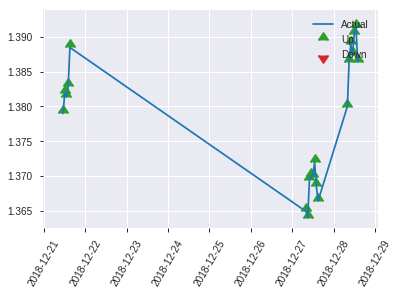


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25544509659154396
RMSE: 0.5054157660694252
LogLoss: 0.7041369009749546
Null degrees of freedom: 192
Residual degrees of freedom: -844
Null deviance: 268.05016845791704
Residual deviance: 271.7968437763325
AIC: 2345.7968437763325
AUC: 0.5384615384615384
pr_auc: 0.4950615444524054
Gini: 0.07692307692307687
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49021368211302496: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      4    98   0.9608   (98.0/102.0)
1      0    91   0        (0.0/91.0)
Total  4    189  0.5078   (98.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490214     0.65      188
max f2                       0.490214     0.822785  188
max f0point5                 0.535597     0.545087  162
max accuracy                 0.569166     0.564767  66
max precision                0.600213     0.75      3
max recall                   0.490214     1         188
max specificity              0.622494     0.990196  0
max absolute_mcc             0.490214     0.13741   188
max min_per_class_accuracy   0.562177     0.529412  96
max mean_per_class_accuracy  0.569166     0.556238  66

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 55.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.605315           1.06044   1.06044            0.5              0.616337  0.5                         0.616337            0.010989        0.010989                   6.04396   6.04396
    2        0.0207254                   0.596203           2.12088   1.59066            1                0.602553  0.75                        0.609445            0.021978        0.032967                   112.088   59.0659
    3        0.0310881                   0.592786           0         1.06044            0                0.594418  0.5                         0.604436            0               0.032967                   -100      6.04396
    4        0.0414508                   0.59048            0         0.79533            0                0.592292  0.375                       0.6014              0               0.032967                   -100      -20.467
    5        0.0518135                   0.587419           1.06044   0.848352           0.5              0.588631  0.4                         0.598846            0.010989        0.043956                   6.04396   -15.1648
    6        0.103627                    0.58429            1.27253   1.06044            0.6              0.585962  0.5                         0.592404            0.0659341       0.10989                    27.2527   6.04396
    7        0.150259                    0.579515           0.942613  1.02387            0.444444         0.581335  0.482759                    0.588969            0.043956        0.153846                   -5.73871  2.38727
    8        0.202073                    0.577837           1.48462   1.14201            0.7              0.578766  0.538462                    0.586353            0.0769231       0.230769                   48.4615   14.2012
    9        0.300518                    0.572765           0.893002  1.06044            0.421053         0.575151  0.5                         0.582683            0.0879121       0.318681                   -10.6998  6.04396
    10       0.398964                    0.566696           0.893002  1.01912            0.421053         0.569501  0.480519                    0.579431            0.0879121       0.406593                   -10.6998  1.91237
    11       0.502591                    0.562177           1.27253   1.07137            0.6              0.564495  0.505155                    0.576351            0.131868        0.538462                   27.2527   7.13719
    12       0.601036                    0.557929           0.893002  1.04216            0.421053         0.560108  0.491379                    0.573691            0.0879121       0.626374                   -10.6998  4.21561
    13       0.699482                    0.549757           1.00463   1.03687            0.473684         0.552913  0.488889                    0.570766            0.0989011       0.725275                   0.462695  3.68742
    14       0.797927                    0.541165           0.893002  1.01912            0.421053         0.545436  0.480519                    0.567641            0.0879121       0.813187                   -10.6998  1.91237
    15       0.896373                    0.525072           1.00463   1.01753            0.473684         0.533999  0.479769                    0.563946            0.0989011       0.912088                   0.462695  1.75316
    16       1                           0.481627           0.848352  1                  0.4              0.503121  0.471503                    0.557643        

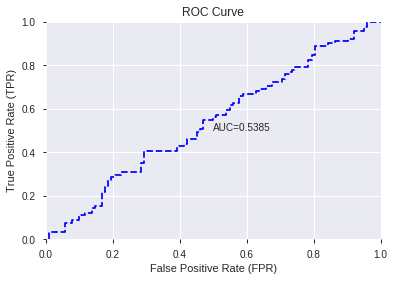

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


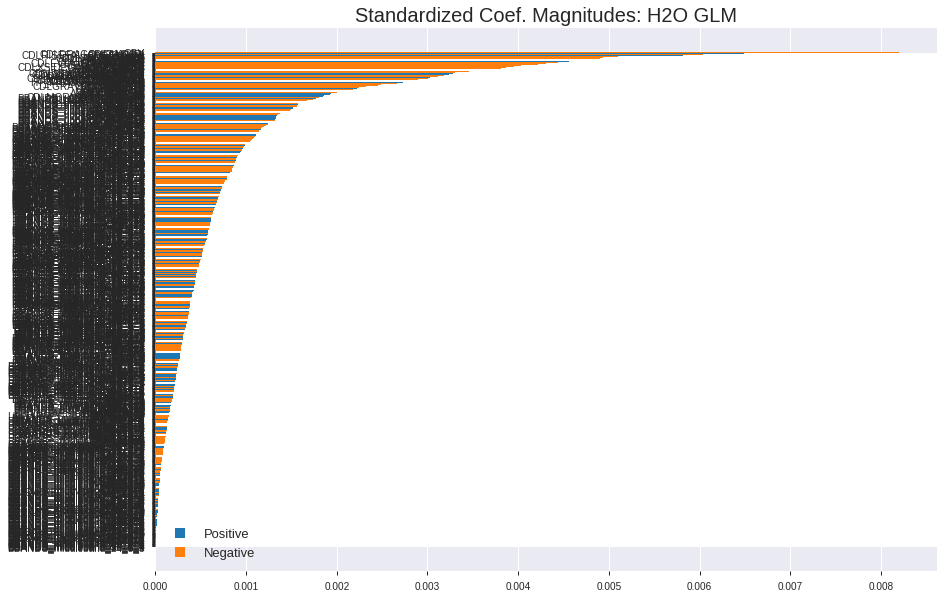

'log_likelihood'
--2019-09-06 02:36:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.224.192
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.224.192|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


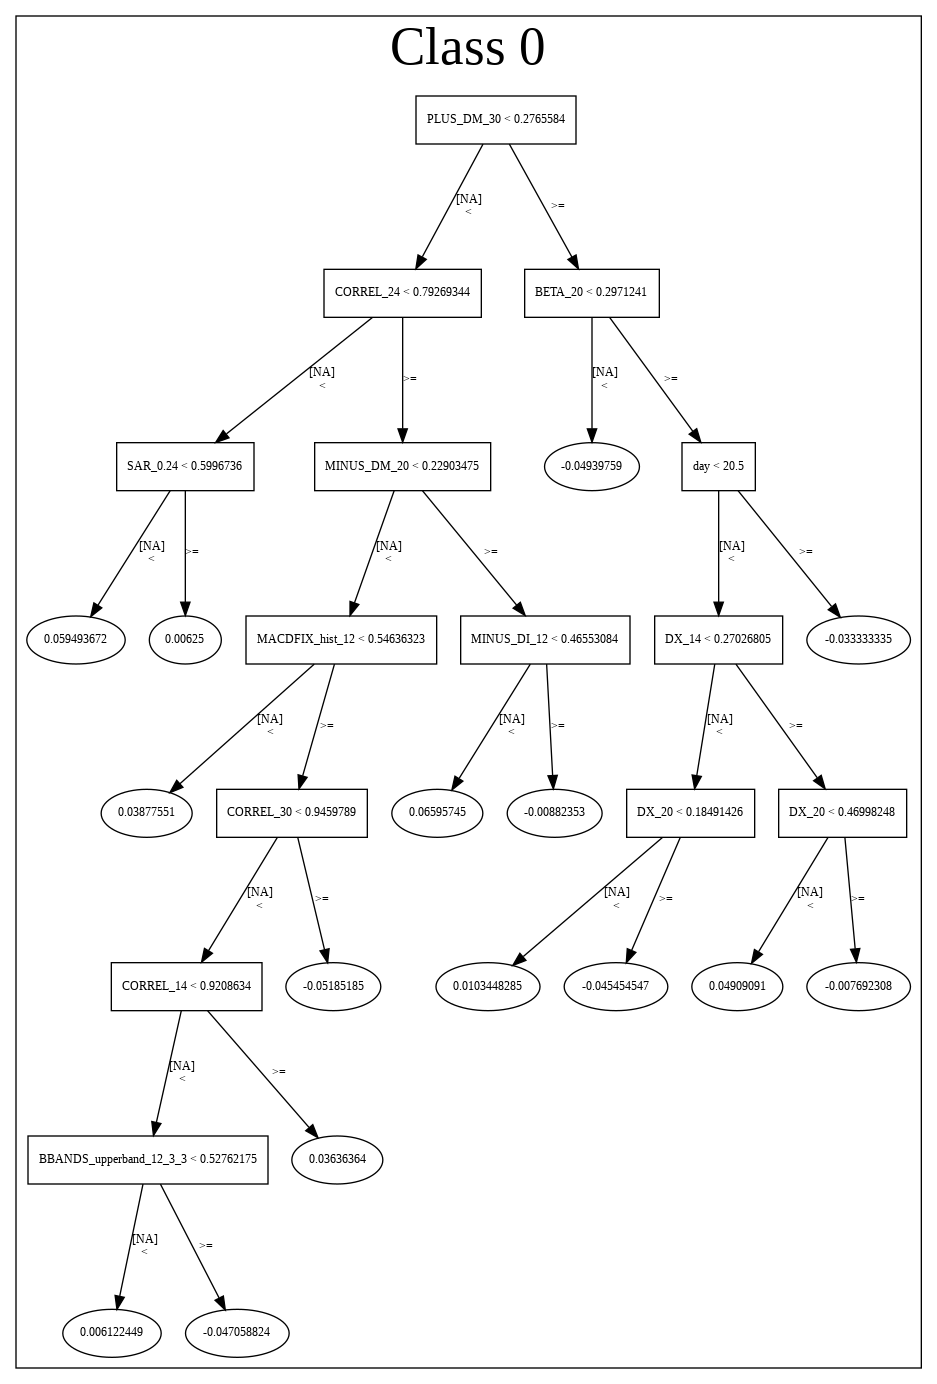

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_023607_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_023607_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b1e5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['OBV',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLRISEFALL3METHODS',
 'CORREL_24',
 'Volume',
 'hour',
 'aroonup_8',
 'CORREL_30',
 'PLUS_DI_30',
 'CDLHANGINGMAN',
 'CDL3LINESTRIKE',
 'PLUS_DI_24',
 'PLUS_DI_20',
 'TRANGE',
 'PLUS_DM_8',
 'weekday',
 'dayofweek',
 'day',
 'CDLHIKKAKEMOD',
 'CDLHAMMER',
 'CDLEVENINGDOJISTAR',
 'PLUS_DI_14',
 'CORREL_8',
 'CDLENGULFING',
 'PLUS_DI_12',
 'PLUS_DM_12',
 'PLUS_DM_14',
 'DIV',
 'PLUS_DI_8',
 'CDLXSIDEGAP3METHODS',
 'SUB',
 'CDLTASUKIGAP',
 'CDLDOJISTAR',
 'VAR_8',
 'PLUS_DM_20',
 'PLUS_DM_24',
 'CDLHIKKAKE',
 'PLUS_DM_30',
 'AROONOSC_8',
 'CDLHIGHWAVE',
 'CDLIDENTICAL3CROWS',
 'aroonup_12',
 'CDLSTALLEDPATTERN',
 'CDLONNECK',
 'CDLSEPARATINGLINES',
 'HT_TRENDMODE',
 'CDLLADDERBOTTOM',
 'CDLSPINNINGTOP',
 'ADXR_12',
 'STDDEV_8',
 'SIN',
 'CDLDARKCLOUDCOVER',
 'CORREL_14',
 'HT_DCPERIOD',
 'aroonup_24',
 'CDL3WHITESOLDIERS',
 'CDLBELTHOLD',
 'CDLSHOOTINGSTAR',
 'CDLRICKSHAWMAN',
 'SAREXT',
 'HT_PHASOR_quadrature',
 'BETA_30',
 'days_in_month',
 

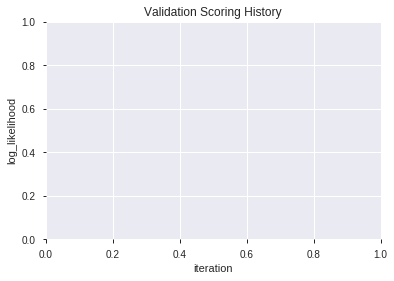

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190906_023654  0.593514  0.720426              0.500000  0.513108  0.263280
1  XGBoost_grid_1_AutoML_20190906_023654_model_3  0.567658  0.702099              0.472366  0.504298  0.254317
2               XGBoost_1_AutoML_20190906_023654  0.539862  0.707423              0.458845  0.506653  0.256698
3  XGBoost_grid_1_AutoML_20190906_023654_model_2  0.533613  0.699081              0.490789  0.502971  0.252980
4  XGBoost_grid_1_AutoML_20190906_023654_model_6  0.528765  0.729237              0.480392  0.516532  0.266805
5  XGBoost_grid_1_AutoML_20190906_023654_model_1  0.523971  0.695784              0.500000  0.501274  0.251276
6               XGBoost_3_AutoML_20190906_023654  0.518207  0.724326              0.495098  0.515010  0.265235
7  XGBoost_grid_1_AutoML_20190906_023654_model_4  0.509588  0.708316              0.500000  0.507441  0.257496
8  XGBoost_grid_1_AutoML_20190906_023654_model_7  0.493428  0.742740              0.495098  0.522482  0.272988
9  XGBoost_grid_1_AutoML_20190906_023654_model_5  0.468218  0.731794              0.500000  0.518262  0.268596

variable  relative_importance  scaled_importance  percentage
0                        OBV           153.095520           1.000000    0.031797
1                      ADOSC            87.318626           0.570354    0.018135
2                      DX_20            82.973999           0.541975    0.017233
3                  CORREL_24            81.982368           0.535498    0.017027
4                    BETA_20            77.857025           0.508552    0.016170
..                       ...                  ...                ...         ...
275                  TRIX_12             3.047232           0.019904    0.000633
276                  SAR_0.3             3.034330           0.019820    0.000630
277   BBANDS_lowerband_8_8_4             2.887630           0.018862    0.000600
278                  MA_30_6             2.777177           0.018140    0.000577
279  BBANDS_lowerband_30_1_3             2.363434           0.015438    0.000491

[280 rows x 4 columns]

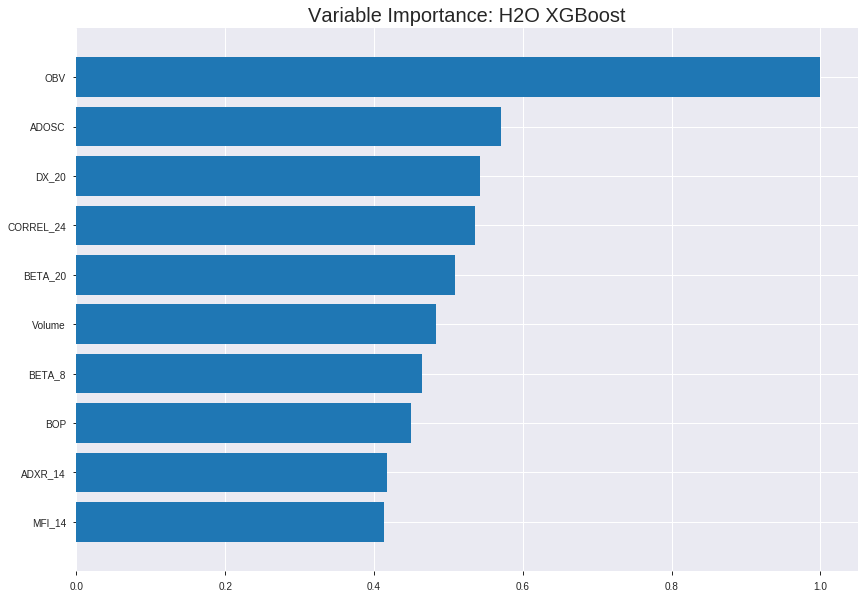

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190906_023654


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17199720271022506
RMSE: 0.4147254546205538
LogLoss: 0.5316685900754387
Mean Per-Class Error: 0.1375588421274503
AUC: 0.9348993097028034
pr_auc: 0.9360714425427209
Gini: 0.8697986194056069
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49509912729263306: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      553  109  0.1647   (109.0/662.0)
1      76   612  0.1105   (76.0/688.0)
Total  629  721  0.137    (185.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.495099     0.868701  214
max f2                       0.443265     0.910337  259
max f0point5                 0.550111     0.880838  169
max accuracy                 0.495099     0.862963  214
max precision                0.815723     1         0
max recall                   0.261669     1         393
max specificity              0.815723     1         0
max absolute_mcc             0.495099     0.726437  214
max min_per_class_accuracy   0.511468     0.853474  201
max mean_per_class_accuracy  0.495099     0.862441  214

Gains/Lift Table: Avg response rate: 50.96 %, avg score: 51.12 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.757522           1.96221    1.96221            1                0.773196  1                           0.773196            0.0203488       0.0203488                  96.2209   96.2209
    2        0.02                        0.736189           1.96221    1.96221            1                0.744627  1                           0.759441            0.0188953       0.0392442                  96.2209   96.2209
    3        0.0303704                   0.723746           1.96221    1.96221            1                0.72863   1                           0.74892             0.0203488       0.059593                   96.2209   96.2209
    4        0.04                        0.716609           1.96221    1.96221            1                0.720258  1                           0.74202             0.0188953       0.0784884                  96.2209   96.2209
    5        0.0503704                   0.71104            1.96221    1.96221            1                0.713514  1                           0.736151            0.0203488       0.0988372                  96.2209   96.2209
    6        0.1                         0.679803           1.96221    1.96221            1                0.694137  1                           0.7153              0.0973837       0.196221                   96.2209   96.2209
    7        0.15037                     0.656671           1.87564    1.93321            0.955882         0.667968  0.985222                    0.699445            0.0944767       0.290698                   87.5641   93.3211
    8        0.2                         0.632416           1.87435    1.9186             0.955224         0.64394   0.977778                    0.685671            0.0930233       0.383721                   87.4349   91.8605
    9        0.3                         0.592235           1.84593    1.89438            0.940741         0.612928  0.965432                    0.661423            0.184593        0.568314                   84.593    89.438
    10       0.4                         0.554391           1.5843     1.81686            0.807407         0.574241  0.925926                    0.639628            0.15843         0.726744                   58.4302   81.686
    11       0.5                         0.514053           1.19186    1.69186            0.607407         0.535063  0.862222                    0.618715            0.119186        0.84593                    19.186    69.186
    12       0.6                         0.473581           0.857558   1.55281            0.437037         0.490915  0.791358                    0.597415            0.0857558       0.931686                   -14.2442  55.281
    13       0.7                         0.428601           0.406977   1.38912            0.207407         0.450036  0.707937                    0.576361            0.0406977       0.972384                   -59.3023  38.912
    14       0.8                         0.389497           0.203488   1.24092            0.103704         0.409739  0.632407                    0.555533            0.0203488       0.992733                   -79.6512  24.0916
    15       0.9                         0.33811            0.0581395  1.1095             0.0296296        0.364343  0.565432                    0.53429             0.00581395      0.998547                   -94.186   10.9496
    16       1                           0.195016           0.0145349  1                  0.00740741       0.302912  0.50963                     0.51



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25881193998315394
RMSE: 0.5087356287730926
LogLoss: 0.7116316704127729
Mean Per-Class Error: 0.44947209653092
AUC: 0.5085110967463908
pr_auc: 0.46578406025219093
Gini: 0.017022193492781668
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4116392135620117: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      12   192  0.9412   (192.0/204.0)
1      2    180  0.011    (2.0/182.0)
Total  14   372  0.5026   (194.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411639     0.649819  371
max f2                       0.330919     0.819082  382
max f0point5                 0.48742      0.548276  316
max accuracy                 0.693626     0.533679  13
max precision                0.749971     1         0
max recall                   0.330919     1         382
max specificity              0.749971     1         0
max absolute_mcc             0.48742      0.129135  316
max min_per_class_accuracy   0.567719     0.494505  191
max mean_per_class_accuracy  0.497366     0.550528  305

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 55.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.715091           1.06044   1.06044            0.5              0.730355  0.5                         0.730355            0.010989        0.010989                   6.04396   6.04396
    2        0.0207254                   0.701134           1.06044   1.06044            0.5              0.707581  0.5                         0.718968            0.010989        0.021978                   6.04396   6.04396
    3        0.0310881                   0.695307           1.06044   1.06044            0.5              0.698428  0.5                         0.712121            0.010989        0.032967                   6.04396   6.04396
    4        0.0414508                   0.682315           1.06044   1.06044            0.5              0.689692  0.5                         0.706514            0.010989        0.043956                   6.04396   6.04396
    5        0.0518135                   0.672273           0         0.848352           0                0.674621  0.4                         0.700135            0               0.043956                   -100      -15.1648
    6        0.101036                    0.650125           1.11625   0.978867           0.526316         0.660003  0.461538                    0.680584            0.0549451       0.0989011                  11.6252   -2.11327
    7        0.150259                    0.63686            1.22788   1.06044            0.578947         0.642107  0.5                         0.667979            0.0604396       0.159341                   22.7877   6.04396
    8        0.202073                    0.618429           0.636264  0.951677           0.3              0.629949  0.448718                    0.658228            0.032967        0.192308                   -36.3736  -4.83235
    9        0.300518                    0.597071           0.725564  0.877605           0.342105         0.607138  0.413793                    0.641492            0.0714286       0.263736                   -27.4436  -12.2395
    10       0.401554                    0.582468           1.25077   0.971499           0.589744         0.589077  0.458065                    0.628303            0.126374        0.39011                    25.0775   -2.85005
    11       0.5                         0.567407           1.06044   0.989011           0.5              0.575509  0.466321                    0.617909            0.104396        0.494505                   6.04396   -1.0989
    12       0.601036                    0.548046           1.14201   1.01473            0.538462         0.558611  0.478448                    0.60794             0.115385        0.60989                    14.2012   1.4731
    13       0.699482                    0.528125           1.11625   1.02902            0.526316         0.538247  0.485185                    0.598132            0.10989         0.71978                    11.6252   2.90191
    14       0.800518                    0.494363           1.25077   1.05701            0.589744         0.512198  0.498382                    0.587286            0.126374        0.846154                   25.0775   5.70077
    15       0.898964                    0.44847            0.781377  1.02682            0.368421         0.476458  0.48415                     0.575149            0.0769231       0.923077                   -21.8623  2.68233
    16       1                           0.273441           0.761341  1                  0.358974         0.405171  0.471503                    0.557975     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 02:36:57  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.49037                          0.5                0.693147              0.5               0                    1                  0.528497
    2019-09-06 02:36:57  0.510 sec   5                  0.488644         0.670645            0.767997        0.762083           1.96221          0.319259                         0.500226           0.693598              0.517063          0.485154             0.53022            0.515544
    2019-09-06 02:36:58  0.893 sec   10                 0.478316         0.650499            0.817673        0.812898           1.96221          0.268148                         0.499877           0.692897              0.52754           0.489909             1.06044            0.512953
    2019-09-06 02:36:58  1.292 sec   15                 0.468295         0.631176            0.842105        0.84181            1.96221          0.247407                         0.500935           0.695055              0.518921          0.47333              1.59066            0.468912
    2019-09-06 02:36:59  1.712 sec   20                 0.458899         0.61328             0.865816        0.864465           1.96221          0.220741                         0.501731           0.696656              0.512794          0.474944             1.59066            0.497409
    2019-09-06 02:36:59  2.103 sec   25                 0.450576         0.597567            0.881492        0.879187           1.96221          0.192593                         0.502226           0.69769               0.517426          0.48034              2.12088            0.507772
    2019-09-06 02:36:59  2.466 sec   30                 0.44289          0.58318             0.894972        0.893549           1.96221          0.184444                         0.503537           0.700388              0.513844          0.479707             2.12088            0.5
    2019-09-06 02:37:00  2.850 sec   35                 0.435157         0.568813            0.906384        0.903369           1.96221          0.174074                         0.504659           0.702714              0.506976          0.474464             2.12088            0.510363
    2019-09-06 02:37:00  3.244 sec   40                 0.428237         0.556034            0.914604        0.913764           1.96221          0.157778                         0.506179           0.705938              0.503771          0.46955              1.59066            0.505181
    2019-09-06 02:37:01  3.638 sec   45                 0.421618         0.544014            0.925085        0.925166           1.96221          0.148889                         0.506079           0.705786              0.506626          0.468823             0.53022            0.497409
    2019-09-06 02:37:01  4.001 sec   50                 0.414725         0.531669            0.934899        0.936071           1.96221          0.137037                         0.508736           0.711632              0.508511          0.465784             1.06044            0.502591

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
OBV                      153.09552001953125     1.0                   0.03179654782641235
ADOSC                    87.3186264038086       0.5703538966566029    0.018135284953022315
DX_20                    82.9739990234375       0.5419753563843804    0.01723294534001283
CORREL_24                81.98236846923828      0.5354981547388149    0.017026992688108287
BETA_20                  77.85702514648438      0.5085519493748198    0.01617019638051169
---                      ---                    ---                   ---
TRIX_12                  3.047231674194336      0.019904120472013703  0.0006328823185310569
SAR_0.3                  3.034329891204834      0.019819847705652833  0.0006302027354849994
BBANDS_lowerband_8_8_4   2.8876304626464844     0.018861626142150294  0.0005997345977127912
MA_30_6                  2.777176856994629      0.01814015757378354   0.0005767943878734644
BBANDS_lowerband_30_1_3  2.363433599472046      0.015437640495100899  0.0004908636743294357


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6010362694300518)

('F1', 0.6408450704225352)

('auc', 0.5935143288084465)

('logloss', 0.7204257875122764)

('mean_per_class_error', 0.399967679379444)

('rmse', 0.5131081465836761)

('mse', 0.2632799700905352)

xgboost prediction progress: |████████████████████████████████████████████| 100%


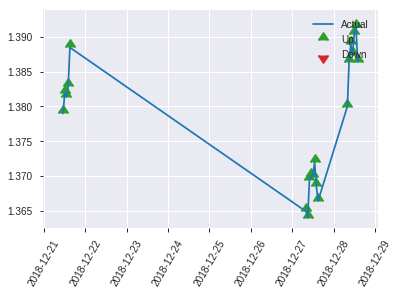


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2632799700905352
RMSE: 0.5131081465836761
LogLoss: 0.7204257875122764
Mean Per-Class Error: 0.399967679379444
AUC: 0.5935143288084465
pr_auc: 0.5660680267974939
Gini: 0.1870286576168929
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4576098322868347: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    102  1        (102.0/102.0)
1      0    91   0        (0.0/91.0)
Total  0    193  0.5285   (102.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45761      0.640845  192
max f2                       0.45761      0.816876  192
max f0point5                 0.620442     0.577342  91
max accuracy                 0.631447     0.601036  79
max precision                0.769775     1         0
max recall                   0.45761      1         192
max specificity              0.769775     1         0
max absolute_mcc             0.620442     0.199957  91
max min_per_class_accuracy   0.620442     0.582418  91
max mean_per_class_accuracy  0.620442     0.600032  91

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 61.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.739639           2.12088   2.12088            1                0.757518  1                           0.757518            0.021978        0.021978                   112.088   112.088
    2        0.0207254                   0.724138           2.12088   2.12088            1                0.737649  1                           0.747584            0.021978        0.043956                   112.088   112.088
    3        0.0310881                   0.715261           0         1.41392            0                0.720381  0.666667                    0.738516            0               0.043956                   -100      41.3919
    4        0.0414508                   0.71023            2.12088   1.59066            1                0.713736  0.75                        0.732321            0.021978        0.0659341                  112.088   59.0659
    5        0.0518135                   0.705862           2.12088   1.6967             1                0.708333  0.8                         0.727523            0.021978        0.0879121                  112.088   69.6703
    6        0.103627                    0.682455           0.848352  1.27253            0.4              0.693883  0.6                         0.710703            0.043956        0.131868                   -15.1648  27.2527
    7        0.150259                    0.671585           1.17827   1.24327            0.555556         0.676382  0.586207                    0.700052            0.0549451       0.186813                   17.8266   24.3274
    8        0.202073                    0.662948           1.48462   1.30516            0.7              0.667288  0.615385                    0.691651            0.0769231       0.263736                   48.4615   30.5156
    9        0.300518                    0.65204            1.22788   1.27984            0.578947         0.658238  0.603448                    0.680705            0.120879        0.384615                   22.7877   27.9841
    10       0.398964                    0.633817           1.11625   1.23947            0.526316         0.64276   0.584416                    0.671342            0.10989         0.494505                   11.6252   23.9475
    11       0.502591                    0.614555           0.954396  1.1807             0.45             0.624421  0.556701                    0.661668            0.0989011       0.593407                   -4.56044  18.0696
    12       0.601036                    0.600113           0.781377  1.11529            0.368421         0.605939  0.525862                    0.65254             0.0769231       0.67033                    -21.8623  11.529
    13       0.699482                    0.58063            1.00463   1.09972            0.473684         0.593733  0.518519                    0.644263            0.0989011       0.769231                   0.462695  9.97151
    14       0.797927                    0.554786           0.669751  1.04667            0.315789         0.563706  0.493506                    0.634324            0.0659341       0.835165                   -33.0249  4.66676
    15       0.896373                    0.522683           0.558126  0.993013           0.263158         0.539227  0.468208                    0.62388             0.0549451       0.89011                    -44.1874  -0.698723
    16       1                           0.45761            1.06044   1                  0.5              0.50097   0.471503                    0.611143        

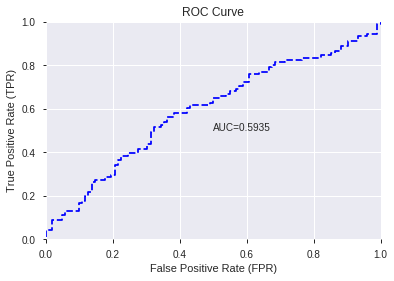

This function is available for GLM models only


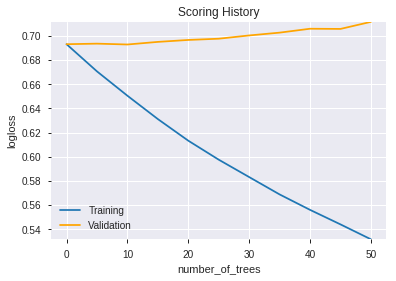

--2019-09-06 02:37:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.99.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.99.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


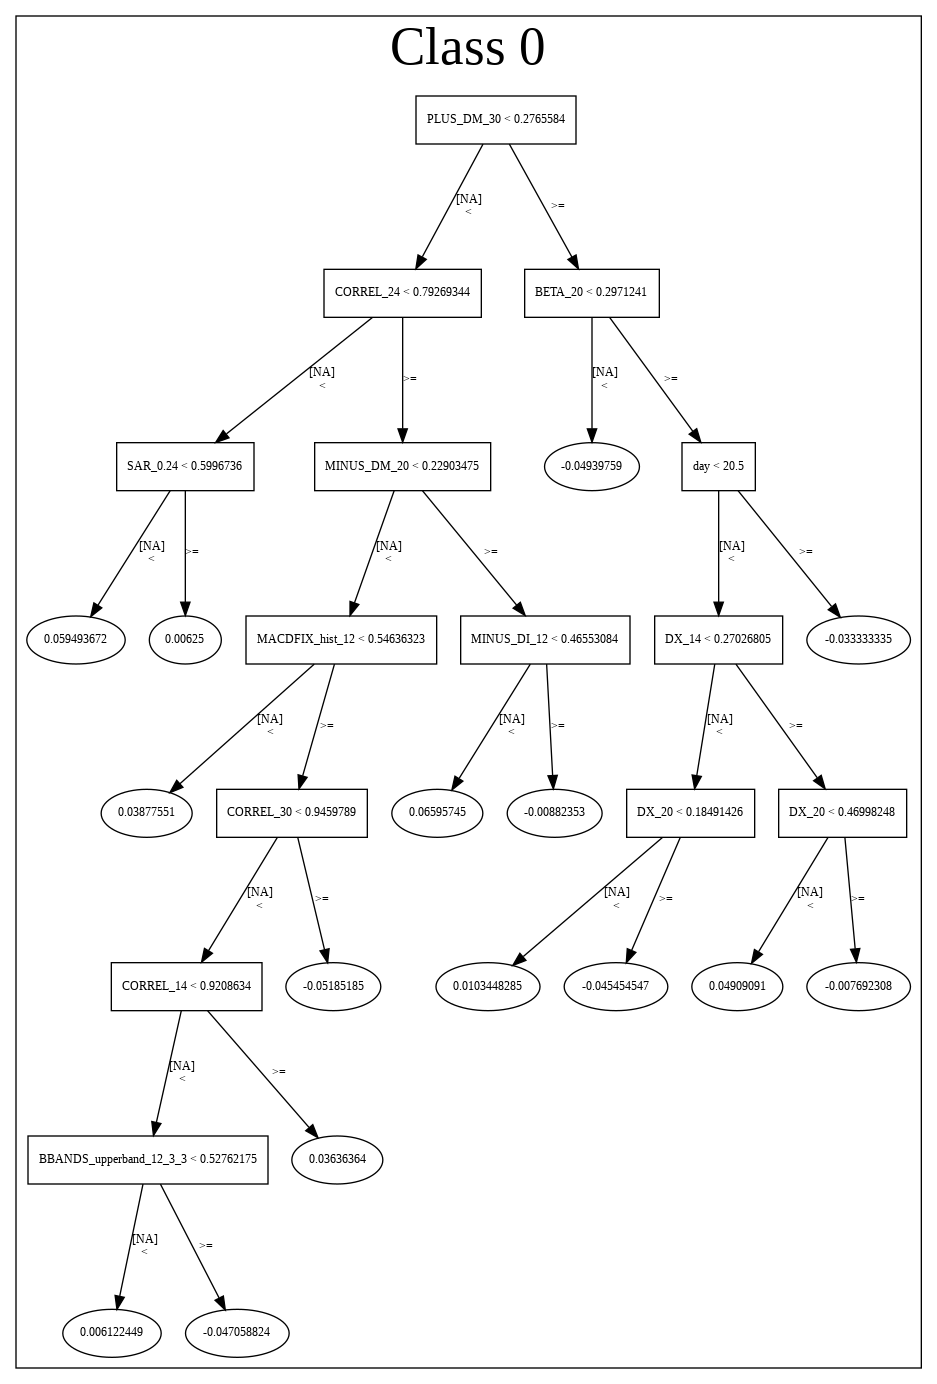

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190906_023654',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190906_023654',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b1e5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_b1e5',
   'type

['OBV',
 'ADOSC',
 'DX_20',
 'CORREL_24',
 'BETA_20',
 'Volume',
 'BETA_8',
 'BOP',
 'ADXR_14',
 'MFI_14',
 'MFI_12',
 'ADX_14',
 'ADXR_8',
 'CCI_12',
 'TRANGE',
 'MFI_30',
 'ATR_12',
 'ULTOSC',
 'PLUS_DM_30',
 'day',
 'APO',
 'CORREL_20',
 'CORREL_8',
 'HT_PHASOR_inphase',
 'PLUS_DM_8',
 'BETA_12',
 'MINUS_DI_12',
 'PLUS_DM_20',
 'dayofyear',
 'CORREL_30',
 'MACDEXT_signal',
 'DX_30',
 'SIN',
 'MFI_24',
 'DX_8',
 'SAREXT',
 'HT_PHASOR_quadrature',
 'STDDEV_30',
 'MFI_20',
 'BETA_14',
 'LINEARREG_SLOPE_8',
 'DX_14',
 'MACDEXT_hist',
 'PLUS_DI_12',
 'AROONOSC_14',
 'MACDFIX_signal_24',
 'STOCH_slowd',
 'aroonup_8',
 'MACDFIX_hist_20',
 'LINEARREG_ANGLE_8',
 'ADX_12',
 'WILLR_24',
 'STDDEV_8',
 'LINEARREG_ANGLE_20',
 'ROC_12',
 'MOM_12',
 'AROONOSC_8',
 'ADX_24',
 'CORREL_14',
 'BETA_30',
 'CCI_14',
 'STOCHRSI_fastd',
 'ADX_20',
 'TRIX_8',
 'STOCHF_fastk',
 'PLUS_DM_12',
 'BBANDS_lowerband_8_5_4',
 'VAR_20',
 'ATR_8',
 'BBANDS_lowerband_8_6_5',
 'STDDEV_20',
 'PLUS_DI_30',
 'LINEARREG_AN

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

319

['BBANDS_upperband_14_4_2',
 'BBANDS_middleband_14_4_2',
 'BBANDS_lowerband_14_4_2',
 'BBANDS_upperband_14_4_3',
 'BBANDS_middleband_14_4_3',
 'BBANDS_lowerband_14_4_3',
 'BBANDS_upperband_14_4_4',
 'BBANDS_middleband_14_4_4',
 'BBANDS_lowerband_14_4_4',
 'BBANDS_upperband_14_4_5',
 'BBANDS_middleband_14_4_5',
 'BBANDS_lowerband_14_4_5',
 'MA_14_5',
 'MAVP_14_5',
 'BBANDS_upperband_14_5_2',
 'BBANDS_middleband_14_5_2',
 'BBANDS_lowerband_14_5_2',
 'BBANDS_upperband_14_5_3',
 'BBANDS_middleband_14_5_3',
 'BBANDS_lowerband_14_5_3',
 'BBANDS_upperband_14_5_4',
 'BBANDS_middleband_14_5_4',
 'BBANDS_lowerband_14_5_4',
 'BBANDS_upperband_14_5_5',
 'BBANDS_middleband_14_5_5',
 'BBANDS_lowerband_14_5_5',
 'MA_14_6',
 'BBANDS_upperband_14_6_2',
 'BBANDS_middleband_14_6_2',
 'BBANDS_lowerband_14_6_2',
 'BBANDS_upperband_14_6_3',
 'BBANDS_middleband_14_6_3',
 'BBANDS_lowerband_14_6_3',
 'BBANDS_upperband_14_6_4',
 'BBANDS_middleband_14_6_4',
 'BBANDS_upperband_14_6_5',
 'BBANDS_middleband_14_6_5'

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_023832_model_5  0.541586  0.707607              0.480392  0.507111  0.257162
1  DeepLearning_grid_1_AutoML_20190906_023832_model_8  0.535768  0.692741              0.500000  0.499790  0.249790
2  DeepLearning_grid_1_AutoML_20190906_023832_model_9  0.532805  0.691801              0.480392  0.499327  0.249328
3               DeepLearning_1_AutoML_20190906_023832  0.529627  0.966867              0.485294  0.574459  0.330003
4  DeepLearning_grid_1_AutoML_20190906_023832_model_2  0.527473  1.944672              0.480985  0.677646  0.459205
5  DeepLearning_grid_1_AutoML_20190906_023832_model_1  0.524240  1.736240              0.490196  0.651979  0.425076
6  DeepLearning_grid_1_AutoML_20190906_023832_model_3  0.515406  1.285276              0.472366  0.627939  0.394307
7  DeepLearning_grid_1_AutoML_20190906_023832_model_6  0.507111  0.714901              0.495098  0.510649  0.260763
8  DeepLearning_grid_1_AutoML_20190906_023832_model_4  0.497522  2.856440              0.490196  0.699534  0.489347
9  DeepLearning_grid_1_AutoML_20190906_023832_model_7  0.467141  0.781152              0.495098  0.535145  0.286381

variable  relative_importance  scaled_importance  percentage
0                         OBV             1.000000           1.000000    0.004182
1                         BOP             0.959360           0.959360    0.004012
2                 CDLHIGHWAVE             0.924051           0.924051    0.003864
3                     ADXR_14             0.901740           0.901740    0.003771
4                      ADX_12             0.888357           0.888357    0.003715
..                        ...                  ...                ...         ...
314                CDL3INSIDE             0.664394           0.664394    0.002778
315  BBANDS_middleband_30_1_2             0.662315           0.662315    0.002770
316   BBANDS_lowerband_24_1_3             0.661607           0.661607    0.002767
317   BBANDS_lowerband_20_0_2             0.657084           0.657084    0.002748
318  BBANDS_middleband_24_3_2             0.647900           0.647900    0.002710

[319 rows x 4 columns]

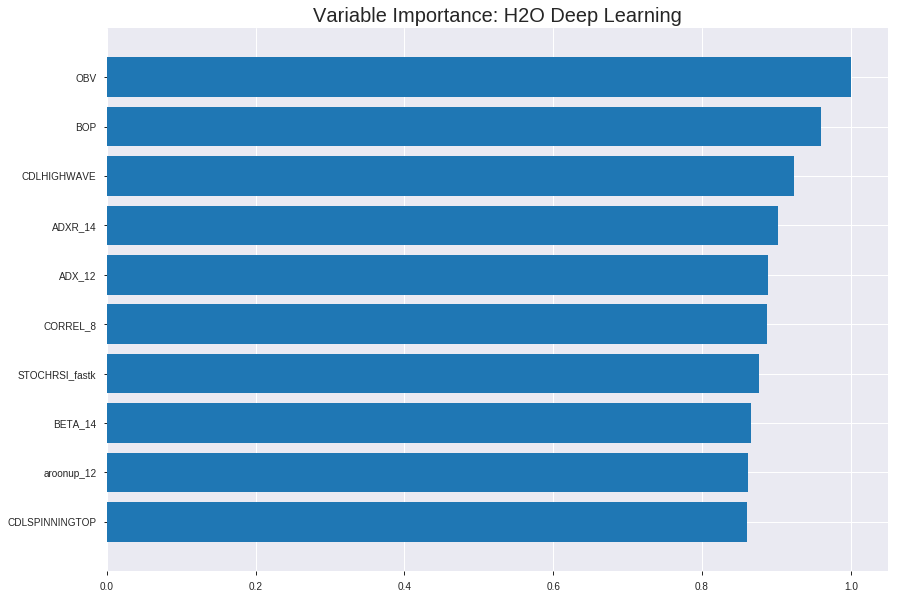

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_023832_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24102463226045007
RMSE: 0.49094259568757126
LogLoss: 0.6739069061848718
Mean Per-Class Error: 0.4348586910700485
AUC: 0.5897649827864822
pr_auc: 0.6083157981241689
Gini: 0.1795299655729643
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38885032955456966: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      49   613   0.926    (613.0/662.0)
1      14   674   0.0203   (14.0/688.0)
Total  63   1287  0.4644   (627.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.38885      0.682532  355
max f2                       0.298229     0.839844  393
max f0point5                 0.434209     0.583398  303
max accuracy                 0.5322       0.562963  171
max precision                0.920201     1         0
max recall                   0.298229     1         393
max specificity              0.920201     1         0
max absolute_mcc             0.60581      0.161924  80
max min_per_class_accuracy   0.511873     0.553779  201
max mean_per_class_accuracy  0.5322       0.565141  171

Gains/Lift Table: Avg response rate: 50.96 %, avg score: 51.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.811452           1.82205   1.82205            0.928571         0.860383  0.928571                    0.860383            0.0188953       0.0188953                  82.2051   82.2051
    2        0.02                        0.761556           1.66033   1.74419            0.846154         0.78726   0.888889                    0.825176            0.0159884       0.0348837                  66.0331   74.4186
    3        0.0303704                   0.741138           1.26142   1.57934            0.642857         0.748845  0.804878                    0.799111            0.0130814       0.0479651                  26.142    57.9339
    4        0.04                        0.721737           1.50939   1.5625             0.769231         0.730565  0.796296                    0.782609            0.0145349       0.0625                     50.9392   56.25
    5        0.0503704                   0.693675           1.68189   1.58708            0.857143         0.711733  0.808824                    0.768017            0.0174419       0.0799419                  68.1894   58.7081
    6        0.1                         0.592976           1.3179    1.45349            0.671642         0.628363  0.740741                    0.698707            0.065407        0.145349                   31.7902   45.3488
    7        0.15037                     0.572184           1.00996   1.30492            0.514706         0.58026   0.665025                    0.659031            0.0508721       0.196221                   0.996067  30.4918
    8        0.2                         0.558985           0.937175  1.21366            0.477612         0.565497  0.618519                    0.63582             0.0465116       0.242733                   -6.28254  21.3663
    9        0.3                         0.542866           1.04651   1.15795            0.533333         0.550595  0.590123                    0.607412            0.104651        0.347384                   4.65116   15.7946
    10       0.4                         0.530988           1.10465   1.14462            0.562963         0.536759  0.583333                    0.589749            0.110465        0.457849                   10.4651   14.4622
    11       0.5                         0.511672           0.944767  1.10465            0.481481         0.523161  0.562963                    0.576431            0.0944767       0.552326                   -5.52326  10.4651
    12       0.6                         0.489293           1.00291   1.08769            0.511111         0.499563  0.554321                    0.56362             0.100291        0.652616                   0.290698  8.76938
    13       0.7                         0.466969           0.944767  1.06728            0.481481         0.479462  0.543915                    0.551597            0.0944767       0.747093                   -5.52326  6.72757
    14       0.8                         0.442305           1.00291   1.05923            0.511111         0.45547   0.539815                    0.539581            0.100291        0.847384                   0.290698  5.92297
    15       0.9                         0.412848           0.843023  1.03521            0.42963          0.427498  0.527572                    0.527128            0.0843023       0.931686                   -15.6977  3.52067
    16       1                           0.213194           0.68314   1                  0.348148         0.374963  0.50963                     0.511911           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2522083801956024
RMSE: 0.5022035246746107
LogLoss: 0.6976617379383079
Mean Per-Class Error: 0.46134992458521873
AUC: 0.5025587157940099
pr_auc: 0.45665536607511603
Gini: 0.005117431588019805
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3694354603754574: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    202  0.9902   (202.0/204.0)
1      0    182  0        (0.0/182.0)
Total  2    384  0.5233   (202.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.369435     0.64311    382
max f2                       0.369435     0.818345   382
max f0point5                 0.45533      0.539972   310
max accuracy                 0.833043     0.531088   0
max precision                0.833043     1          0
max recall                   0.369435     1          382
max specificity              0.833043     1          0
max absolute_mcc             0.45533      0.0965745  310
max min_per_class_accuracy   0.495765     0.495098   193
max mean_per_class_accuracy  0.462826     0.53865    295

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 49.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.648549           1.06044   1.06044            0.5              0.743706  0.5                         0.743706            0.010989        0.010989                   6.04396   6.04396
    2        0.0207254                   0.603823           0.53022   0.79533            0.25             0.626692  0.375                       0.685199            0.00549451      0.0164835                  -46.978   -20.467
    3        0.0310881                   0.586923           1.06044   0.8837             0.5              0.595045  0.416667                    0.655147            0.010989        0.0274725                  6.04396   -11.63
    4        0.0414508                   0.578205           1.06044   0.927885           0.5              0.581029  0.4375                      0.636618            0.010989        0.0384615                  6.04396   -7.21154
    5        0.0518135                   0.567852           0.53022   0.848352           0.25             0.57221   0.4                         0.623736            0.00549451      0.043956                   -46.978   -15.1648
    6        0.101036                    0.55154            0.893002  0.870104           0.421053         0.557287  0.410256                    0.591364            0.043956        0.0879121                  -10.6998  -12.9896
    7        0.150259                    0.545766           0.893002  0.877605           0.421053         0.548451  0.413793                    0.577306            0.043956        0.131868                   -10.6998  -12.2395
    8        0.202073                    0.539689           1.16648   0.951677           0.55             0.542887  0.448718                    0.568481            0.0604396       0.192308                   16.6484   -4.83235
    9        0.300518                    0.521241           0.893002  0.932455           0.421053         0.531624  0.439655                    0.556407            0.0879121       0.28022                    -10.6998  -6.75445
    10       0.401554                    0.507102           1.14201   0.985183           0.538462         0.513917  0.464516                    0.545716            0.115385        0.395604                   14.2012   -1.48174
    11       0.5                         0.49613            1.00463   0.989011           0.473684         0.502123  0.466321                    0.537133            0.0989011       0.494505                   0.462695  -1.0989
    12       0.601036                    0.484438           1.25077   1.03301            0.589744         0.489989  0.487069                    0.529208            0.126374        0.620879                   25.0775   3.30144
    13       0.699482                    0.47329            1.00463   1.02902            0.473684         0.480145  0.485185                    0.522303            0.0989011       0.71978                    0.462695  2.90191
    14       0.800518                    0.457143           1.14201   1.04328            0.538462         0.466185  0.491909                    0.51522             0.115385        0.835165                   14.2012   4.32803
    15       0.898964                    0.430283           0.781377  1.0146             0.368421         0.447143  0.478386                    0.507765            0.0769231       0.912088                   -21.8623  1.45992
    16       1                           0.341815           0.870104  1                  0.410256         0.401317  0.471503                    0.49701    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 02:43:09  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 02:43:11  2 min  6.245 sec  715 obs/sec       1         1             1350       0.579989         1.09465             -0.34605       0.542719        0.543643           0.981105         0.484444                         0.648291           1.61067               -0.686602        0.457525          0.440203             1.06044            0.525907
    2019-09-06 02:43:22  2 min 17.058 sec  924 obs/sec       8         8             10800      0.490943         0.673907            0.0355437      0.589765        0.608316           1.82205          0.464444                         0.502204           0.697662              -0.0121213       0.502559          0.456655             1.06044            0.523316
    2019-09-06 02:43:32  2 min 27.734 sec  1011 obs/sec      16        16            21600      0.49486          0.68089             0.020091       0.601762        0.626623           1.96221          0.454074                         0.520408           0.737351              -0.0868297       0.47475           0.44277              0.53022            0.518135
    2019-09-06 02:43:43  2 min 38.654 sec  1079 obs/sec      25        25            33750      0.467773         0.619393            0.12443        0.672598        0.699135           1.96221          0.388148                         0.508293           0.712684              -0.0368166       0.525964          0.481574             1.06044            0.523316
    2019-09-06 02:43:54  2 min 49.104 sec  1127 obs/sec      34        34            45900      0.464348         0.609714            0.137205       0.688799        0.719224           1.96221          0.398519                         0.506886           0.707418              -0.0310843       0.496593          0.476363             1.06044            0.515544
    2019-09-06 02:44:04  2 min 59.194 sec  1165 obs/sec      43        43            58050      0.445611         0.566258            0.205428       0.746507        0.775068           1.96221          0.336296                         0.506019           0.706688              -0.0275586       0.532778          0.514435             1.06044            0.523316
    2019-09-06 02:44:15  3 min 10.307 sec  1195 obs/sec      53        53            71550      0.432357         0.536042            0.251993       0.77537         0.793366           1.96221          0.317778                         0.509013           0.714063              -0.0397545       0.498317          0.473024             1.06044            0.518135
    2019-09-06 02:44:16  3 min 11.392 sec  1194 obs/sec      53        53            71550      0.490943         0.673907            0.0355437      0.589765        0.608316           1.82205          0.464444                         0.502204           0.697662              -0.0121213       0.502559          0.456655             1.06044            0.523316

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
OBV                       1.0                    1.0                  0.0041819957268660075
BOP                       0.9593604803085327     0.9593604803085327   0.004012041429174404
CDLHIGHWAVE               0.9240506887435913     0.9240506887435913   0.00386437603173329
ADXR_14                   0.9017397165298462     0.9017397165298462   0.0037710716412731817
ADX_12                    0.8883568644523621     0.8883568644523621   0.003715104611071863
---                       ---                    ---                  ---
CDL3INSIDE                0.664394199848175      0.664394199848175    0.002778493704719628
BBANDS_middleband_30_1_2  0.6623146533966064     0.6623146533966064   0.002769797050345349
BBANDS_lowerband_24_1_3   0.6616067886352539     0.6616067886352539   0.0027668367629381735
BBANDS_lowerband_20_0_2   0.6570841670036316     0.6570841670036316   0.0027479231786004974
BBANDS_middleband_24_3_2  0.6479004621505737     0.6479004621505737   0.002709516964148211


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5647668393782384)

('F1', 0.65)

('auc', 0.5415858651152768)

('logloss', 0.7076065339946044)

('mean_per_class_error', 0.44553975436328375)

('rmse', 0.5071111351822741)

('mse', 0.25716170342585476)

deeplearning prediction progress: |███████████████████████████████████████| 100%


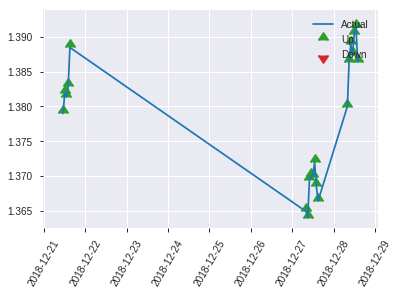


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25716170342585476
RMSE: 0.5071111351822741
LogLoss: 0.7076065339946044
Mean Per-Class Error: 0.44553975436328375
AUC: 0.5415858651152768
pr_auc: 0.5067653094194202
Gini: 0.08317173023055369
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5302619081509394: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      4    98   0.9608   (98.0/102.0)
1      0    91   0        (0.0/91.0)
Total  4    189  0.5078   (98.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.530262     0.65      188
max f2                       0.530262     0.822785  188
max f0point5                 0.558034     0.541491  154
max accuracy                 0.586706     0.564767  28
max precision                0.598558     0.666667  2
max recall                   0.530262     1         188
max specificity              0.600648     0.990196  0
max absolute_mcc             0.530262     0.13741   188
max min_per_class_accuracy   0.570925     0.5       96
max mean_per_class_accuracy  0.577543     0.55446   60

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 56.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.598653           1.06044   1.06044            0.5              0.600196  0.5                         0.600196            0.010989        0.010989                   6.04396   6.04396
    2        0.0207254                   0.597334           1.06044   1.06044            0.5              0.598073  0.5                         0.599134            0.010989        0.021978                   6.04396   6.04396
    3        0.0310881                   0.596969           2.12088   1.41392            1                0.597174  0.666667                    0.598481            0.021978        0.043956                   112.088   41.3919
    4        0.0414508                   0.595688           0         1.06044            0                0.596498  0.5                         0.597985            0               0.043956                   -100      6.04396
    5        0.0518135                   0.594792           0         0.848352           0                0.595273  0.4                         0.597443            0               0.043956                   -100      -15.1648
    6        0.103627                    0.590043           1.27253   1.06044            0.6              0.592444  0.5                         0.594944            0.0659341       0.10989                    27.2527   6.04396
    7        0.150259                    0.586478           1.88523   1.31641            0.888889         0.587868  0.62069                     0.592748            0.0879121       0.197802                   88.5226   31.6408
    8        0.202073                    0.584857           0.848352  1.19639            0.4              0.585747  0.564103                    0.590953            0.043956        0.241758                   -15.1648  19.6393
    9        0.300518                    0.578703           1.11625   1.17014            0.526316         0.580958  0.551724                    0.587679            0.10989         0.351648                   11.6252   17.014
    10       0.398964                    0.575274           0.669751  1.04667            0.315789         0.57677   0.493506                    0.584987            0.0659341       0.417582                   -33.0249  4.66676
    11       0.502591                    0.570925           0.848352  1.00578            0.4              0.572693  0.474227                    0.582452            0.0879121       0.505495                   -15.1648  0.577773
    12       0.601036                    0.567476           1.22788   1.04216            0.578947         0.569095  0.491379                    0.580264            0.120879        0.626374                   22.7877   4.21561
    13       0.699482                    0.563494           0.781377  1.00545            0.368421         0.566054  0.474074                    0.578264            0.0769231       0.703297                   -21.8623  0.545381
    14       0.797927                    0.558114           1.3395    1.04667            0.631579         0.560573  0.493506                    0.576082            0.131868        0.835165                   33.9503   4.66676
    15       0.896373                    0.547396           0.781377  1.01753            0.368421         0.551828  0.479769                    0.573418            0.0769231       0.912088                   -21.8623  1.75316
    16       1                           0.468246           0.848352  1                  0.4              0.533925  0.471503                    0.569325       

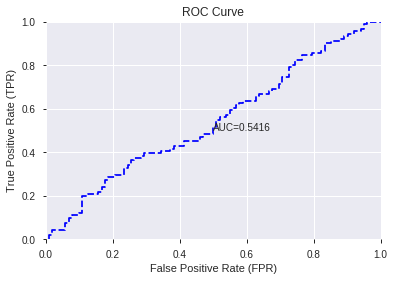

This function is available for GLM models only


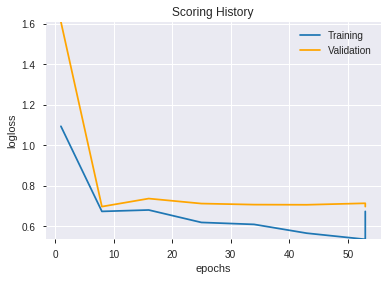

--2019-09-06 02:50:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.132.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.132.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


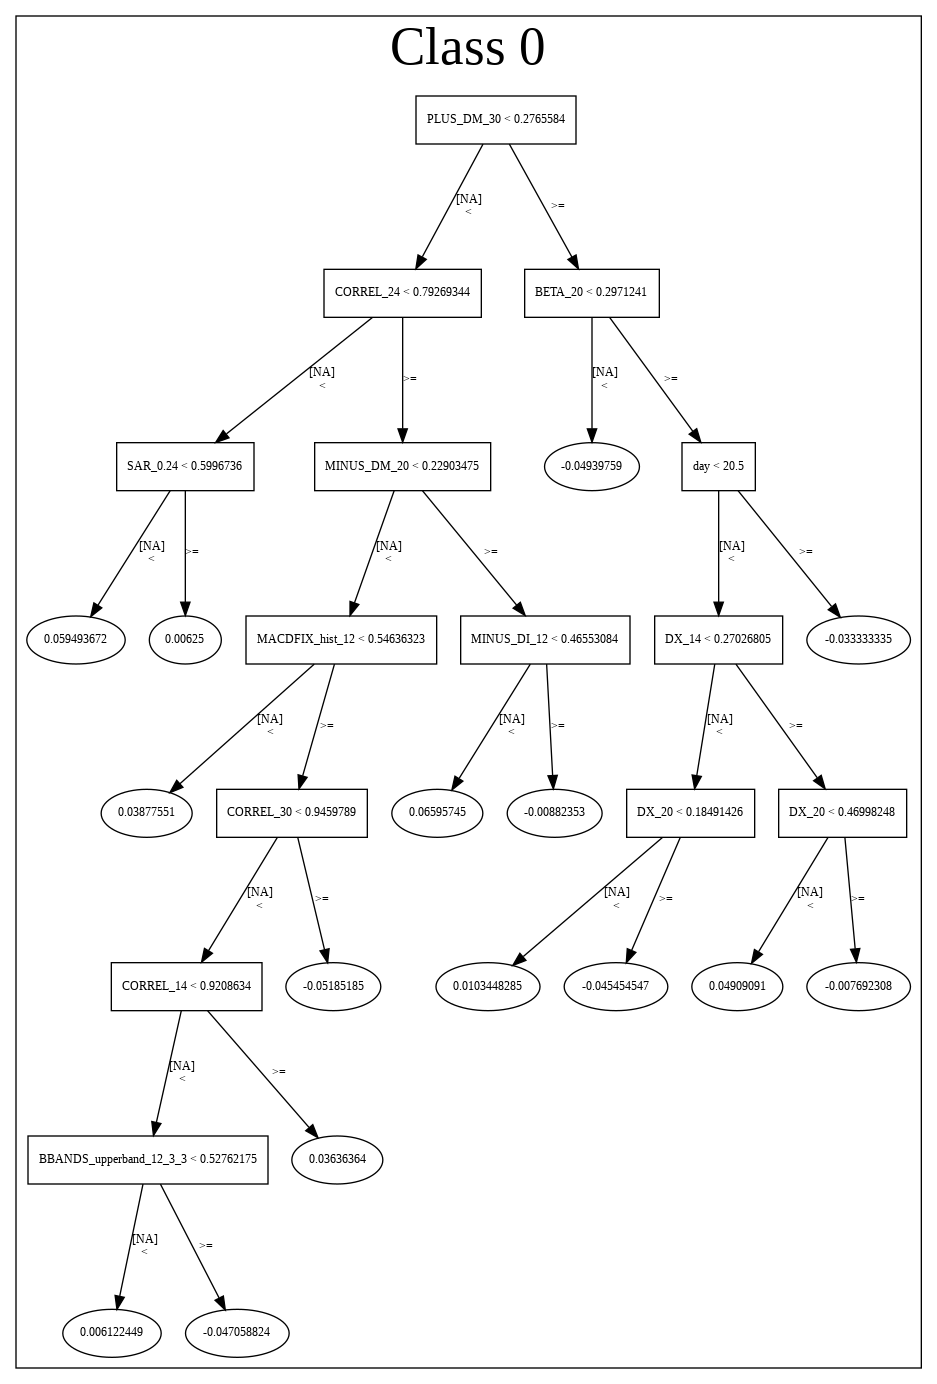

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_023832_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_023832_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b1e5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['OBV',
 'BOP',
 'CDLHIGHWAVE',
 'ADXR_14',
 'ADX_12',
 'CORREL_8',
 'STOCHRSI_fastk',
 'BETA_14',
 'aroonup_12',
 'CDLSPINNINGTOP',
 'AROONOSC_8',
 'HT_PHASOR_quadrature',
 'ADX_14',
 'aroondown_14',
 'DX_24',
 'MFI_20',
 'MFI_14',
 'STDDEV_8',
 'AROONOSC_24',
 'CDLRICKSHAWMAN',
 'DX_14',
 'DX_20',
 'HT_DCPERIOD',
 'PLUS_DI_30',
 'STOCHRSI_fastd',
 'MACDFIX_hist_20',
 'aroondown_12',
 'PLUS_DM_14',
 'PLUS_DM_8',
 'aroonup_20',
 'APO',
 'MACDEXT_hist',
 'ADX_24',
 'aroonup_24',
 'VAR_8',
 'PLUS_DI_20',
 'WILLR_14',
 'CCI_20',
 'WILLR_8',
 'CORREL_14',
 'MFI_30',
 'MINUS_DI_30',
 'CDLTAKURI',
 'ROCR100_20',
 'LINEARREG_ANGLE_8',
 'DX_30',
 'AROONOSC_30',
 'MINUS_DM_30',
 'PLUS_DI_14',
 'CDLBELTHOLD',
 'STOCHF_fastk',
 'AROONOSC_14',
 'MACDFIX_hist_14',
 'ATR_20',
 'ROCR_20',
 'aroondown_24',
 'TRANGE',
 'STOCHF_fastd',
 'AROONOSC_12',
 'MACDFIX_hist_12',
 'MACDFIX_signal_24',
 'MACDFIX_signal_14',
 'ADOSC',
 'STOCH_slowd',
 'STOCH_slowk',
 'CORREL_12',
 'MACDFIX_24',
 'PLUS_DM_30',
 'WI

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190906_025057_model_1  0.544172  0.701121              0.485294  0.503949  0.253965

variable  relative_importance  scaled_importance  percentage
0                         OBV         8.163196e-03           1.000000    0.019121
1            CDLDRAGONFLYDOJI         7.181247e-03           0.879710    0.016821
2                   CDLTAKURI         6.691133e-03           0.819671    0.015673
3         CDLRISEFALL3METHODS         6.045136e-03           0.740535    0.014160
4                  PLUS_DI_30         5.991938e-03           0.734019    0.014035
..                        ...                  ...                ...         ...
314  BBANDS_middleband_14_7_2         5.591435e-05           0.006850    0.000131
315  BBANDS_middleband_14_7_3         4.384371e-05           0.005371    0.000103
316  BBANDS_middleband_14_7_4         3.387176e-05           0.004149    0.000079
317  BBANDS_middleband_14_7_5         1.883215e-05           0.002307    0.000044
318                   CDLDOJI         9.749997e-07           0.000119    0.000002

[319 rows x 4 columns]

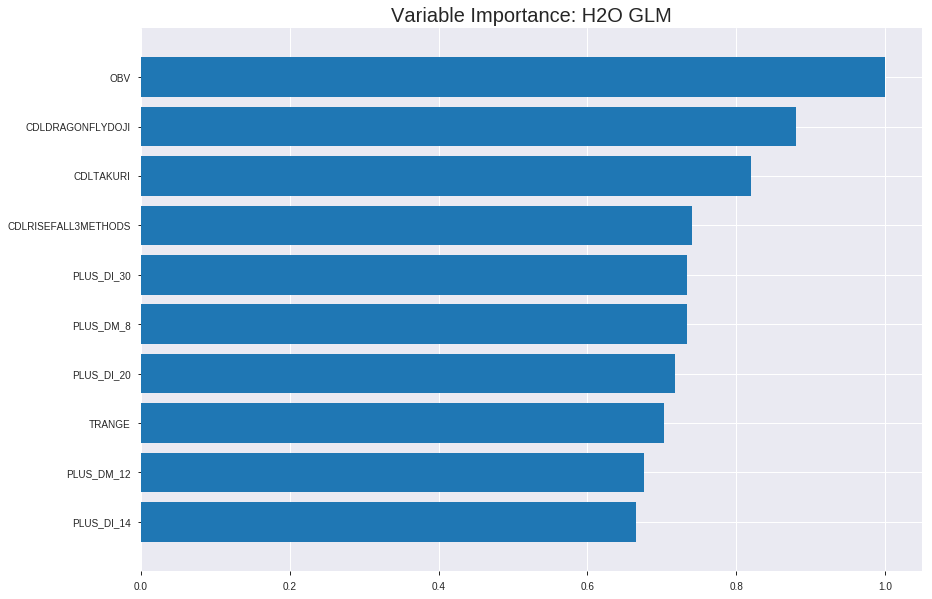

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_025057_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24689830063291096
RMSE: 0.4968886199470772
LogLoss: 0.6869278612663939
Null degrees of freedom: 1349
Residual degrees of freedom: 1030
Null deviance: 1870.9966158108023
Residual deviance: 1854.7052254192636
AIC: 2494.7052254192636
AUC: 0.5816610166514438
pr_auc: 0.5729746732814771
Gini: 0.16332203330288753
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45480351127700597: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      24   638   0.9637   (638.0/662.0)
1      7    681   0.0102   (7.0/688.0)
Total  31   1319  0.4778   (645.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.454804     0.678625  372
max f2                       0.396481     0.83882   398
max f0point5                 0.49051      0.58543   279
max accuracy                 0.514711     0.566667  173
max precision                0.572072     0.833333  5
max recall                   0.396481     1         398
max specificity              0.59313      0.998489  0
max absolute_mcc             0.516598     0.138243  163
max min_per_class_accuracy   0.510922     0.55814   192
max mean_per_class_accuracy  0.514711     0.567919  173

Gains/Lift Table: Avg response rate: 50.96 %, avg score: 50.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.562158           1.12126   1.12126            0.571429         0.57077   0.571429                    0.57077             0.0116279       0.0116279                  12.1262   12.1262
    2        0.02                        0.5547             1.20751   1.16279            0.615385         0.557485  0.592593                    0.564374            0.0116279       0.0232558                  20.7513   16.2791
    3        0.0303704                   0.551767           1.40158   1.24433            0.714286         0.553113  0.634146                    0.560529            0.0145349       0.0377907                  40.1578   24.4328
    4        0.04                        0.550225           1.81127   1.38081            0.923077         0.551195  0.703704                    0.558282            0.0174419       0.0552326                  81.127    38.0814
    5        0.0503704                   0.549169           1.26142   1.35623            0.642857         0.549764  0.691176                    0.556528            0.0130814       0.068314                   26.142    35.6233
    6        0.1                         0.54088            0.995748  1.17733            0.507463         0.545311  0.6                         0.550961            0.0494186       0.117733                   -0.4252   17.7326
    7        0.15037                     0.535041           1.06767   1.14059            0.544118         0.538004  0.581281                    0.546621            0.0537791       0.171512                   6.76727   14.0595
    8        0.2                         0.530994           1.3179    1.18459            0.671642         0.532841  0.603704                    0.543201            0.065407        0.236919                   31.7902   18.4593
    9        0.3                         0.523434           1.09012   1.1531             0.555556         0.527252  0.587654                    0.537885            0.109012        0.34593                    9.01163   15.3101
    10       0.4                         0.51687            1.19186   1.16279            0.607407         0.520044  0.592593                    0.533425            0.119186        0.465116                   19.186    16.2791
    11       0.5                         0.510905           0.915698  1.11337            0.466667         0.513904  0.567407                    0.52952             0.0915698       0.556686                   -8.43023  11.3372
    12       0.6                         0.505878           0.930233  1.08285            0.474074         0.508463  0.551852                    0.526011            0.0930233       0.649709                   -6.97674  8.28488
    13       0.7                         0.498158           0.988372  1.06935            0.503704         0.501636  0.544974                    0.522529            0.0988372       0.748547                   -1.16279  6.93522
    14       0.8                         0.489478           1.00291   1.06105            0.511111         0.493589  0.540741                    0.518911            0.100291        0.848837                   0.290698  6.10465
    15       0.9                         0.47799            0.886628  1.04167            0.451852         0.48424   0.530864                    0.515059            0.0886628       0.9375                     -11.3372  4.16667
    16       1                           0.368829           0.625     1                  0.318519         0.460765  0.50963                     0.50963          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2514803180966648
RMSE: 0.5014781332188522
LogLoss: 0.6961250152739011
Null degrees of freedom: 385
Residual degrees of freedom: 66
Null deviance: 536.100336915834
Residual deviance: 537.4085117914516
AIC: 1177.4085117914515
AUC: 0.4879875026933851
pr_auc: 0.463711548374995
Gini: -0.024024994613229822
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41543919384042244: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    182  0        (0.0/182.0)
Total  0    386  0.5285   (204.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.415439     0.640845  385
max f2                       0.415439     0.816876  385
max f0point5                 0.47198      0.532379  355
max accuracy                 0.549186     0.536269  4
max precision                0.563883     1         0
max recall                   0.415439     1         385
max specificity              0.563883     1         0
max absolute_mcc             0.428251     0.121284  380
max min_per_class_accuracy   0.500588     0.504902  192
max mean_per_class_accuracy  0.497807     0.522867  206

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 50.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.549578           1.59066   1.59066            0.75             0.556991  0.75                        0.556991            0.0164835       0.0164835                  59.0659   59.0659
    2        0.0207254                   0.545585           1.06044   1.32555            0.5              0.547559  0.625                       0.552275            0.010989        0.0274725                  6.04396   32.5549
    3        0.0310881                   0.544335           1.06044   1.23718            0.5              0.545072  0.583333                    0.549874            0.010989        0.0384615                  6.04396   23.7179
    4        0.0414508                   0.540636           0.53022   1.06044            0.25             0.541973  0.5                         0.547899            0.00549451      0.043956                   -46.978   6.04396
    5        0.0518135                   0.539453           0.53022   0.954396           0.25             0.539956  0.45                        0.54631             0.00549451      0.0494505                  -46.978   -4.56044
    6        0.101036                    0.532996           0.781377  0.870104           0.368421         0.535987  0.410256                    0.541281            0.0384615       0.0879121                  -21.8623  -12.9896
    7        0.150259                    0.527787           0.893002  0.877605           0.421053         0.53084   0.413793                    0.537861            0.043956        0.131868                   -10.6998  -12.2395
    8        0.202073                    0.524107           0.954396  0.897295           0.45             0.525992  0.423077                    0.534817            0.0494505       0.181319                   -4.56044  -10.2705
    9        0.300518                    0.515429           1.00463   0.932455           0.473684         0.519777  0.439655                    0.52989             0.0989011       0.28022                    0.462695  -6.75445
    10       0.401554                    0.507952           1.14201   0.985183           0.538462         0.511594  0.464516                    0.525287            0.115385        0.395604                   14.2012   -1.48174
    11       0.5                         0.5005             1.11625   1.01099            0.526316         0.504479  0.476684                    0.52119             0.10989         0.505495                   11.6252   1.0989
    12       0.601036                    0.493988           0.870104  0.987306           0.410256         0.497191  0.465517                    0.517156            0.0879121       0.593407                   -12.9896  -1.26942
    13       0.699482                    0.487941           0.948814  0.981888           0.447368         0.491293  0.462963                    0.513516            0.0934066       0.686813                   -5.11857  -1.81115
    14       0.800518                    0.480942           1.19639   1.00896            0.564103         0.484188  0.475728                    0.509814            0.120879        0.807692                   19.6393   0.896191
    15       0.898964                    0.473091           1.00463   1.00849            0.473684         0.476267  0.475504                    0.50614             0.0989011       0.906593                   0.462695  0.848719
    16       1                           0.415439           0.924486  1                  0.435897         0.460075  0.471503                    0.501486


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 02:50:57  0.000 sec   2            3.9       320           1.37386           1.39225
    2019-09-06 02:50:57  0.162 sec   4            2.9       320           1.37147           1.39283
    2019-09-06 02:50:57  0.322 sec   6            2.1       320           1.36871           1.39374
    2019-09-06 02:50:58  0.482 sec   8            1.5       320           1.36552           1.39479
    2019-09-06 02:50:58  0.645 sec   10           1.1       320           1.36187           1.39623

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5595854922279793)

('F1', 0.6476868327402135)

('auc', 0.54417151475975)

('logloss', 0.7011207605487079)

('mean_per_class_error', 0.45044171514759745)

('rmse', 0.5039491607147855)

('mse', 0.2539647565851367)

glm prediction progress: |████████████████████████████████████████████████| 100%


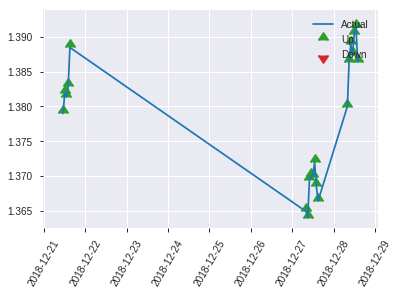


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2539647565851367
RMSE: 0.5039491607147855
LogLoss: 0.7011207605487079
Null degrees of freedom: 192
Residual degrees of freedom: -127
Null deviance: 268.05016845791704
Residual deviance: 270.63261357180124
AIC: 910.6326135718012
AUC: 0.54417151475975
pr_auc: 0.5028912202825296
Gini: 0.08834302951950002
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5001144098707994: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      3    99   0.9706   (99.0/102.0)
1      0    91   0        (0.0/91.0)
Total  3    190  0.513    (99.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.500114     0.647687  189
max f2                       0.500114     0.8213    189
max f0point5                 0.531842     0.545087  162
max accuracy                 0.558212     0.559585  61
max precision                0.575437     0.75      3
max recall                   0.500114     1         189
max specificity              0.603354     0.990196  0
max absolute_mcc             0.531842     0.118745  162
max min_per_class_accuracy   0.552233     0.538462  95
max mean_per_class_accuracy  0.558212     0.549558  61

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 54.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.582663           1.06044   1.06044            0.5              0.597988  0.5                         0.597988            0.010989        0.010989                   6.04396   6.04396
    2        0.0207254                   0.574322           2.12088   1.59066            1                0.578617  0.75                        0.588302            0.021978        0.032967                   112.088   59.0659
    3        0.0310881                   0.573088           1.06044   1.41392            0.5              0.574105  0.666667                    0.58357             0.010989        0.043956                   6.04396   41.3919
    4        0.0414508                   0.572124           1.06044   1.32555            0.5              0.572676  0.625                       0.580847            0.010989        0.0549451                  6.04396   32.5549
    5        0.0518135                   0.571219           0         1.06044            0                0.571757  0.5                         0.579029            0               0.0549451                  -100      6.04396
    6        0.103627                    0.567097           1.06044   1.06044            0.5              0.568289  0.5                         0.573659            0.0549451       0.10989                    6.04396   6.04396
    7        0.150259                    0.564672           1.17827   1.09701            0.555556         0.566221  0.517241                    0.571351            0.0549451       0.164835                   17.8266   9.70064
    8        0.202073                    0.562471           1.06044   1.08763            0.5              0.563656  0.512821                    0.569378            0.0549451       0.21978                    6.04396   8.76303
    9        0.300518                    0.558838           1.22788   1.13357            0.578947         0.560529  0.534483                    0.566479            0.120879        0.340659                   22.7877   13.3573
    10       0.398964                    0.554926           1.00463   1.10176            0.473684         0.557088  0.519481                    0.564162            0.0989011       0.43956                    0.462695  10.1755
    11       0.502591                    0.552206           0.954396  1.07137            0.45             0.553778  0.505155                    0.562021            0.0989011       0.538462                   -4.56044  7.13719
    12       0.601036                    0.548391           0.893002  1.04216            0.421053         0.550572  0.491379                    0.560145            0.0879121       0.626374                   -10.6998  4.21561
    13       0.699482                    0.54037            1.00463   1.03687            0.473684         0.544403  0.488889                    0.55793             0.0989011       0.725275                   0.462695  3.68742
    14       0.797927                    0.53454            1.11625   1.04667            0.526316         0.537381  0.493506                    0.555395            0.10989         0.835165                   11.6252   4.66676
    15       0.896373                    0.523449           0.781377  1.01753            0.368421         0.530142  0.479769                    0.552621            0.0769231       0.912088                   -21.8623  1.75316
    16       1                           0.492725           0.848352  1                  0.4              0.508961  0.471503                    0.548097         

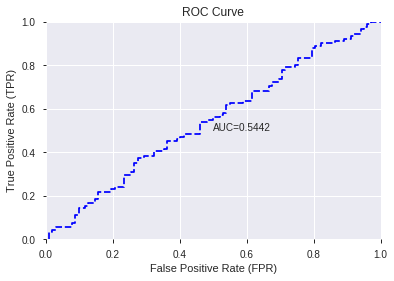

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


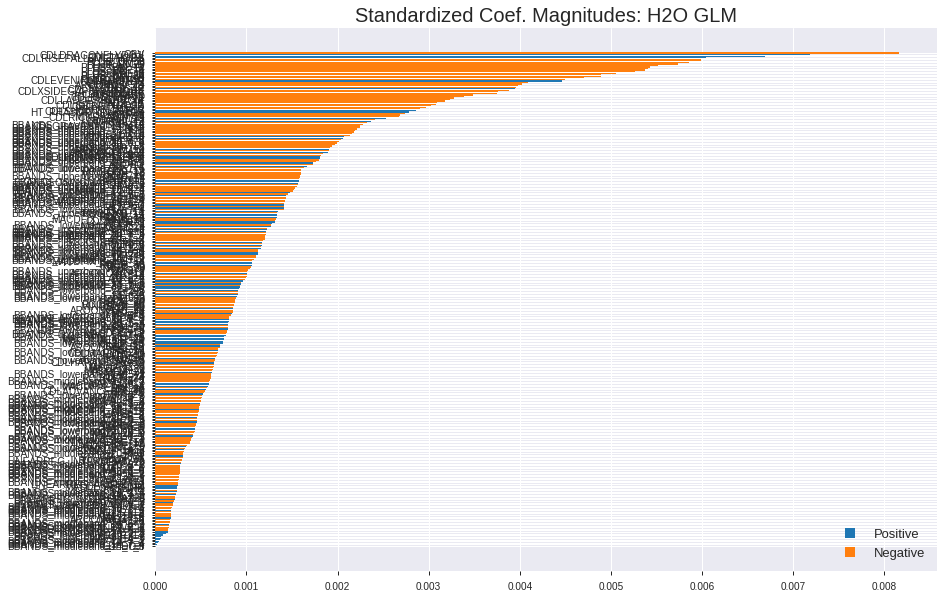

'log_likelihood'
--2019-09-06 02:51:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.92.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.92.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


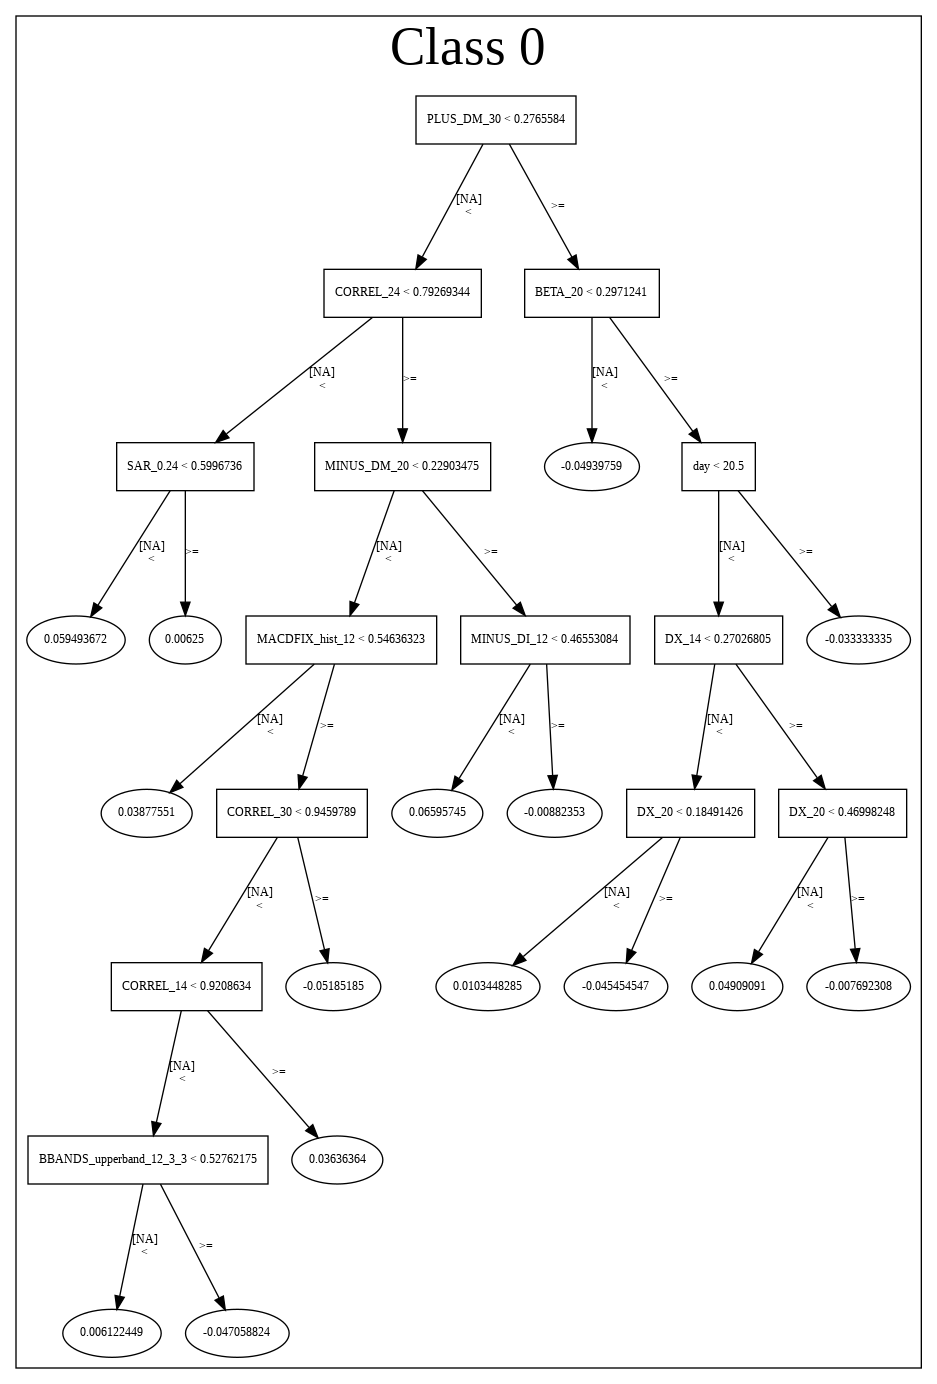

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_025057_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_025057_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b1e5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['OBV',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLRISEFALL3METHODS',
 'PLUS_DI_30',
 'PLUS_DM_8',
 'PLUS_DI_20',
 'TRANGE',
 'PLUS_DM_12',
 'PLUS_DI_14',
 'VAR_8',
 'PLUS_DM_14',
 'CORREL_8',
 'PLUS_DM_20',
 'PLUS_DM_24',
 'STDDEV_8',
 'PLUS_DM_30',
 'CDLEVENINGDOJISTAR',
 'CDLHAMMER',
 'CORREL_14',
 'AROONOSC_8',
 'STDDEV_12',
 'VAR_12',
 'CDLTASUKIGAP',
 'CDLXSIDEGAP3METHODS',
 'aroonup_12',
 'CDLHIKKAKE',
 'HT_DCPERIOD',
 'CDLHIGHWAVE',
 'ADXR_14',
 'CDLLADDERBOTTOM',
 'ADX_14',
 'ADX_12',
 'CDLSPINNINGTOP',
 'CDLBELTHOLD',
 'MINUS_DM_12',
 'ATR_8',
 'CDLSHOOTINGSTAR',
 'HT_PHASOR_quadrature',
 'NATR_8',
 'MINUS_DM_14',
 'CDLRICKSHAWMAN',
 'aroonup_24',
 'CORREL_12',
 'MFI_14',
 'MINUS_DI_12',
 'BBANDS_upperband_14_4_5',
 'CDLGRAVESTONEDOJI',
 'BBANDS_upperband_14_6_5',
 'BOP',
 'BBANDS_upperband_14_5_5',
 'BBANDS_upperband_30_1_5',
 'MINUS_DI_14',
 'BBANDS_upperband_24_5_5',
 'CDLHARAMI',
 'WILLR_8',
 'BBANDS_upperband_14_7_5',
 'BBANDS_upperband_30_6_5',
 'BBANDS_upperband_30_0_4',


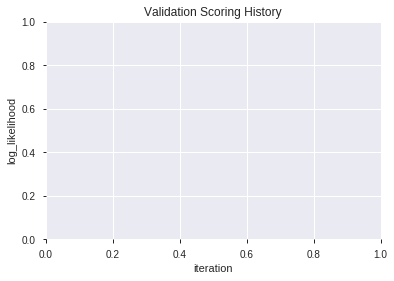

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_025124_model_2  0.561086  0.695289              0.490196  0.501084  0.251085
1  XGBoost_grid_1_AutoML_20190906_025124_model_6  0.558500  0.722232              0.480985  0.513631  0.263816
2               XGBoost_1_AutoML_20190906_025124  0.543310  0.709299              0.471181  0.507767  0.257827
3  XGBoost_grid_1_AutoML_20190906_025124_model_1  0.535822  0.696434              0.468649  0.501519  0.251521
4               XGBoost_2_AutoML_20190906_025124  0.535014  0.714928              0.485294  0.510739  0.260854
5  XGBoost_grid_1_AutoML_20190906_025124_model_3  0.533183  0.722120              0.466279  0.513725  0.263913
6  XGBoost_grid_1_AutoML_20190906_025124_model_5  0.525856  0.741368              0.495098  0.521708  0.272179
7               XGBoost_3_AutoML_20190906_025124  0.522732  0.700065              0.495098  0.503406  0.253417
8  XGBoost_grid_1_AutoML_20190906_025124_model_4  0.522517  0.722185              0.500000  0.513992  0.264188
9  XGBoost_grid_1_AutoML_20190906_025124_model_7  0.494290  0.719189              0.500000  0.512397  0.262551

variable  relative_importance  scaled_importance  percentage
0                        OBV           284.429077           1.000000    0.054798
1                        BOP           151.144684           0.531397    0.029120
2       HT_PHASOR_quadrature           116.087425           0.408142    0.022365
3                     TRANGE           112.837433           0.396716    0.021739
4                    BETA_14            98.803375           0.347374    0.019036
..                       ...                  ...                ...         ...
220                   TSF_12             0.685630           0.002411    0.000132
221  BBANDS_upperband_20_6_3             0.603278           0.002121    0.000116
222  BBANDS_upperband_20_1_3             0.353952           0.001244    0.000068
223  BBANDS_upperband_14_5_4             0.223739           0.000787    0.000043
224  BBANDS_upperband_20_3_5             0.077748           0.000273    0.000015

[225 rows x 4 columns]

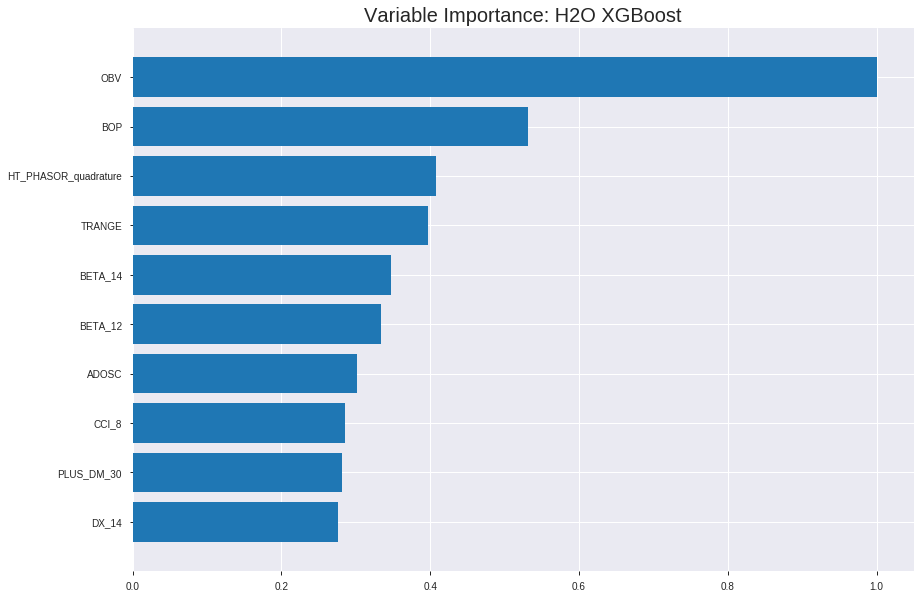

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_025124_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1784546217132359
RMSE: 0.42243889701735077
LogLoss: 0.5465218018242453
Mean Per-Class Error: 0.11880401180355515
AUC: 0.9525750017564814
pr_auc: 0.9514285151354905
Gini: 0.9051500035129627
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5057010650634766: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      568  94   0.142    (94.0/662.0)
1      66   622  0.0959   (66.0/688.0)
Total  634  716  0.1185   (160.0/1350.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.505701     0.88604   200
max f2                       0.472055     0.924839  235
max f0point5                 0.526958     0.894851  180
max accuracy                 0.505701     0.881481  200
max precision                0.76694      1         0
max recall                   0.381521     1         328
max specificity              0.76694      1         0
max absolute_mcc             0.505701     0.763344  200
max min_per_class_accuracy   0.51306      0.877644  194
max mean_per_class_accuracy  0.522261     0.881196  185

Gains/Lift Table: Avg response rate: 50.96 %, avg score: 51.12 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103704                   0.712667           1.96221    1.96221            1                0.727766  1                           0.727766            0.0203488       0.0203488                  96.2209   96.2209
    2        0.02                        0.697776           1.96221    1.96221            1                0.705749  1                           0.717165            0.0188953       0.0392442                  96.2209   96.2209
    3        0.0303704                   0.68813            1.82205    1.91435            0.928571         0.693882  0.97561                     0.709215            0.0188953       0.0581395                  82.2051   91.4351
    4        0.04                        0.682388           1.96221    1.92587            1                0.685436  0.981481                    0.70349             0.0188953       0.0770349                  96.2209   92.5872
    5        0.0503704                   0.677003           1.96221    1.93335            1                0.679832  0.985294                    0.69862             0.0203488       0.0973837                  96.2209   93.3353
    6        0.1                         0.650849           1.96221    1.94767            1                0.662601  0.992593                    0.680744            0.0973837       0.194767                   96.2209   94.7674
    7        0.15037                     0.634069           1.96221    1.95254            1                0.641898  0.995074                    0.667731            0.0988372       0.293605                   96.2209   95.2543
    8        0.2                         0.615388           1.96221    1.95494            1                0.624246  0.996296                    0.65694             0.0973837       0.390988                   96.2209   95.4942
    9        0.3                         0.58168            1.8314     1.91376            0.933333         0.597801  0.975309                    0.637227            0.18314         0.574128                   83.1395   91.376
    10       0.4                         0.550786           1.5843     1.8314             0.807407         0.56679   0.933333                    0.619618            0.15843         0.732558                   58.4302   83.1395
    11       0.5                         0.515689           1.38081    1.74128            0.703704         0.534502  0.887407                    0.602595            0.138081        0.87064                    38.0814   74.1279
    12       0.6                         0.477868           0.813953   1.58672            0.414815         0.497238  0.808642                    0.585035            0.0813953       0.952035                   -18.6047  58.6725
    13       0.7                         0.439294           0.348837   1.40988            0.177778         0.458094  0.718519                    0.566901            0.0348837       0.986919                   -65.1163  40.9884
    14       0.8                         0.406316           0.0872093  1.24455            0.0444444        0.423074  0.634259                    0.548922            0.00872093      0.99564                    -91.2791  24.4549
    15       0.9                         0.365487           0.0436047  1.11111            0.0222222        0.387457  0.566255                    0.530982            0.00436047      1                          -95.6395  11.1111
    16       1                           0.271567           0          1                  0                0.332801  0.50963                     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25576420274467476
RMSE: 0.505731354322307
LogLoss: 0.7049519945164568
Mean Per-Class Error: 0.4373249299719888
AUC: 0.5437136393018747
pr_auc: 0.5139969463503727
Gini: 0.08742727860374933
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3921571969985962: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    203  0.9951   (203.0/204.0)
1      0    182  0        (0.0/182.0)
Total  1    385  0.5259   (203.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.392157     0.641975  384
max f2                       0.392157     0.81761   384
max f0point5                 0.563198     0.540541  194
max accuracy                 0.630818     0.562176  34
max precision                0.637058     0.72      24
max recall                   0.392157     1         384
max specificity              0.681255     0.995098  0
max absolute_mcc             0.630818     0.135507  34
max min_per_class_accuracy   0.564253     0.553922  191
max mean_per_class_accuracy  0.563198     0.562675  194

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 55.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.666071           1.06044   1.06044            0.5              0.674531  0.5                         0.674531            0.010989        0.010989                   6.04396   6.04396
    2        0.0207254                   0.655406           1.06044   1.06044            0.5              0.661669  0.5                         0.6681              0.010989        0.021978                   6.04396   6.04396
    3        0.0310881                   0.648836           1.59066   1.23718            0.75             0.653764  0.583333                    0.663321            0.0164835       0.0384615                  59.0659   23.7179
    4        0.0414508                   0.642434           2.12088   1.4581             1                0.644627  0.6875                      0.658648            0.021978        0.0604396                  112.088   45.8104
    5        0.0518135                   0.640232           1.06044   1.37857            0.5              0.641302  0.65                        0.655179            0.010989        0.0714286                  6.04396   37.8571
    6        0.101036                    0.629028           1.3395    1.35954            0.631579         0.633531  0.641026                    0.644632            0.0659341       0.137363                   33.9503   35.9538
    7        0.150259                    0.61881            0.781377  1.17014            0.368421         0.624145  0.551724                    0.637921            0.0384615       0.175824                   -21.8623  17.014
    8        0.202073                    0.608561           0.742308  1.06044            0.35             0.613497  0.5                         0.631659            0.0384615       0.214286                   -25.7692  6.04396
    9        0.300518                    0.590986           1.06044   1.06044            0.5              0.60032   0.5                         0.621392            0.104396        0.318681                   6.04396   6.04396
    10       0.401554                    0.57732            0.870104  1.01255            0.410256         0.585262  0.477419                    0.612301            0.0879121       0.406593                   -12.9896  1.25487
    11       0.5                         0.563811           1.56275   1.12088            0.736842         0.570184  0.528497                    0.604009            0.153846        0.56044                    56.2753   12.0879
    12       0.601036                    0.547119           0.924486  1.08786            0.435897         0.555474  0.512931                    0.59585             0.0934066       0.653846                   -7.55142  8.78647
    13       0.699482                    0.530634           0.781377  1.04473            0.368421         0.537961  0.492593                    0.587703            0.0769231       0.730769                   -21.8623  4.47293
    14       0.800518                    0.50992            0.924486  1.02955            0.435897         0.519321  0.485437                    0.579072            0.0934066       0.824176                   -7.55142  2.9553
    15       0.898964                    0.478776           0.725564  0.996263           0.342105         0.493686  0.469741                    0.569721            0.0714286       0.895604                   -27.4436  -0.37369
    16       1                           0.377904           1.03325   1                  0.487179         0.445881  0.471503                    0.557209          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 02:51:30  0.851 sec   0                  0.5              0.693147            0.5             0                  1                0.49037                          0.5                0.693147              0.5               0                    1                  0.528497
    2019-09-06 02:51:30  1.035 sec   5                  0.490526         0.67436             0.790645        0.790782           1.85894          0.306667                         0.499122           0.691391              0.564278          0.516827             1.41392            0.523316
    2019-09-06 02:51:30  1.128 sec   10                 0.481913         0.657522            0.828099        0.835211           1.96221          0.268889                         0.499891           0.692929              0.554204          0.514174             1.06044            0.525907
    2019-09-06 02:51:30  1.209 sec   15                 0.473521         0.641323            0.859106        0.863966           1.96221          0.23037                          0.500295           0.693743              0.556898          0.510447             1.59066            0.528497
    2019-09-06 02:51:30  1.292 sec   20                 0.465319         0.625676            0.882643        0.886667           1.96221          0.212593                         0.50095            0.695072              0.558824          0.510555             1.06044            0.528497
    2019-09-06 02:51:30  1.370 sec   25                 0.458328         0.612439            0.892298        0.894286           1.96221          0.185926                         0.50137            0.695951              0.553423          0.495802             1.06044            0.528497
    2019-09-06 02:51:30  1.449 sec   30                 0.451028         0.5988              0.911157        0.913621           1.96221          0.165185                         0.502348           0.697927              0.548292          0.50698              1.59066            0.520725
    2019-09-06 02:51:31  1.535 sec   35                 0.442624         0.583283            0.929889        0.930483           1.96221          0.141481                         0.503467           0.700219              0.54234           0.503906             1.06044            0.518135
    2019-09-06 02:51:31  1.618 sec   40                 0.436077         0.571208            0.935212        0.933451           1.96221          0.134815                         0.503367           0.700064              0.557046          0.518238             1.06044            0.523316
    2019-09-06 02:51:31  1.700 sec   45                 0.429239         0.558723            0.942455        0.942099           1.96221          0.13037                          0.504396           0.702192              0.55112           0.519058             1.06044            0.512953
    2019-09-06 02:51:31  1.795 sec   50                 0.422439         0.546522            0.952575        0.951429           1.96221          0.118519                         0.505731           0.704952              0.543714          0.513997             1.06044            0.525907

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
OBV                      284.4290771484375      1.0                     0.054798293607795506
BOP                      151.14468383789062     0.5313967381717848      0.029119634480562297
HT_PHASOR_quadrature     116.0874252319336      0.4081419044627073      0.02236547991439226
TRANGE                   112.83743286132812     0.39671553271763654     0.02173933424063405
BETA_14                  98.80337524414062      0.3473743832195372      0.01903552344349107
---                      ---                    ---                     ---
TSF_12                   0.6856303215026855     0.0024105493305273764   0.00013209398997031407
BBANDS_upperband_20_6_3  0.6032779812812805     0.002121013742088129    0.00011622793378511433
BBANDS_upperband_20_1_3  0.35395246744155884    0.0012444313745631518   6.819271583806413e-05
BBANDS_upperband_14_5_4  0.2237391173839569     0.0007866253324978874   4.3105725929549e-05
BBANDS_upperband_20_3_5  0.07774773985147476    0.00027334666564663454  1.4978930840816188e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5854922279792746)

('F1', 0.6453900709219857)

('auc', 0.5610859728506787)

('logloss', 0.6952891133449804)

('mean_per_class_error', 0.4274402068519716)

('rmse', 0.5010836000379272)

('mse', 0.2510847742269694)

xgboost prediction progress: |████████████████████████████████████████████| 100%


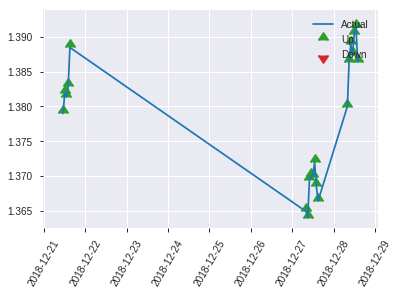


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2510847742269694
RMSE: 0.5010836000379272
LogLoss: 0.6952891133449804
Mean Per-Class Error: 0.4274402068519716
AUC: 0.5610859728506787
pr_auc: 0.5329678043555236
Gini: 0.12217194570135748
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4543483555316925: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    100  0.9804   (100.0/102.0)
1      0    91   0        (0.0/91.0)
Total  2    191  0.5181   (100.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.454348     0.64539   190
max f2                       0.454348     0.81982   190
max f0point5                 0.547151     0.546697  86
max accuracy                 0.570907     0.585492  46
max precision                0.639215     1         0
max recall                   0.454348     1         190
max specificity              0.639215     1         0
max absolute_mcc             0.570907     0.165397  46
max min_per_class_accuracy   0.542035     0.549451  93
max mean_per_class_accuracy  0.547151     0.57256   86

Gains/Lift Table: Avg response rate: 47.15 %, avg score: 54.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.635242           1.06044   1.06044            0.5              0.637753  0.5                         0.637753            0.010989        0.010989                   6.04396   6.04396
    2        0.0207254                   0.619306           1.06044   1.06044            0.5              0.627684  0.5                         0.632718            0.010989        0.021978                   6.04396   6.04396
    3        0.0310881                   0.616154           2.12088   1.41392            1                0.618212  0.666667                    0.627883            0.021978        0.043956                   112.088   41.3919
    4        0.0414508                   0.610073           2.12088   1.59066            1                0.613645  0.75                        0.624324            0.021978        0.0659341                  112.088   59.0659
    5        0.0518135                   0.601735           1.06044   1.48462            0.5              0.60592   0.7                         0.620643            0.010989        0.0769231                  6.04396   48.4615
    6        0.103627                    0.593634           0.848352  1.16648            0.4              0.598196  0.55                        0.609419            0.043956        0.120879                   -15.1648  16.6484
    7        0.150259                    0.584508           1.64957   1.31641            0.777778         0.589934  0.62069                     0.603372            0.0769231       0.197802                   64.9573   31.6408
    8        0.202073                    0.575866           0.848352  1.19639            0.4              0.579566  0.564103                    0.597268            0.043956        0.241758                   -15.1648  19.6393
    9        0.300518                    0.565565           1.11625   1.17014            0.526316         0.570494  0.551724                    0.588497            0.10989         0.351648                   11.6252   17.014
    10       0.398964                    0.553556           1.22788   1.18439            0.578947         0.56053   0.558442                    0.581596            0.120879        0.472527                   22.7877   18.4387
    11       0.502591                    0.540644           0.848352  1.1151             0.4              0.546262  0.525773                    0.574311            0.0879121       0.56044                    -15.1648  11.5101
    12       0.601036                    0.529327           0.781377  1.06044            0.368421         0.535002  0.5                         0.567872            0.0769231       0.637363                   -21.8623  6.04396
    13       0.699482                    0.520999           0.669751  1.00545            0.315789         0.525275  0.474074                    0.561877            0.0659341       0.703297                   -33.0249  0.545381
    14       0.797927                    0.505488           0.893002  0.99158            0.421053         0.512689  0.467532                    0.555808            0.0879121       0.791209                   -10.6998  -0.842015
    15       0.896373                    0.486062           1.11625   1.00527            0.526316         0.498141  0.473988                    0.549475            0.10989         0.901099                   11.6252   0.527218
    16       1                           0.41378            0.954396  1                  0.45             0.464775  0.471503                    0.540698      

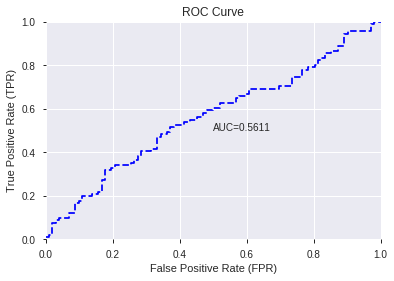

This function is available for GLM models only


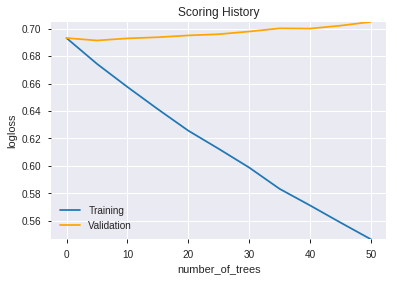

--2019-09-06 02:51:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.206.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.206.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

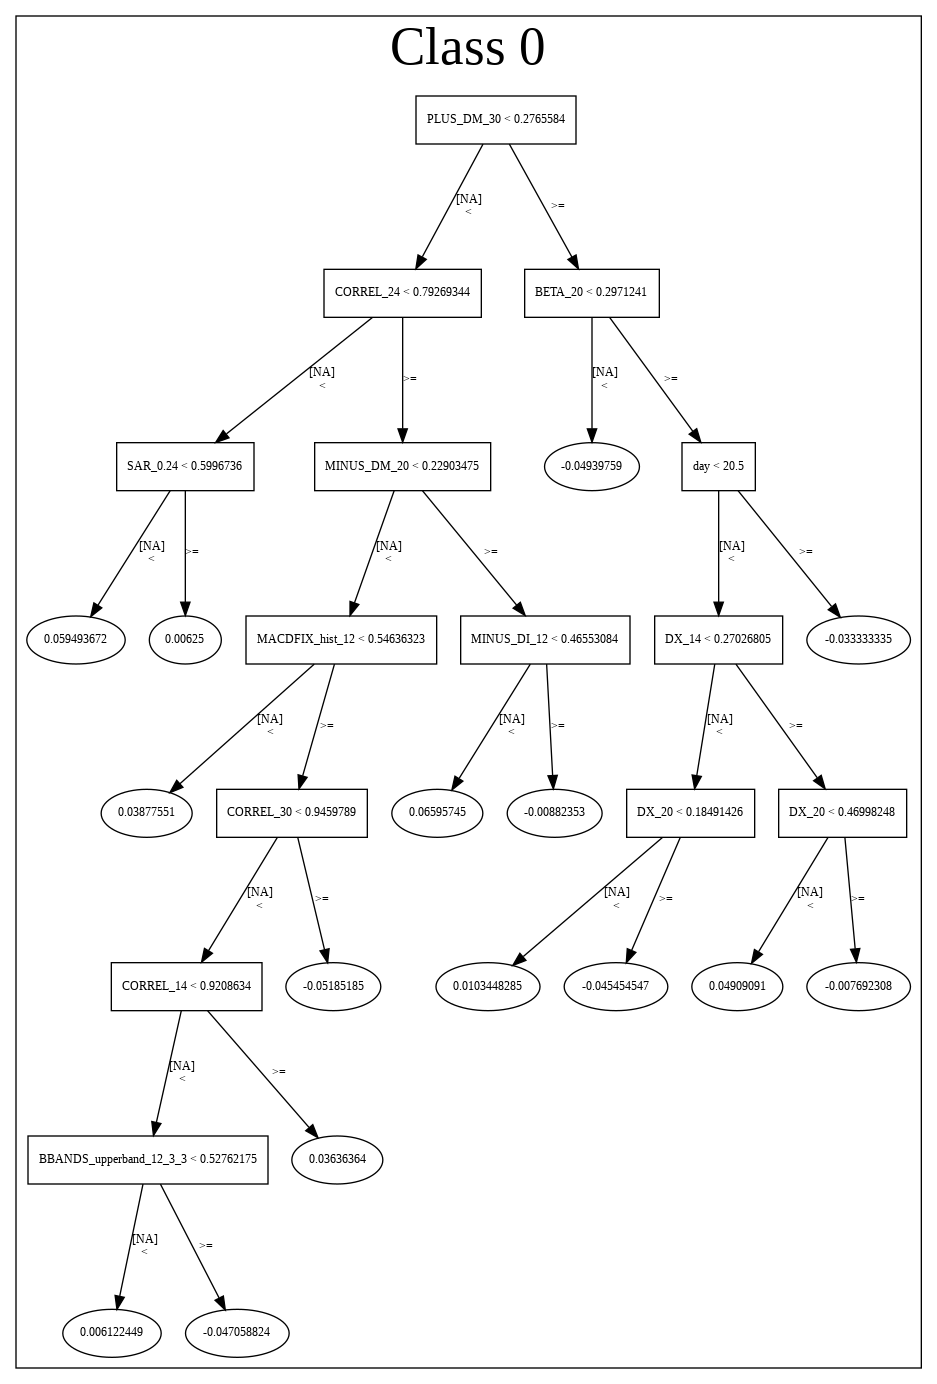

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_025124_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_025124_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b1e5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['OBV',
 'BOP',
 'HT_PHASOR_quadrature',
 'TRANGE',
 'BETA_14',
 'BETA_12',
 'ADOSC',
 'CCI_8',
 'PLUS_DM_30',
 'DX_14',
 'MFI_14',
 'STOCHRSI_fastd',
 'MOM_30',
 'STOCHF_fastk',
 'MACDEXT_hist',
 'HT_DCPERIOD',
 'MINUS_DM_12',
 'STOCH_slowd',
 'APO',
 'CCI_12',
 'STDDEV_8',
 'DX_24',
 'MACDEXT_signal',
 'ADX_24',
 'PLUS_DI_30',
 'DX_30',
 'MFI_20',
 'DX_20',
 'AD',
 'ULTOSC',
 'ADX_12',
 'STDDEV_12',
 'STOCH_slowk',
 'LINEARREG_ANGLE_12',
 'LINEARREG_ANGLE_8',
 'STOCHRSI_fastk',
 'PLUS_DM_20',
 'PLUS_DM_8',
 'WILLR_8',
 'PLUS_DM_24',
 'MACD',
 'AROONOSC_8',
 'aroonup_12',
 'MINUS_DI_12',
 'TRIX_12',
 'CORREL_12',
 'MOM_8',
 'RSI_12',
 'ADXR_14',
 'ADX_14',
 'MFI_30',
 'ATR_8',
 'PLUS_DM_12',
 'BBANDS_upperband_24_5_5',
 'RSI_30',
 'ROC_30',
 'ROC_24',
 'BBANDS_upperband_30_1_5',
 'NATR_20',
 'BBANDS_upperband_20_5_4',
 'CCI_14',
 'MOM_24',
 'ROC_12',
 'CMO_14',
 'aroondown_24',
 'BBANDS_upperband_14_6_5',
 'aroonup_24',
 'ROCR_8',
 'WILLR_30',
 'MINUS_DI_14',
 'PLUS_DI_20',
 'BBANDS_u

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.580
GLM             0.585
XGBoost         0.601
dtype: float64

DeepLearning    GLM  XGBoost
All          0.580  0.565    0.601
DLF          0.560  0.585    0.549
Fwe          0.580  0.565    0.601
RFE          0.565  0.560    0.585
XGBF         0.570  0.585    0.549





F1


DeepLearning    0.654
GLM             0.650
XGBoost         0.648
dtype: float64

DeepLearning    GLM  XGBoost
All          0.654  0.650    0.641
DLF          0.647  0.648    0.648
Fwe          0.648  0.650    0.641
RFE          0.650  0.648    0.645
XGBF         0.652  0.648    0.648





auc


DeepLearning    0.571
GLM             0.556
XGBoost         0.594
dtype: float64

DeepLearning    GLM  XGBoost
All          0.571  0.538    0.594
DLF          0.549  0.556    0.537
Fwe          0.566  0.538    0.594
RFE          0.542  0.544    0.561
XGBF         0.556  0.556    0.537





logloss


DeepLearning    3.968
GLM             0.704
XGBoost         0.726
dtype: float64

DeepLearning    GLM  XGBoost
All          1.758  0.704    0.720
DLF          0.695  0.700    0.726
Fwe          1.825  0.704    0.720
RFE          0.708  0.701    0.695
XGBF         3.968  0.700    0.726





mean_per_class_error


DeepLearning    0.446
GLM             0.450
XGBoost         0.442
dtype: float64

DeepLearning    GLM  XGBoost
All          0.411  0.444    0.400
DLF          0.434  0.406    0.442
Fwe          0.425  0.444    0.400
RFE          0.446  0.450    0.427
XGBF         0.437  0.406    0.442





rmse


DeepLearning    0.722
GLM             0.505
XGBoost         0.515
dtype: float64

DeepLearning    GLM  XGBoost
All          0.689  0.505    0.513
DLF          0.501  0.503    0.515
Fwe          0.683  0.505    0.513
RFE          0.507  0.504    0.501
XGBF         0.722  0.503    0.515





mse


DeepLearning    0.521
GLM             0.255
XGBoost         0.265
dtype: float64

DeepLearning    GLM  XGBoost
All          0.475  0.255    0.263
DLF          0.251  0.253    0.265
Fwe          0.466  0.255    0.263
RFE          0.257  0.254    0.251
XGBF         0.521  0.253    0.265

{'F1':       DeepLearning    GLM  XGBoost
 All          0.654    NaN      NaN
 DLF          0.647    NaN      NaN
 DLF            NaN  0.648      NaN
 DLF            NaN    NaN    0.648
 All            NaN  0.650      NaN
 All            NaN    NaN    0.641
 XGBF         0.652    NaN      NaN
 XGBF           NaN  0.648      NaN
 XGBF           NaN    NaN    0.648
 Fwe          0.648    NaN      NaN
 Fwe            NaN  0.650      NaN
 Fwe            NaN    NaN    0.641
 RFE          0.650    NaN      NaN
 RFE            NaN  0.648      NaN
 RFE            NaN    NaN    0.645,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.580    NaN      NaN
 DLF          0.560    NaN      NaN
 DLF            NaN  0.585      NaN
 DLF            NaN    NaN    0.549
 All            NaN  0.565      NaN
 All            NaN    NaN    0.601
 XGBF         0.570    NaN      NaN
 XGBF           NaN  0.585      NaN
 XGBF           NaN    NaN    0.549
 Fwe          0.580    NaN      NaN
 Fwe     